In [ ]:
# import sys
# !{sys.executable} -m pip install imbalanced-learn --user
# !{sys.executable} -m pip install hyperopt --user

In [1]:
import numpy
from time import time
from sklearn.model_selection import GridSearchCV
from hyperopt import tpe, fmin, hp, STATUS_OK, Trials
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from copy import deepcopy

from newsgac import config
from newsgac.genres import genre_codes
from newsgac.learners import learners, LearnerSVC, LearnerNB, LearnerXGB, LearnerGB, LearnerMLP, LearnerRF, LearnerLGBM
from newsgac.pipelines.get_sk_pipeline import get_sk_pipeline
from newsgac.pipelines.utils import report
from xgboost import XGBClassifier


from newsgac import database
from newsgac.data_sources import DataSource
from newsgac.pipelines import Pipeline

# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
# from imblearn.combine import SMOTEENN, SMOTETomek
import numpy as np
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/newsgac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
[d.display_title for d in DataSource.objects.all()]

[u'N2BGS Training',
 u'N2BGS Testing',
 u'Linked NRC (2930)',
 u'BOW + 5 features (N2BGS train)',
 u'BOW + 5 features (N2BGS test)',
 u'nrc-1950-1994-a.txt',
 u'nrc-1950-1994-b.txt',
 u'nrc-1950-1994-c.txt',
 u'nrc-1950-1994-d.txt',
 u'nrc-1950-1994-e.txt',
 u'telegraaf-1950-1994-a.txt',
 u'telegraaf-1950-1994-b.txt',
 u'telegraaf-1950-1994-c.txt',
 u'telegraaf-1950-1994-d.txt',
 u'telegraaf-1950-1994-e.txt',
 u'volkskrant-1950-1995-a.txt',
 u'volkskrant-1950-1995-b.txt',
 u'volkskrant-1950-1995-c.txt',
 u'volkskrant-1950-1995-d.txt',
 u'volkskrant-1950-1995-e.txt',
 u'nrc-1965.txt',
 u'nrc-1985.txt',
 u'BOW + 9 features (N2BGS train)',
 u'BOW + 9 features (N2BGS test)',
 u'Linked NRC (2930/9 features)',
 u'BOW Train unique (9 features)',
 u'BOW Test unique (9 features)',
 u'Linked NRC (unique/9 features)',
 u'BOW Train unique (N3BGS/9 features)',
 u'N3BGS FROG Test',
 u'N3BGS FROG Train',
 u'BOW Test unique (N3BGS/9 features)',
 u'BOW Test unique (N3BGS/9 features/collapsed)',
 u'Link

In [3]:
[d.display_title for d in Pipeline.objects.all()]

[u'dummy frog',
 u'dummy bow',
 u'RF FROG',
 u'SVC FROG',
 u'XGB FROG',
 u'NB FROG',
 u'MLP FROG',
 u'RF BOW',
 u'SVC BOW',
 u'XGB BOW',
 u'NB BOW',
 u'MLP BOW',
 u'SVC LIN BOW',
 u'Erik MLP BOW (with stop-words)',
 u'Erik MLP BOW (5 features) ',
 u'Erik MLP BOW (9 features) ',
 u'Erik SVC BOW (9 features)',
 u'Erik RF BOW (9 features)',
 u'Erik XGB BOW (9 features)',
 u'Erik NB BOW (9 features)',
 u'Erik MLP unique 9 features',
 u'Erik NB unique (9 features)',
 u'Erik XGB unique (9 features)',
 u'Erik SVC unique (9 features)',
 u'Erik RF unique (9 features)',
 u'N3BGS MLP unique 9 features',
 u'N3BGS NB unique 9 features ',
 u'N3BGS SVC unique 9 features ',
 u'N3BGS RF unique 9 features',
 u'N3BGS XGB unique 9 features ',
 u'dummy n3bgs bow',
 u'dummy n3bgs frog',
 u'RF FROG N3BGS',
 u'SVC FROG N3BGS',
 u'XGB FROG N3BGS',
 u'Erik NB N3BGS Collapsed',
 u'Erik MLP N3BGS Collapsed',
 u'Erik MLP Linked NRC (2930 articles)',
 u'Erik RF Linked NRC (2930 articles) ',
 u'Erik NB Linked NRC (2

In [4]:
p = Pipeline.objects.all()[59]
print 'Pipeline: ' + p.display_title
print 'DataSource: ' + p.data_source.display_title
print 'NLP Tool: ' + p.nlp_tool.name
print 'Classifier: ' + p.learner.name
print 'Task status: ' + str(p.task.status)

Pipeline: dummy combi for opt ugs
DataSource: 20190228 unbalanced train size=3443
NLP Tool: Frog + TFIDF
Classifier: Multi-Layer Perceptron
Task status: Status.SUCCESS


In [5]:
len(p.data_source.articles)

3099

In [6]:
test_data_source = DataSource.objects.all()[39]
print 'Testing data source: ' + test_data_source.display_title

Testing data source: 20190228 unbalanced test size=3443


In [7]:
skp = p.get_sk_pipeline()
skp_opt = deepcopy(skp)
skp_opt.steps.pop()
skp_opt.steps

[('CleanOCR', <newsgac.nlp_tools.transformers.CleanOCR at 0x7f21aacec3d0>),
 ('StopWordRemoval',
  <newsgac.nlp_tools.transformers.StopWordRemoval at 0x7f21aacec5d0>),
 ('FeatureExtraction', FeatureUnion(n_jobs=None,
         transformer_list=[('frog', FeatureUnion(n_jobs=None,
         transformer_list=[('Basic', <newsgac.nlp_tools.transformers.ExtractBasicFeatures object at 0x7f21a8396e10>), ('Quote', <newsgac.nlp_tools.transformers.ExtractQuotes object at 0x7f21a8396e50>), ('Sentiment', Pipeline(memory=None,
       steps=...\b', tokenizer=None, use_idf=True,
          vocabulary=None))]))],
         transformer_weights=None))],
         transformer_weights=None)),
 ('RobustScaler',
  RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
         with_scaling=True))]

In [8]:
texts = numpy.array([article.raw_text for article in p.data_source.articles])
labels = numpy.array([article.label for article in p.data_source.articles])

X = skp_opt.fit_transform(texts)

In [9]:
# get the test dataset for optimization accuracy
texts_test = numpy.array([article.raw_text for article in test_data_source.articles])
labels_test = numpy.array([article.label for article in test_data_source.articles])

X_test = skp_opt.transform(texts_test)

In [10]:
X_train = X
y_train = labels
y_test = labels_test

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [12]:
X_train.shape

(2479, 26984)

In [13]:
y_val.shape

(620,)

In [14]:
importance_type_list = ['gain', 'weight', 'cover', 'total_gain', 'total_cover']
booster_list = ['gbtree', 'gblinear', 'dart']
max_depth_list = np.arange(1, 10, dtype=int)

In [15]:
def optimize(evals, trials, optimizer=tpe.suggest):
    space = {
#         'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
        'n_estimators': hp.choice('n_estimators', np.arange(10, 500, dtype=int)),
        'learning_rate': hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', max_depth_list),
#         'max_depth': hp.quniform('max_depth', 1, 30, 1),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'importance_type': hp.choice('importance_type', importance_type_list),
#         'eval_metric': 'auc',
#         'objective': 'binary:logistic',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
#         'nthread': 48,
        'booster': hp.choice('booster', booster_list),
#         'tree_method': 'exact',
#         'silent': 1,
#         'seed': 42
    }
    best = fmin(score, space, algo=optimizer, max_evals=evals, trials=trials)
    pbar.close()
    return best

In [16]:
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

def score(params):
    eval_set=[(X_train, y_train), (X_val, y_val)]
    
    model = XGBClassifier(n_estimators = params['n_estimators'],
                          learning_rate = params['learning_rate'],
                            max_depth = params['max_depth'],
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'], 
                            gamma = params['gamma'],
                            colsample_bytree = params['colsample_bytree'],
                            importance_type = params['importance_type'],
                            booster=params['booster'],
                            objective = "multi:softprob",
                            n_jobs=24,
                            random_state=42,
                            silent=False,)

    model.fit(X_train, y_train, eval_set=eval_set, verbose=False)   

    train_acc = accuracy_score(y_train, model.predict(X_train))
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    test_loss = log_loss(y_test, model.predict_proba(X_test))
    
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    
    print('Parameters with this training accuracy {} and loss {} :'.format(train_acc, train_loss))
    print('Parameters with this testing accuracy {} and loss {} :'.format(test_acc, test_loss))
    print(params)
    pbar.update()
#     return {'loss': test_loss, 'status': STATUS_OK}
    return {'loss': -test_acc, 'status': STATUS_OK}

In [ ]:
import time
from tqdm import tqdm
import numpy as np

trials = Trials()
cores = 48
start = time.time()
evaluations = 1000
pbar = tqdm(total=evaluations, desc="Hyperopt")
best_param = optimize(evals=evaluations,
                      optimizer=tpe.suggest,
                      trials=trials)
print("------------------------------------")
print("The best hyperparameters are: ", "\n")
print(best_param)
end = time.time()
print('Time elapsed to optimize {0} executions: {1}'.format(evaluations, end - start))
best_param['importance_type'] = importance_type_list[best_param['importance_type']]
best_param['booster'] = booster_list[best_param['booster']]
best_param['max_depth'] = max_depth_list[best_param['max_depth']]
print('\n Best score:')
score(best_param)

Hyperopt:   0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 0/1000 [00:00<?, ?it/s, best loss: ?]
Parameters with this training accuracy 0.993545784591 and loss 0.096155541371 :

  0%|          | 0/1000 [00:39<?, ?it/s, best loss: ?]
Parameters with this testing accuracy 0.633720930233 and loss 1.20372400889 :

  0%|          | 0/1000 [00:39<?, ?it/s, best loss: ?]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 5.0, 'n_estimators': 304, 'subsample': 0.75, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 0.55, 'booster': 'gbtree'}

  0%|          | 0/1000 [00:39<?, ?it/s, best loss: ?]

Hyperopt:   0%|          | 1/1000 [00:39<11:03:36, 39.86s/it]


  0%|          | 1/1000 [00:39<10:57:34, 39.49s/it, best loss: -0.633720930233]
Parameters with this training accuracy 0.949173053651 and loss 0.276840678582 :

  0%|          | 1/1000 [01:25<10:57:34, 39.49s/it, best loss: -0.633720930233]
Parameters with this testing accuracy 0.639534883721 and loss 1.15090173582 :

  0%|          | 1/1000 [01:25<10:57:34, 39.49s/it, best loss: -0.633720930233]
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'min_child_weight': 6.0, 'n_estimators': 355, 'subsample': 0.75, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'dart'}

  0%|          | 1/1000 [01:25<10:57:34, 39.49s/it, best loss: -0.633720930233]

Hyperopt:   0%|          | 2/1000 [01:25<11:31:26, 41.57s/it]


  0%|          | 2/1000 [01:25<11:27:12, 41.32s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.474384832594 and loss 1.76767888648 :

  0%|          | 2/1000 [01:32<11:27:12, 41.32s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.488372093023 and loss 1.75948645255 :

  0%|          | 2/1000 [01:32<11:27:12, 41.32s/it, best loss: -0.639534883721]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.2, 'min_child_weight': 6.0, 'n_estimators': 216, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

  0%|          | 2/1000 [01:32<11:27:12, 41.32s/it, best loss: -0.639534883721]

Hyperopt:   0%|          | 3/1000 [01:32<8:39:56, 31.29s/it] 


  0%|          | 3/1000 [01:32<8:36:57, 31.11s/it, best loss: -0.639534883721] 
Parameters with this training accuracy 0.989915288423 and loss 0.117470282744 :

  0%|          | 3/1000 [01:39<8:36:57, 31.11s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.613372093023 and loss 1.29365630601 :

  0%|          | 3/1000 [01:39<8:36:57, 31.11s/it, best loss: -0.639534883721]
{'colsample_bytree': 0.8, 'learning_rate': 0.42500000000000004, 'min_child_weight': 2.0, 'n_estimators': 59, 'subsample': 1.0, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.55, 'booster': 'dart'}

  0%|          | 3/1000 [01:39<8:36:57, 31.11s/it, best loss: -0.639534883721]

Hyperopt:   0%|          | 4/1000 [01:40<6:40:01, 24.10s/it]


  0%|          | 4/1000 [01:39<6:37:56, 23.97s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.935861234369 and loss 0.324961267471 :

  0%|          | 4/1000 [02:04<6:37:56, 23.97s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.639534883721 and loss 1.11298690385 :

  0%|          | 4/1000 [02:04<6:37:56, 23.97s/it, best loss: -0.639534883721]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 6.0, 'n_estimators': 240, 'subsample': 1.0, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.8500000000000001, 'booster': 'dart'}

  0%|          | 4/1000 [02:04<6:37:56, 23.97s/it, best loss: -0.639534883721]

Hyperopt:   0%|          | 5/1000 [02:04<6:41:25, 24.21s/it]


  0%|          | 5/1000 [02:04<6:39:59, 24.12s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.474384832594 and loss 1.76761526065 :

  0%|          | 5/1000 [02:19<6:39:59, 24.12s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.488372093023 and loss 1.75937434752 :

  0%|          | 5/1000 [02:19<6:39:59, 24.12s/it, best loss: -0.639534883721]
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 6.0, 'n_estimators': 481, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.65, 'booster': 'gblinear'}

  0%|          | 5/1000 [02:19<6:39:59, 24.12s/it, best loss: -0.639534883721]

Hyperopt:   1%|          | 6/1000 [02:19<5:56:35, 21.52s/it]


  1%|          | 6/1000 [02:19<5:55:33, 21.46s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.993949173054 and loss 0.0978277402738 :

  1%|          | 6/1000 [02:47<5:55:33, 21.46s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.610465116279 and loss 1.3011204668 :

  1%|          | 6/1000 [02:47<5:55:33, 21.46s/it, best loss: -0.639534883721]
{'colsample_bytree': 0.5, 'learning_rate': 0.47500000000000003, 'min_child_weight': 1.0, 'n_estimators': 296, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.75, 'booster': 'dart'}

  1%|          | 6/1000 [02:47<5:55:33, 21.46s/it, best loss: -0.639534883721]

Hyperopt:   1%|          | 7/1000 [02:47<6:28:12, 23.46s/it]


  1%|          | 7/1000 [02:47<6:27:31, 23.42s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.474384832594 and loss 1.7672670793 :

  1%|          | 7/1000 [02:55<6:27:31, 23.42s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.488372093023 and loss 1.75876205846 :

  1%|          | 7/1000 [02:55<6:27:31, 23.42s/it, best loss: -0.639534883721]
{'colsample_bytree': 1.0, 'learning_rate': 0.5, 'min_child_weight': 1.0, 'n_estimators': 226, 'subsample': 0.55, 'importance_type': 'total_gain', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

  1%|          | 7/1000 [02:55<6:27:31, 23.42s/it, best loss: -0.639534883721]

Hyperopt:   1%|          | 8/1000 [02:55<5:09:34, 18.72s/it]


  1%|          | 8/1000 [02:55<5:09:03, 18.69s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.985074626866 and loss 0.156408045762 :

  1%|          | 8/1000 [03:16<5:09:03, 18.69s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.636627906977 and loss 1.14046281736 :

  1%|          | 8/1000 [03:16<5:09:03, 18.69s/it, best loss: -0.639534883721]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.25, 'min_child_weight': 5.0, 'n_estimators': 161, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 1.0, 'booster': 'gbtree'}

  1%|          | 8/1000 [03:16<5:09:03, 18.69s/it, best loss: -0.639534883721]

Hyperopt:   1%|          | 9/1000 [03:16<5:20:32, 19.41s/it]


  1%|          | 9/1000 [03:16<5:20:12, 19.39s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.993142396127 and loss 0.106844122472 :

  1%|          | 9/1000 [04:15<5:20:12, 19.39s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.630813953488 and loss 1.21320322969 :

  1%|          | 9/1000 [04:15<5:20:12, 19.39s/it, best loss: -0.639534883721]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.225, 'min_child_weight': 2.0, 'n_estimators': 335, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.8, 'booster': 'dart'}

  1%|          | 9/1000 [04:15<5:20:12, 19.39s/it, best loss: -0.639534883721]

Hyperopt:   1%|          | 10/1000 [04:15<8:38:34, 31.43s/it]


  1%|          | 10/1000 [04:15<8:38:21, 31.42s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.474384832594 and loss 1.76726703553 :

  1%|          | 10/1000 [04:28<8:38:21, 31.42s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.488372093023 and loss 1.75876194128 :

  1%|          | 10/1000 [04:28<8:38:21, 31.42s/it, best loss: -0.639534883721]
{'colsample_bytree': 0.8, 'learning_rate': 0.35000000000000003, 'min_child_weight': 3.0, 'n_estimators': 376, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.9500000000000001, 'booster': 'gblinear'}

  1%|          | 10/1000 [04:28<8:38:21, 31.42s/it, best loss: -0.639534883721]

Hyperopt:   1%|          | 11/1000 [04:28<7:05:02, 25.79s/it]


  1%|          | 11/1000 [04:28<7:04:50, 25.77s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.989108511497 and loss 0.129592197933 :

  1%|          | 11/1000 [04:59<7:04:50, 25.77s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.601744186047 and loss 1.28270558414 :

  1%|          | 11/1000 [04:59<7:04:50, 25.77s/it, best loss: -0.639534883721]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.325, 'min_child_weight': 2.0, 'n_estimators': 264, 'subsample': 0.9, 'importance_type': 'total_gain', 'max_depth': 3, 'gamma': 0.8500000000000001, 'booster': 'dart'}

  1%|          | 11/1000 [04:59<7:04:50, 25.77s/it, best loss: -0.639534883721]

Hyperopt:   1%|          | 12/1000 [05:00<7:33:46, 27.56s/it]


  1%|          | 12/1000 [04:59<7:33:40, 27.55s/it, best loss: -0.639534883721]
Parameters with this training accuracy 0.912061315046 and loss 0.37978851046 :

  1%|          | 12/1000 [05:08<7:33:40, 27.55s/it, best loss: -0.639534883721]
Parameters with this testing accuracy 0.642441860465 and loss 1.17302318989 :

  1%|          | 12/1000 [05:08<7:33:40, 27.55s/it, best loss: -0.639534883721]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.225, 'min_child_weight': 5.0, 'n_estimators': 249, 'subsample': 0.65, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

  1%|          | 12/1000 [05:08<7:33:40, 27.55s/it, best loss: -0.639534883721]

Hyperopt:   1%|▏         | 13/1000 [05:09<6:01:52, 22.00s/it]


  1%|▏         | 13/1000 [05:08<6:01:48, 21.99s/it, best loss: -0.642441860465]
Parameters with this training accuracy 0.951593384429 and loss 0.25665326492 :

  1%|▏         | 13/1000 [05:27<6:01:48, 21.99s/it, best loss: -0.642441860465]
Parameters with this testing accuracy 0.642441860465 and loss 1.12372757193 :

  1%|▏         | 13/1000 [05:27<6:01:48, 21.99s/it, best loss: -0.642441860465]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 94, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'dart'}

  1%|▏         | 13/1000 [05:27<6:01:48, 21.99s/it, best loss: -0.642441860465]

Hyperopt:   1%|▏         | 14/1000 [05:27<5:43:11, 20.88s/it]


  1%|▏         | 14/1000 [05:27<5:43:07, 20.88s/it, best loss: -0.642441860465]
Parameters with this training accuracy 0.976603469141 and loss 0.197659663128 :

  1%|▏         | 14/1000 [06:26<5:43:07, 20.88s/it, best loss: -0.642441860465]
Parameters with this testing accuracy 0.636627906977 and loss 1.15951212205 :

  1%|▏         | 14/1000 [06:26<5:43:07, 20.88s/it, best loss: -0.642441860465]
{'colsample_bytree': 0.9, 'learning_rate': 0.07500000000000001, 'min_child_weight': 5.0, 'n_estimators': 348, 'subsample': 0.75, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 1.0, 'booster': 'dart'}

  1%|▏         | 14/1000 [06:26<5:43:07, 20.88s/it, best loss: -0.642441860465]

Hyperopt:   2%|▏         | 15/1000 [06:26<8:50:43, 32.33s/it]


  2%|▏         | 15/1000 [06:26<8:50:41, 32.33s/it, best loss: -0.642441860465]
Parameters with this training accuracy 0.474384832594 and loss 1.76726765285 :

  2%|▏         | 15/1000 [06:36<8:50:41, 32.33s/it, best loss: -0.642441860465]
Parameters with this testing accuracy 0.488372093023 and loss 1.75876309677 :

  2%|▏         | 15/1000 [06:36<8:50:41, 32.33s/it, best loss: -0.642441860465]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.30000000000000004, 'min_child_weight': 6.0, 'n_estimators': 367, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.75, 'booster': 'gblinear'}

  2%|▏         | 15/1000 [06:36<8:50:41, 32.33s/it, best loss: -0.642441860465]

Hyperopt:   2%|▏         | 16/1000 [06:37<7:03:19, 25.81s/it]


  2%|▏         | 16/1000 [06:36<7:03:16, 25.81s/it, best loss: -0.642441860465]
Parameters with this training accuracy 0.474384832594 and loss 1.76727880219 :

  2%|▏         | 16/1000 [06:50<7:03:16, 25.81s/it, best loss: -0.642441860465]
Parameters with this testing accuracy 0.488372093023 and loss 1.7587832238 :

  2%|▏         | 16/1000 [06:50<7:03:16, 25.81s/it, best loss: -0.642441860465]
{'colsample_bytree': 0.65, 'learning_rate': 0.2, 'min_child_weight': 6.0, 'n_estimators': 420, 'subsample': 0.9, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}

  2%|▏         | 16/1000 [06:50<7:03:16, 25.81s/it, best loss: -0.642441860465]

Hyperopt:   2%|▏         | 17/1000 [06:50<6:01:30, 22.07s/it]


  2%|▏         | 17/1000 [06:50<6:01:28, 22.06s/it, best loss: -0.642441860465]
Parameters with this training accuracy 0.821702299314 and loss 0.660666488691 :

  2%|▏         | 17/1000 [06:52<6:01:28, 22.06s/it, best loss: -0.642441860465]
Parameters with this testing accuracy 0.613372093023 and loss 1.20491124882 :

  2%|▏         | 17/1000 [06:52<6:01:28, 22.06s/it, best loss: -0.642441860465]
{'colsample_bytree': 0.75, 'learning_rate': 0.225, 'min_child_weight': 2.0, 'n_estimators': 19, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.9, 'booster': 'dart'}

  2%|▏         | 17/1000 [06:52<6:01:28, 22.06s/it, best loss: -0.642441860465]

Hyperopt:   2%|▏         | 18/1000 [06:52<4:24:18, 16.15s/it]


  2%|▏         | 18/1000 [06:52<4:24:16, 16.15s/it, best loss: -0.642441860465]
Parameters with this training accuracy 0.982654296087 and loss 0.163526806672 :

  2%|▏         | 18/1000 [07:32<4:24:16, 16.15s/it, best loss: -0.642441860465]
Parameters with this testing accuracy 0.645348837209 and loss 1.15372568006 :

  2%|▏         | 18/1000 [07:32<4:24:16, 16.15s/it, best loss: -0.642441860465]
{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'min_child_weight': 6.0, 'n_estimators': 231, 'subsample': 1.0, 'importance_type': 'total_gain', 'max_depth': 7, 'gamma': 0.8500000000000001, 'booster': 'dart'}

  2%|▏         | 18/1000 [07:32<4:24:16, 16.15s/it, best loss: -0.642441860465]

Hyperopt:   2%|▏         | 19/1000 [07:32<6:21:32, 23.34s/it]


  2%|▏         | 19/1000 [07:32<6:21:33, 23.34s/it, best loss: -0.645348837209]
Parameters with this training accuracy 0.991125453812 and loss 0.113096689058 :

  2%|▏         | 19/1000 [07:45<6:21:33, 23.34s/it, best loss: -0.645348837209]
Parameters with this testing accuracy 0.642441860465 and loss 1.22658649202 :

  2%|▏         | 19/1000 [07:45<6:21:33, 23.34s/it, best loss: -0.645348837209]
{'colsample_bytree': 0.9, 'learning_rate': 0.30000000000000004, 'min_child_weight': 5.0, 'n_estimators': 114, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.55, 'booster': 'gbtree'}

  2%|▏         | 19/1000 [07:45<6:21:33, 23.34s/it, best loss: -0.645348837209]

Hyperopt:   2%|▏         | 20/1000 [07:46<5:32:38, 20.37s/it]


  2%|▏         | 20/1000 [07:46<5:32:37, 20.37s/it, best loss: -0.645348837209]
Parameters with this training accuracy 0.995159338443 and loss 0.0750734034381 :

  2%|▏         | 20/1000 [08:09<5:32:37, 20.37s/it, best loss: -0.645348837209]
Parameters with this testing accuracy 0.622093023256 and loss 1.37634076999 :

  2%|▏         | 20/1000 [08:09<5:32:37, 20.37s/it, best loss: -0.645348837209]
{'colsample_bytree': 1.0, 'learning_rate': 0.375, 'min_child_weight': 4.0, 'n_estimators': 206, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.5, 'booster': 'gbtree'}

  2%|▏         | 20/1000 [08:09<5:32:37, 20.37s/it, best loss: -0.645348837209]

Hyperopt:   2%|▏         | 21/1000 [08:10<5:49:45, 21.44s/it]


  2%|▏         | 21/1000 [08:09<5:49:45, 21.44s/it, best loss: -0.645348837209]
Parameters with this training accuracy 0.992739007664 and loss 0.106739537022 :

  2%|▏         | 21/1000 [09:46<5:49:45, 21.44s/it, best loss: -0.645348837209]
Parameters with this testing accuracy 0.642441860465 and loss 1.21520370188 :

  2%|▏         | 21/1000 [09:46<5:49:45, 21.44s/it, best loss: -0.645348837209]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 468, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.8, 'booster': 'dart'}

  2%|▏         | 21/1000 [09:46<5:49:45, 21.44s/it, best loss: -0.645348837209]

Hyperopt:   2%|▏         | 22/1000 [09:47<11:57:49, 44.04s/it]


  2%|▏         | 22/1000 [09:46<11:57:51, 44.04s/it, best loss: -0.645348837209]
Parameters with this training accuracy 0.990722065349 and loss 0.117865797561 :

  2%|▏         | 22/1000 [10:25<11:57:51, 44.04s/it, best loss: -0.645348837209]
Parameters with this testing accuracy 0.639534883721 and loss 1.20777294239 :

  2%|▏         | 22/1000 [10:25<11:57:51, 44.04s/it, best loss: -0.645348837209]
{'colsample_bytree': 0.9, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 190, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.8, 'booster': 'dart'}

  2%|▏         | 22/1000 [10:25<11:57:51, 44.04s/it, best loss: -0.645348837209]

Hyperopt:   2%|▏         | 23/1000 [10:25<11:31:41, 42.48s/it]


  2%|▏         | 23/1000 [10:25<11:31:40, 42.48s/it, best loss: -0.645348837209]
Parameters with this training accuracy 0.992335619201 and loss 0.117725302316 :

  2%|▏         | 23/1000 [11:26<11:31:40, 42.48s/it, best loss: -0.645348837209]
Parameters with this testing accuracy 0.642441860465 and loss 1.23278905137 :

  2%|▏         | 23/1000 [11:26<11:31:40, 42.48s/it, best loss: -0.645348837209]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.30000000000000004, 'min_child_weight': 4.0, 'n_estimators': 495, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.9, 'booster': 'gbtree'}

  2%|▏         | 23/1000 [11:26<11:31:40, 42.48s/it, best loss: -0.645348837209]

Hyperopt:   2%|▏         | 24/1000 [11:26<12:58:54, 47.88s/it]


  2%|▏         | 24/1000 [11:26<12:58:57, 47.89s/it, best loss: -0.645348837209]
Parameters with this training accuracy 0.990722065349 and loss 0.115189518316 :

  2%|▏         | 24/1000 [12:16<12:58:57, 47.89s/it, best loss: -0.645348837209]
Parameters with this testing accuracy 0.630813953488 and loss 1.2572157351 :

  2%|▏         | 24/1000 [12:16<12:58:57, 47.89s/it, best loss: -0.645348837209]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.42500000000000004, 'min_child_weight': 4.0, 'n_estimators': 408, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.9, 'booster': 'gbtree'}

  2%|▏         | 24/1000 [12:16<12:58:57, 47.89s/it, best loss: -0.645348837209]

Hyperopt:   2%|▎         | 25/1000 [12:16<13:08:49, 48.54s/it]


  2%|▎         | 25/1000 [12:16<13:08:50, 48.54s/it, best loss: -0.645348837209]
Parameters with this training accuracy 0.919322307382 and loss 0.356113832444 :

  2%|▎         | 25/1000 [12:28<13:08:50, 48.54s/it, best loss: -0.645348837209]
Parameters with this testing accuracy 0.622093023256 and loss 1.16833311701 :

  2%|▎         | 25/1000 [12:28<13:08:50, 48.54s/it, best loss: -0.645348837209]
{'colsample_bytree': 0.65, 'learning_rate': 0.17500000000000002, 'min_child_weight': 5.0, 'n_estimators': 349, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

  2%|▎         | 25/1000 [12:28<13:08:50, 48.54s/it, best loss: -0.645348837209]

Hyperopt:   3%|▎         | 26/1000 [12:29<10:13:11, 37.77s/it]


  3%|▎         | 26/1000 [12:28<10:13:10, 37.77s/it, best loss: -0.645348837209]
Parameters with this training accuracy 0.914885034288 and loss 0.368610853995 :

  3%|▎         | 26/1000 [12:37<10:13:10, 37.77s/it, best loss: -0.645348837209]
Parameters with this testing accuracy 0.622093023256 and loss 1.24698654198 :

  3%|▎         | 26/1000 [12:38<10:13:10, 37.77s/it, best loss: -0.645348837209]
{'colsample_bytree': 0.55, 'learning_rate': 0.25, 'min_child_weight': 5.0, 'n_estimators': 267, 'subsample': 0.5, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

  3%|▎         | 26/1000 [12:38<10:13:10, 37.77s/it, best loss: -0.645348837209]

Hyperopt:   3%|▎         | 27/1000 [12:38<7:53:48, 29.22s/it] 


  3%|▎         | 27/1000 [12:38<7:53:46, 29.22s/it, best loss: -0.645348837209] 
Parameters with this training accuracy 0.949979830577 and loss 0.277151257918 :

  3%|▎         | 27/1000 [13:02<7:53:46, 29.22s/it, best loss: -0.645348837209]
Parameters with this testing accuracy 0.636627906977 and loss 1.14302227809 :

  3%|▎         | 27/1000 [13:02<7:53:46, 29.22s/it, best loss: -0.645348837209]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 115, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.65, 'booster': 'dart'}

  3%|▎         | 27/1000 [13:02<7:53:46, 29.22s/it, best loss: -0.645348837209]

Hyperopt:   3%|▎         | 28/1000 [13:02<7:29:38, 27.76s/it]


  3%|▎         | 28/1000 [13:02<7:29:37, 27.75s/it, best loss: -0.645348837209]
Parameters with this training accuracy 0.993142396127 and loss 0.103685434466 :

  3%|▎         | 28/1000 [13:51<7:29:37, 27.75s/it, best loss: -0.645348837209]
Parameters with this testing accuracy 0.648255813953 and loss 1.18331431165 :

  3%|▎         | 28/1000 [13:51<7:29:37, 27.75s/it, best loss: -0.645348837209]
{'colsample_bytree': 0.8, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 271, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.65, 'booster': 'dart'}

  3%|▎         | 28/1000 [13:51<7:29:37, 27.75s/it, best loss: -0.645348837209]

Hyperopt:   3%|▎         | 29/1000 [13:51<9:10:43, 34.03s/it]


  3%|▎         | 29/1000 [13:51<9:10:44, 34.03s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.871722468737 and loss 0.532909705006 :

  3%|▎         | 29/1000 [13:56<9:10:44, 34.03s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.613372093023 and loss 1.19406092391 :

  3%|▎         | 29/1000 [13:56<9:10:44, 34.03s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.8, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 29, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.65, 'booster': 'dart'}

  3%|▎         | 29/1000 [13:56<9:10:44, 34.03s/it, best loss: -0.648255813953]

Hyperopt:   3%|▎         | 30/1000 [13:56<6:49:57, 25.36s/it]


  3%|▎         | 30/1000 [13:56<6:49:55, 25.36s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.758773699072 and loss 0.843956104007 :

  3%|▎         | 30/1000 [14:13<6:49:55, 25.36s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.613372093023 and loss 1.19737247282 :

  3%|▎         | 30/1000 [14:13<6:49:55, 25.36s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 196, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.6000000000000001, 'booster': 'dart'}

  3%|▎         | 30/1000 [14:13<6:49:55, 25.36s/it, best loss: -0.648255813953]

Hyperopt:   3%|▎         | 31/1000 [14:14<6:11:37, 23.01s/it]


  3%|▎         | 31/1000 [14:13<6:11:37, 23.01s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.993949173054 and loss 0.0882242921454 :

  3%|▎         | 31/1000 [14:58<6:11:37, 23.01s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.642441860465 and loss 1.21494531891 :

  3%|▎         | 31/1000 [14:58<6:11:37, 23.01s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.9, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 236, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.5, 'booster': 'dart'}

  3%|▎         | 31/1000 [14:58<6:11:37, 23.01s/it, best loss: -0.648255813953]

Hyperopt:   3%|▎         | 32/1000 [14:58<7:54:40, 29.42s/it]


  3%|▎         | 32/1000 [14:58<7:54:41, 29.42s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.978620411456 and loss 0.187627876824 :

  3%|▎         | 32/1000 [17:11<7:54:41, 29.42s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.639534883721 and loss 1.10695965676 :

  3%|▎         | 32/1000 [17:11<7:54:41, 29.42s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 488, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.8500000000000001, 'booster': 'dart'}

  3%|▎         | 32/1000 [17:11<7:54:41, 29.42s/it, best loss: -0.648255813953]

Hyperopt:   3%|▎         | 33/1000 [17:11<16:16:16, 60.58s/it]


  3%|▎         | 33/1000 [17:11<16:16:18, 60.58s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.993545784591 and loss 0.0964033980385 :

  3%|▎         | 33/1000 [18:07<16:16:18, 60.58s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.633720930233 and loss 1.18749191298 :

  3%|▎         | 33/1000 [18:07<16:16:18, 60.58s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 320, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 7, 'gamma': 0.6000000000000001, 'booster': 'dart'}

  3%|▎         | 33/1000 [18:07<16:16:18, 60.58s/it, best loss: -0.648255813953]

Hyperopt:   3%|▎         | 34/1000 [18:07<15:52:11, 59.14s/it]


  3%|▎         | 34/1000 [18:07<15:52:11, 59.14s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.985074626866 and loss 0.158964135491 :

  3%|▎         | 34/1000 [18:53<15:52:11, 59.14s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.633720930233 and loss 1.178994399 :

  3%|▎         | 34/1000 [18:53<15:52:11, 59.14s/it, best loss: -0.648255813953]
{'colsample_bytree': 1.0, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 396, 'subsample': 0.9500000000000001, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.75, 'booster': 'dart'}

  3%|▎         | 34/1000 [18:53<15:52:11, 59.14s/it, best loss: -0.648255813953]

Hyperopt:   4%|▎         | 35/1000 [18:53<14:50:02, 55.34s/it]


  4%|▎         | 35/1000 [18:53<14:50:03, 55.34s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.977006857604 and loss 0.183941774535 :

  4%|▎         | 35/1000 [19:30<14:50:03, 55.34s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.645348837209 and loss 1.13828038357 :

  4%|▎         | 35/1000 [19:30<14:50:03, 55.34s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 231, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.8, 'booster': 'dart'}

  4%|▎         | 35/1000 [19:30<14:50:03, 55.34s/it, best loss: -0.648255813953]

Hyperopt:   4%|▎         | 36/1000 [19:30<13:19:07, 49.74s/it]


  4%|▎         | 36/1000 [19:30<13:19:06, 49.74s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.474384832594 and loss 1.76802161749 :

  4%|▎         | 36/1000 [19:42<13:19:06, 49.74s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.488372093023 and loss 1.76007151151 :

  4%|▎         | 36/1000 [19:42<13:19:06, 49.74s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 390, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

  4%|▎         | 36/1000 [19:42<13:19:06, 49.74s/it, best loss: -0.648255813953]

Hyperopt:   4%|▎         | 37/1000 [19:43<10:19:23, 38.59s/it]


  4%|▎         | 37/1000 [19:42<10:19:21, 38.59s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.990318676886 and loss 0.130008695302 :

  4%|▎         | 37/1000 [21:08<10:19:21, 38.59s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.642441860465 and loss 1.17984780344 :

  4%|▎         | 37/1000 [21:08<10:19:21, 38.59s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.75, 'learning_rate': 0.2, 'min_child_weight': 6.0, 'n_estimators': 490, 'subsample': 1.0, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'dart'}

  4%|▎         | 37/1000 [21:08<10:19:21, 38.59s/it, best loss: -0.648255813953]

Hyperopt:   4%|▍         | 38/1000 [21:08<14:03:04, 52.58s/it]


  4%|▍         | 38/1000 [21:08<14:03:06, 52.58s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.995966115369 and loss 0.0762852113624 :

  4%|▍         | 38/1000 [21:34<14:03:06, 52.58s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.627906976744 and loss 1.28938679906 :

  4%|▍         | 38/1000 [21:34<14:03:06, 52.58s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.8, 'learning_rate': 0.275, 'min_child_weight': 1.0, 'n_estimators': 139, 'subsample': 0.8, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 0.55, 'booster': 'dart'}

  4%|▍         | 38/1000 [21:34<14:03:06, 52.58s/it, best loss: -0.648255813953]

Hyperopt:   4%|▍         | 39/1000 [21:34<11:55:28, 44.67s/it]


  4%|▍         | 39/1000 [21:34<11:55:28, 44.67s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.473174667205 and loss 1.77814166097 :

  4%|▍         | 39/1000 [21:42<11:55:28, 44.67s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.485465116279 and loss 1.77461973942 :

  4%|▍         | 39/1000 [21:42<11:55:28, 44.67s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 238, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'gblinear'}

  4%|▍         | 39/1000 [21:42<11:55:28, 44.67s/it, best loss: -0.648255813953]

Hyperopt:   4%|▍         | 40/1000 [21:43<9:00:34, 33.79s/it] 


  4%|▍         | 40/1000 [21:42<9:00:32, 33.78s/it, best loss: -0.648255813953] 
Parameters with this training accuracy 0.993545784591 and loss 0.112333469389 :

  4%|▍         | 40/1000 [23:29<9:00:32, 33.78s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.616279069767 and loss 1.1915993066 :

  4%|▍         | 40/1000 [23:29<9:00:32, 33.78s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 466, 'subsample': 0.9, 'importance_type': 'total_gain', 'max_depth': 7, 'gamma': 0.8500000000000001, 'booster': 'dart'}

  4%|▍         | 40/1000 [23:29<9:00:32, 33.78s/it, best loss: -0.648255813953]

Hyperopt:   4%|▍         | 41/1000 [23:29<14:49:28, 55.65s/it]


  4%|▍         | 41/1000 [23:29<14:49:30, 55.65s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.846308995563 and loss 0.583536502788 :

  4%|▍         | 41/1000 [23:38<14:49:30, 55.65s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.625 and loss 1.15493063038 :

  4%|▍         | 41/1000 [23:38<14:49:30, 55.65s/it, best loss: -0.648255813953]
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 56, 'subsample': 0.55, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.8, 'booster': 'dart'}

  4%|▍         | 41/1000 [23:38<14:49:30, 55.65s/it, best loss: -0.648255813953]

Hyperopt:   4%|▍         | 42/1000 [23:38<11:04:14, 41.60s/it]


  4%|▍         | 42/1000 [23:38<11:04:12, 41.60s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.474384832594 and loss 1.76730168932 :

  4%|▍         | 42/1000 [23:51<11:04:12, 41.60s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.488372093023 and loss 1.75882425421 :

  4%|▍         | 42/1000 [23:51<11:04:12, 41.60s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.9, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 415, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.75, 'booster': 'gblinear'}

  4%|▍         | 42/1000 [23:51<11:04:12, 41.60s/it, best loss: -0.648255813953]

Hyperopt:   4%|▍         | 43/1000 [23:51<8:48:22, 33.13s/it] 


  4%|▍         | 43/1000 [23:51<8:48:20, 33.12s/it, best loss: -0.648255813953] 
Parameters with this training accuracy 0.985478015329 and loss 0.151533154196 :

  4%|▍         | 43/1000 [24:07<8:48:20, 33.12s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.642441860465 and loss 1.21628088639 :

  4%|▍         | 43/1000 [24:07<8:48:20, 33.12s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.8, 'learning_rate': 0.375, 'min_child_weight': 6.0, 'n_estimators': 109, 'subsample': 1.0, 'importance_type': 'total_gain', 'max_depth': 7, 'gamma': 0.8500000000000001, 'booster': 'dart'}

  4%|▍         | 43/1000 [24:07<8:48:20, 33.12s/it, best loss: -0.648255813953]

Hyperopt:   4%|▍         | 44/1000 [24:08<7:27:23, 28.08s/it]


  4%|▍         | 44/1000 [24:07<7:27:22, 28.08s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.941105284389 and loss 0.300043089569 :

  4%|▍         | 44/1000 [24:47<7:27:22, 28.08s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.630813953488 and loss 1.12591957788 :

  4%|▍         | 44/1000 [24:47<7:27:22, 28.08s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 239, 'subsample': 0.6000000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

  4%|▍         | 44/1000 [24:47<7:27:22, 28.08s/it, best loss: -0.648255813953]

Hyperopt:   4%|▍         | 45/1000 [24:48<8:24:19, 31.69s/it]


  4%|▍         | 45/1000 [24:47<8:24:20, 31.69s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.893102057281 and loss 0.476700577011 :

  4%|▍         | 45/1000 [24:58<8:24:20, 31.69s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.627906976744 and loss 1.14120657319 :

  4%|▍         | 45/1000 [24:58<8:24:20, 31.69s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 71, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.6000000000000001, 'booster': 'dart'}

  4%|▍         | 45/1000 [24:58<8:24:20, 31.69s/it, best loss: -0.648255813953]

Hyperopt:   5%|▍         | 46/1000 [24:58<6:41:34, 25.26s/it]


  5%|▍         | 46/1000 [24:58<6:41:33, 25.26s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.475594997983 and loss 1.78349869869 :

  5%|▍         | 46/1000 [25:10<6:41:33, 25.26s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.485465116279 and loss 1.78110548824 :

  5%|▍         | 46/1000 [25:10<6:41:33, 25.26s/it, best loss: -0.648255813953]
{'colsample_bytree': 1.0, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 360, 'subsample': 0.5, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

  5%|▍         | 46/1000 [25:10<6:41:33, 25.26s/it, best loss: -0.648255813953]

Hyperopt:   5%|▍         | 47/1000 [25:10<5:37:56, 21.28s/it]


  5%|▍         | 47/1000 [25:10<5:37:55, 21.28s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.959661153691 and loss 0.234112683631 :

  5%|▍         | 47/1000 [25:23<5:37:55, 21.28s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.645348837209 and loss 1.17079573386 :

  5%|▍         | 47/1000 [25:23<5:37:55, 21.28s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.5, 'learning_rate': 0.25, 'min_child_weight': 5.0, 'n_estimators': 182, 'subsample': 0.65, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 0.75, 'booster': 'dart'}

  5%|▍         | 47/1000 [25:23<5:37:55, 21.28s/it, best loss: -0.648255813953]

Hyperopt:   5%|▍         | 48/1000 [25:24<5:01:57, 19.03s/it]


  5%|▍         | 48/1000 [25:23<5:01:58, 19.03s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.987898346107 and loss 0.134415200057 :

  5%|▍         | 48/1000 [25:44<5:01:58, 19.03s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.627906976744 and loss 1.33059620227 :

  5%|▍         | 48/1000 [25:44<5:01:58, 19.03s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.5, 'learning_rate': 0.45, 'min_child_weight': 5.0, 'n_estimators': 256, 'subsample': 0.65, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.75, 'booster': 'dart'}

  5%|▍         | 48/1000 [25:44<5:01:58, 19.03s/it, best loss: -0.648255813953]

Hyperopt:   5%|▍         | 49/1000 [25:44<5:07:53, 19.43s/it]


  5%|▍         | 49/1000 [25:44<5:07:53, 19.43s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.474384832594 and loss 1.76728663016 :

  5%|▍         | 49/1000 [25:53<5:07:53, 19.43s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.488372093023 and loss 1.75879749327 :

  5%|▍         | 49/1000 [25:53<5:07:53, 19.43s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.275, 'min_child_weight': 2.0, 'n_estimators': 271, 'subsample': 0.9500000000000001, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 1.0, 'booster': 'gblinear'}

  5%|▍         | 49/1000 [25:53<5:07:53, 19.43s/it, best loss: -0.648255813953]

Hyperopt:   5%|▌         | 50/1000 [25:53<4:18:31, 16.33s/it]


  5%|▌         | 50/1000 [25:53<4:18:30, 16.33s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.987494957644 and loss 0.119141509276 :

  5%|▌         | 50/1000 [26:07<4:18:30, 16.33s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.642441860465 and loss 1.30573388097 :

  5%|▌         | 50/1000 [26:07<4:18:30, 16.33s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.35000000000000003, 'min_child_weight': 5.0, 'n_estimators': 269, 'subsample': 0.7000000000000001, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 0.5, 'booster': 'gbtree'}

  5%|▌         | 50/1000 [26:07<4:18:30, 16.33s/it, best loss: -0.648255813953]

Hyperopt:   5%|▌         | 51/1000 [26:07<4:06:45, 15.60s/it]


  5%|▌         | 51/1000 [26:07<4:06:47, 15.60s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.901573215006 and loss 0.397537630198 :

  5%|▌         | 51/1000 [26:13<4:06:47, 15.60s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.639534883721 and loss 1.13328387229 :

  5%|▌         | 51/1000 [26:13<4:06:47, 15.60s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.55, 'learning_rate': 0.25, 'min_child_weight': 5.0, 'n_estimators': 85, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.55, 'booster': 'dart'}

  5%|▌         | 51/1000 [26:13<4:06:47, 15.60s/it, best loss: -0.648255813953]

Hyperopt:   5%|▌         | 52/1000 [26:13<3:21:14, 12.74s/it]


  5%|▌         | 52/1000 [26:13<3:21:14, 12.74s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.940298507463 and loss 0.290862217386 :

  5%|▌         | 52/1000 [26:20<3:21:14, 12.74s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.616279069767 and loss 1.29561422579 :

  5%|▌         | 52/1000 [26:20<3:21:14, 12.74s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.5, 'learning_rate': 0.4, 'min_child_weight': 6.0, 'n_estimators': 107, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.6000000000000001, 'booster': 'dart'}

  5%|▌         | 52/1000 [26:20<3:21:14, 12.74s/it, best loss: -0.648255813953]

Hyperopt:   5%|▌         | 53/1000 [26:21<2:56:18, 11.17s/it]


  5%|▌         | 53/1000 [26:20<2:56:17, 11.17s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.986688180718 and loss 0.142588735992 :

  5%|▌         | 53/1000 [26:55<2:56:17, 11.17s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.630813953488 and loss 1.1994630282 :

  5%|▌         | 53/1000 [26:55<2:56:17, 11.17s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.75, 'learning_rate': 0.325, 'min_child_weight': 3.0, 'n_estimators': 482, 'subsample': 0.9500000000000001, 'importance_type': 'total_gain', 'max_depth': 3, 'gamma': 0.9, 'booster': 'gbtree'}

  5%|▌         | 53/1000 [26:55<2:56:17, 11.17s/it, best loss: -0.648255813953]

Hyperopt:   5%|▌         | 54/1000 [26:55<4:47:04, 18.21s/it]


  5%|▌         | 54/1000 [26:55<4:47:07, 18.21s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.473981444131 and loss 1.76970735908 :

  5%|▌         | 54/1000 [26:59<4:47:07, 18.21s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.485465116279 and loss 1.76283161879 :

  5%|▌         | 54/1000 [26:59<4:47:07, 18.21s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.9, 'learning_rate': 0.225, 'min_child_weight': 3.0, 'n_estimators': 104, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}

  5%|▌         | 54/1000 [26:59<4:47:07, 18.21s/it, best loss: -0.648255813953]

Hyperopt:   6%|▌         | 55/1000 [26:59<3:39:31, 13.94s/it]


  6%|▌         | 55/1000 [26:59<3:39:30, 13.94s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.722468737394 and loss 0.923688409241 :

  6%|▌         | 55/1000 [27:02<3:39:30, 13.94s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.610465116279 and loss 1.2071771367 :

  6%|▌         | 55/1000 [27:02<3:39:30, 13.94s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.2, 'min_child_weight': 2.0, 'n_estimators': 40, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.8, 'booster': 'dart'}

  6%|▌         | 55/1000 [27:02<3:39:30, 13.94s/it, best loss: -0.648255813953]

Hyperopt:   6%|▌         | 56/1000 [27:02<2:45:36, 10.53s/it]


  6%|▌         | 56/1000 [27:02<2:45:35, 10.52s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.995159338443 and loss 0.0937707037931 :

  6%|▌         | 56/1000 [27:59<2:45:35, 10.52s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.625 and loss 1.17088613232 :

  6%|▌         | 56/1000 [27:59<2:45:35, 10.52s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 290, 'subsample': 0.75, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'dart'}

  6%|▌         | 56/1000 [27:59<2:45:35, 10.52s/it, best loss: -0.648255813953]

Hyperopt:   6%|▌         | 57/1000 [28:00<6:27:25, 24.65s/it]


  6%|▌         | 57/1000 [27:59<6:27:27, 24.65s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.988705123033 and loss 0.147431967026 :

  6%|▌         | 57/1000 [28:35<6:27:27, 24.65s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.633720930233 and loss 1.17200030662 :

  6%|▌         | 57/1000 [28:35<6:27:27, 24.65s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.9, 'learning_rate': 0.225, 'min_child_weight': 6.0, 'n_estimators': 246, 'subsample': 0.9, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

  6%|▌         | 57/1000 [28:35<6:27:27, 24.65s/it, best loss: -0.648255813953]

Hyperopt:   6%|▌         | 58/1000 [28:36<7:20:30, 28.06s/it]


  6%|▌         | 58/1000 [28:35<7:20:30, 28.06s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.98830173457 and loss 0.135765419253 :

  6%|▌         | 58/1000 [28:54<7:20:30, 28.06s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.642441860465 and loss 1.17897522499 :

  6%|▌         | 58/1000 [28:54<7:20:30, 28.06s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.75, 'learning_rate': 0.2, 'min_child_weight': 3.0, 'n_estimators': 119, 'subsample': 0.75, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.9, 'booster': 'dart'}

  6%|▌         | 58/1000 [28:54<7:20:30, 28.06s/it, best loss: -0.648255813953]

Hyperopt:   6%|▌         | 59/1000 [28:55<6:38:42, 25.42s/it]


  6%|▌         | 59/1000 [28:54<6:38:41, 25.42s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.935457845906 and loss 0.355028007492 :

  6%|▌         | 59/1000 [29:06<6:38:41, 25.42s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.633720930233 and loss 1.14338697897 :

  6%|▌         | 59/1000 [29:06<6:38:41, 25.42s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 65, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 1.0, 'booster': 'dart'}

  6%|▌         | 59/1000 [29:06<6:38:41, 25.42s/it, best loss: -0.648255813953]

Hyperopt:   6%|▌         | 60/1000 [29:06<5:33:04, 21.26s/it]


  6%|▌         | 60/1000 [29:06<5:33:03, 21.26s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.473981444131 and loss 1.77532732731 :

  6%|▌         | 60/1000 [29:08<5:33:03, 21.26s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.485465116279 and loss 1.77082250551 :

  6%|▌         | 60/1000 [29:08<5:33:03, 21.26s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.8, 'learning_rate': 0.325, 'min_child_weight': 4.0, 'n_estimators': 34, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.8, 'booster': 'gblinear'}

  6%|▌         | 60/1000 [29:08<5:33:03, 21.26s/it, best loss: -0.648255813953]

Hyperopt:   6%|▌         | 61/1000 [29:08<4:01:47, 15.45s/it]


  6%|▌         | 61/1000 [29:08<4:01:46, 15.45s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.962888261396 and loss 0.230335669495 :

  6%|▌         | 61/1000 [29:27<4:01:46, 15.45s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.642441860465 and loss 1.14114582351 :

  6%|▌         | 61/1000 [29:27<4:01:46, 15.45s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 162, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.65, 'booster': 'gbtree'}

  6%|▌         | 61/1000 [29:27<4:01:46, 15.45s/it, best loss: -0.648255813953]

Hyperopt:   6%|▌         | 62/1000 [29:27<4:18:46, 16.55s/it]


  6%|▌         | 62/1000 [29:27<4:18:46, 16.55s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.992335619201 and loss 0.099066683735 :

  6%|▌         | 62/1000 [30:14<4:18:46, 16.55s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.625 and loss 1.20827469003 :

  6%|▌         | 62/1000 [30:14<4:18:46, 16.55s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 3.0, 'n_estimators': 257, 'subsample': 1.0, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.55, 'booster': 'dart'}

  6%|▌         | 62/1000 [30:14<4:18:46, 16.55s/it, best loss: -0.648255813953]

Hyperopt:   6%|▋         | 63/1000 [30:15<6:43:24, 25.83s/it]


  6%|▋         | 63/1000 [30:14<6:43:25, 25.83s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.993545784591 and loss 0.110205474988 :

  6%|▋         | 63/1000 [30:46<6:43:25, 25.83s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.630813953488 and loss 1.27033927487 :

  6%|▋         | 63/1000 [30:46<6:43:25, 25.83s/it, best loss: -0.648255813953]
{'colsample_bytree': 1.0, 'learning_rate': 0.275, 'min_child_weight': 2.0, 'n_estimators': 183, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.8500000000000001, 'booster': 'dart'}

  6%|▋         | 63/1000 [30:46<6:43:25, 25.83s/it, best loss: -0.648255813953]

Hyperopt:   6%|▋         | 64/1000 [30:47<7:10:18, 27.58s/it]


  6%|▋         | 64/1000 [30:46<7:10:18, 27.58s/it, best loss: -0.648255813953]
Parameters with this training accuracy 0.989915288423 and loss 0.128897380994 :

  6%|▋         | 64/1000 [31:16<7:10:18, 27.58s/it, best loss: -0.648255813953]
Parameters with this testing accuracy 0.654069767442 and loss 1.13847723222 :

  6%|▋         | 64/1000 [31:16<7:10:18, 27.58s/it, best loss: -0.648255813953]
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 5.0, 'n_estimators': 271, 'subsample': 0.9500000000000001, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

  6%|▋         | 64/1000 [31:16<7:10:18, 27.58s/it, best loss: -0.648255813953]

Hyperopt:   6%|▋         | 65/1000 [31:16<7:18:48, 28.16s/it]


  6%|▋         | 65/1000 [31:16<7:18:48, 28.16s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.803549818475 and loss 0.683660969176 :

  6%|▋         | 65/1000 [31:20<7:18:48, 28.16s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.625 and loss 1.14985618097 :

  6%|▋         | 65/1000 [31:20<7:18:48, 28.16s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 5.0, 'n_estimators': 68, 'subsample': 0.65, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.75, 'booster': 'gbtree'}

  6%|▋         | 65/1000 [31:20<7:18:48, 28.16s/it, best loss: -0.654069767442]

Hyperopt:   7%|▋         | 66/1000 [31:20<5:27:25, 21.03s/it]


  7%|▋         | 66/1000 [31:20<5:27:24, 21.03s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.930213795885 and loss 0.320359439429 :

  7%|▋         | 66/1000 [31:43<5:27:24, 21.03s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.630813953488 and loss 1.1390502908 :

  7%|▋         | 66/1000 [31:43<5:27:24, 21.03s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 271, 'subsample': 0.5, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

  7%|▋         | 66/1000 [31:43<5:27:24, 21.03s/it, best loss: -0.654069767442]

Hyperopt:   7%|▋         | 67/1000 [31:44<5:37:22, 21.70s/it]


  7%|▋         | 67/1000 [31:43<5:37:23, 21.70s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.989915288423 and loss 0.129367165194 :

  7%|▋         | 67/1000 [32:34<5:37:23, 21.70s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.636627906977 and loss 1.18335428633 :

  7%|▋         | 67/1000 [32:34<5:37:23, 21.70s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 6.0, 'n_estimators': 498, 'subsample': 1.0, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.65, 'booster': 'gbtree'}

  7%|▋         | 67/1000 [32:34<5:37:23, 21.70s/it, best loss: -0.654069767442]

Hyperopt:   7%|▋         | 68/1000 [32:34<7:50:59, 30.32s/it]


  7%|▋         | 68/1000 [32:34<7:51:01, 30.32s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.964098426785 and loss 0.242332824608 :

  7%|▋         | 68/1000 [32:43<7:51:01, 30.32s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.622093023256 and loss 1.15116946862 :

  7%|▋         | 68/1000 [32:43<7:51:01, 30.32s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 6.0, 'n_estimators': 66, 'subsample': 0.9500000000000001, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

  7%|▋         | 68/1000 [32:43<7:51:01, 30.32s/it, best loss: -0.654069767442]

Hyperopt:   7%|▋         | 69/1000 [32:43<6:11:29, 23.94s/it]


  7%|▋         | 69/1000 [32:43<6:11:28, 23.94s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.991932230738 and loss 0.106666157429 :

  7%|▋         | 69/1000 [33:27<6:11:28, 23.94s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.642441860465 and loss 1.20714075749 :

  7%|▋         | 69/1000 [33:27<6:11:28, 23.94s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.2, 'min_child_weight': 6.0, 'n_estimators': 472, 'subsample': 0.9, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

  7%|▋         | 69/1000 [33:28<6:11:28, 23.94s/it, best loss: -0.654069767442]

Hyperopt:   7%|▋         | 70/1000 [33:28<7:47:38, 30.17s/it]


  7%|▋         | 70/1000 [33:28<7:47:40, 30.17s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.890681726503 and loss 0.443206593601 :

  7%|▋         | 70/1000 [33:42<7:47:40, 30.17s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.633720930233 and loss 1.1471999566 :

  7%|▋         | 70/1000 [33:42<7:47:40, 30.17s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 409, 'subsample': 0.55, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.8, 'booster': 'gbtree'}

  7%|▋         | 70/1000 [33:42<7:47:40, 30.17s/it, best loss: -0.654069767442]

Hyperopt:   7%|▋         | 71/1000 [33:43<6:36:00, 25.58s/it]


  7%|▋         | 71/1000 [33:42<6:36:01, 25.58s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.98830173457 and loss 0.135609842692 :

  7%|▋         | 71/1000 [34:22<6:36:01, 25.58s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.636627906977 and loss 1.15229389184 :

  7%|▋         | 71/1000 [34:22<6:36:01, 25.58s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 5.0, 'n_estimators': 432, 'subsample': 0.6000000000000001, 'importance_type': 'total_gain', 'max_depth': 8, 'gamma': 0.65, 'booster': 'gbtree'}

  7%|▋         | 71/1000 [34:22<6:36:01, 25.58s/it, best loss: -0.654069767442]

Hyperopt:   7%|▋         | 72/1000 [34:23<7:41:45, 29.85s/it]


  7%|▋         | 72/1000 [34:22<7:41:45, 29.86s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.893102057281 and loss 0.503840002578 :

  7%|▋         | 72/1000 [34:47<7:41:45, 29.86s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.619186046512 and loss 1.13945733075 :

  7%|▋         | 72/1000 [34:47<7:41:45, 29.86s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 193, 'subsample': 0.6000000000000001, 'importance_type': 'gain', 'max_depth': 9, 'gamma': 0.8, 'booster': 'gbtree'}

  7%|▋         | 72/1000 [34:47<7:41:45, 29.86s/it, best loss: -0.654069767442]

Hyperopt:   7%|▋         | 73/1000 [34:47<7:18:00, 28.35s/it]


  7%|▋         | 73/1000 [34:47<7:17:59, 28.35s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.955223880597 and loss 0.251313711032 :

  7%|▋         | 73/1000 [34:56<7:17:59, 28.35s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.633720930233 and loss 1.19043483602 :

  7%|▋         | 73/1000 [34:56<7:17:59, 28.35s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.5, 'learning_rate': 0.225, 'min_child_weight': 5.0, 'n_estimators': 182, 'subsample': 0.65, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 0.75, 'booster': 'gbtree'}

  7%|▋         | 73/1000 [34:56<7:17:59, 28.35s/it, best loss: -0.654069767442]

Hyperopt:   7%|▋         | 74/1000 [34:56<5:46:44, 22.47s/it]


  7%|▋         | 74/1000 [34:56<5:46:43, 22.47s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.93344090359 and loss 0.34239358567 :

  7%|▋         | 74/1000 [35:02<5:46:43, 22.47s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.625 and loss 1.12948995119 :

  7%|▋         | 74/1000 [35:02<5:46:43, 22.47s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.65, 'learning_rate': 0.17500000000000002, 'min_child_weight': 6.0, 'n_estimators': 42, 'subsample': 0.9, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'dart'}

  7%|▋         | 74/1000 [35:02<5:46:43, 22.47s/it, best loss: -0.654069767442]

Hyperopt:   8%|▊         | 75/1000 [35:02<4:30:53, 17.57s/it]


  8%|▊         | 75/1000 [35:02<4:30:51, 17.57s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.907624041952 and loss 0.38792939004 :

  8%|▊         | 75/1000 [35:19<4:30:51, 17.57s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.651162790698 and loss 1.11896459173 :

  8%|▊         | 75/1000 [35:19<4:30:51, 17.57s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 133, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

  8%|▊         | 75/1000 [35:19<4:30:51, 17.57s/it, best loss: -0.654069767442]

Hyperopt:   8%|▊         | 76/1000 [35:19<4:26:46, 17.32s/it]


  8%|▊         | 76/1000 [35:19<4:26:45, 17.32s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.474384832594 and loss 1.7672673811 :

  8%|▊         | 76/1000 [35:26<4:26:45, 17.32s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.488372093023 and loss 1.75876261014 :

  8%|▊         | 76/1000 [35:26<4:26:45, 17.32s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.5, 'min_child_weight': 4.0, 'n_estimators': 201, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}

  8%|▊         | 76/1000 [35:26<4:26:45, 17.32s/it, best loss: -0.654069767442]

Hyperopt:   8%|▊         | 77/1000 [35:26<3:38:45, 14.22s/it]


  8%|▊         | 77/1000 [35:26<3:38:43, 14.22s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.983461073013 and loss 0.157489553168 :

  8%|▊         | 77/1000 [36:43<3:38:43, 14.22s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.636627906977 and loss 1.20860300288 :

  8%|▊         | 77/1000 [36:43<3:38:43, 14.22s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 5.0, 'n_estimators': 435, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.6000000000000001, 'booster': 'dart'}

  8%|▊         | 77/1000 [36:43<3:38:43, 14.22s/it, best loss: -0.654069767442]

Hyperopt:   8%|▊         | 78/1000 [36:43<8:30:01, 33.19s/it]


  8%|▊         | 78/1000 [36:43<8:30:03, 33.19s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.929810407422 and loss 0.315524187166 :

  8%|▊         | 78/1000 [37:06<8:30:03, 33.19s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.630813953488 and loss 1.12245657476 :

  8%|▊         | 78/1000 [37:06<8:30:03, 33.19s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 303, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.5, 'booster': 'gbtree'}

  8%|▊         | 78/1000 [37:06<8:30:03, 33.19s/it, best loss: -0.654069767442]

Hyperopt:   8%|▊         | 79/1000 [37:06<7:41:15, 30.05s/it]


  8%|▊         | 79/1000 [37:06<7:41:16, 30.05s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.791851553046 and loss 0.780132067867 :

  8%|▊         | 79/1000 [37:10<7:41:16, 30.05s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.613372093023 and loss 1.21542103283 :

  8%|▊         | 79/1000 [37:10<7:41:16, 30.05s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.75, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 30, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

  8%|▊         | 79/1000 [37:10<7:41:16, 30.05s/it, best loss: -0.654069767442]

Hyperopt:   8%|▊         | 80/1000 [37:10<5:42:07, 22.31s/it]


  8%|▊         | 80/1000 [37:10<5:42:06, 22.31s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.891891891892 and loss 0.426675176898 :

  8%|▊         | 80/1000 [37:42<5:42:06, 22.31s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.636627906977 and loss 1.16191918861 :

  8%|▊         | 80/1000 [37:42<5:42:06, 22.31s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 5.0, 'n_estimators': 395, 'subsample': 0.5, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

  8%|▊         | 80/1000 [37:42<5:42:06, 22.31s/it, best loss: -0.654069767442]

Hyperopt:   8%|▊         | 81/1000 [37:42<6:25:31, 25.17s/it]


  8%|▊         | 81/1000 [37:42<6:25:31, 25.17s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.840661557079 and loss 0.652037101519 :

  8%|▊         | 81/1000 [37:46<6:25:31, 25.17s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.619186046512 and loss 1.16027631084 :

  8%|▊         | 81/1000 [37:46<6:25:31, 25.17s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 44, 'subsample': 0.7000000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

  8%|▊         | 81/1000 [37:46<6:25:31, 25.17s/it, best loss: -0.654069767442]

Hyperopt:   8%|▊         | 82/1000 [37:47<4:50:04, 18.96s/it]


  8%|▊         | 82/1000 [37:46<4:50:03, 18.96s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.471561113352 and loss 1.84675294726 :

  8%|▊         | 82/1000 [37:50<4:50:03, 18.96s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.482558139535 and loss 1.84347154122 :

  8%|▊         | 82/1000 [37:50<4:50:03, 18.96s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 86, 'subsample': 0.55, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

  8%|▊         | 82/1000 [37:50<4:50:03, 18.96s/it, best loss: -0.654069767442]

Hyperopt:   8%|▊         | 83/1000 [37:50<3:39:01, 14.33s/it]


  8%|▊         | 83/1000 [37:50<3:39:01, 14.33s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.820895522388 and loss 0.750384963878 :

  8%|▊         | 83/1000 [38:02<3:39:01, 14.33s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.610465116279 and loss 1.22538880287 :

  8%|▊         | 83/1000 [38:02<3:39:01, 14.33s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 5.0, 'n_estimators': 74, 'subsample': 0.5, 'importance_type': 'total_cover', 'max_depth': 9, 'gamma': 0.65, 'booster': 'dart'}

  8%|▊         | 83/1000 [38:02<3:39:01, 14.33s/it, best loss: -0.654069767442]

Hyperopt:   8%|▊         | 84/1000 [38:03<3:29:21, 13.71s/it]


  8%|▊         | 84/1000 [38:02<3:29:21, 13.71s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.991125453812 and loss 0.118668875084 :

  8%|▊         | 84/1000 [38:22<3:29:21, 13.71s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.630813953488 and loss 1.15692706449 :

  8%|▊         | 84/1000 [38:22<3:29:21, 13.71s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 133, 'subsample': 0.6000000000000001, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.55, 'booster': 'dart'}

  8%|▊         | 84/1000 [38:22<3:29:21, 13.71s/it, best loss: -0.654069767442]

Hyperopt:   8%|▊         | 85/1000 [38:23<3:58:41, 15.65s/it]


  8%|▊         | 85/1000 [38:22<3:58:42, 15.65s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.991932230738 and loss 0.106412264891 :

  8%|▊         | 85/1000 [38:55<3:58:42, 15.65s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.630813953488 and loss 1.21768669247 :

  8%|▊         | 85/1000 [38:55<3:58:42, 15.65s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.8, 'learning_rate': 0.17500000000000002, 'min_child_weight': 4.0, 'n_estimators': 302, 'subsample': 0.8, 'importance_type': 'gain', 'max_depth': 5, 'gamma': 0.65, 'booster': 'gbtree'}

  8%|▊         | 85/1000 [38:55<3:58:42, 15.65s/it, best loss: -0.654069767442]

Hyperopt:   9%|▊         | 86/1000 [38:56<5:16:34, 20.78s/it]


  9%|▊         | 86/1000 [38:55<5:16:35, 20.78s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.957644211376 and loss 0.252975604683 :

  9%|▊         | 86/1000 [39:06<5:16:35, 20.78s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.642441860465 and loss 1.13554942839 :

  9%|▊         | 86/1000 [39:06<5:16:35, 20.78s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.75, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 87, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.75, 'booster': 'dart'}

  9%|▊         | 86/1000 [39:06<5:16:35, 20.78s/it, best loss: -0.654069767442]

Hyperopt:   9%|▊         | 87/1000 [39:07<4:32:18, 17.90s/it]


  9%|▊         | 87/1000 [39:06<4:32:17, 17.89s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.465106897943 and loss 1.87586786122 :

  9%|▊         | 87/1000 [39:09<4:32:17, 17.89s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.482558139535 and loss 1.87033174776 :

  9%|▊         | 87/1000 [39:09<4:32:17, 17.89s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 5.0, 'n_estimators': 62, 'subsample': 0.75, 'importance_type': 'gain', 'max_depth': 6, 'gamma': 0.5, 'booster': 'gblinear'}

  9%|▊         | 87/1000 [39:09<4:32:17, 17.89s/it, best loss: -0.654069767442]

Hyperopt:   9%|▉         | 88/1000 [39:09<3:21:35, 13.26s/it]


  9%|▉         | 88/1000 [39:09<3:21:34, 13.26s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.990722065349 and loss 0.126157145714 :

  9%|▉         | 88/1000 [40:18<3:21:34, 13.26s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.648255813953 and loss 1.16714065226 :

  9%|▉         | 88/1000 [40:18<3:21:34, 13.26s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 366, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'dart'}

  9%|▉         | 88/1000 [40:18<3:21:34, 13.26s/it, best loss: -0.654069767442]

Hyperopt:   9%|▉         | 89/1000 [40:18<7:34:33, 29.94s/it]


  9%|▉         | 89/1000 [40:18<7:34:35, 29.94s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.967728922953 and loss 0.217226353271 :

  9%|▉         | 89/1000 [40:42<7:34:35, 29.94s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.633720930233 and loss 1.13656164318 :

  9%|▉         | 89/1000 [40:42<7:34:35, 29.94s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 5.0, 'n_estimators': 366, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.75, 'booster': 'gbtree'}

  9%|▉         | 89/1000 [40:42<7:34:35, 29.94s/it, best loss: -0.654069767442]

Hyperopt:   9%|▉         | 90/1000 [40:42<7:08:08, 28.23s/it]


  9%|▉         | 90/1000 [40:42<7:08:10, 28.23s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.985881403792 and loss 0.150812979498 :

  9%|▉         | 90/1000 [41:51<7:08:10, 28.23s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.651162790698 and loss 1.14392347512 :

  9%|▉         | 90/1000 [41:51<7:08:10, 28.23s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 373, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'dart'}

  9%|▉         | 90/1000 [41:51<7:08:10, 28.23s/it, best loss: -0.654069767442]

Hyperopt:   9%|▉         | 91/1000 [41:51<10:11:40, 40.37s/it]


  9%|▉         | 91/1000 [41:51<10:11:40, 40.38s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.659136748689 and loss 1.14990995708 :

  9%|▉         | 91/1000 [41:55<10:11:40, 40.38s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.581395348837 and loss 1.3063652301 :

  9%|▉         | 91/1000 [41:55<10:11:40, 40.38s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 90, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.65, 'booster': 'dart'}

  9%|▉         | 91/1000 [41:55<10:11:40, 40.38s/it, best loss: -0.654069767442]

Hyperopt:   9%|▉         | 92/1000 [41:56<7:28:41, 29.65s/it] 


  9%|▉         | 92/1000 [41:55<7:28:39, 29.65s/it, best loss: -0.654069767442] 
Parameters with this training accuracy 0.936668011295 and loss 0.322070481627 :

  9%|▉         | 92/1000 [42:15<7:28:39, 29.65s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.639534883721 and loss 1.10606743703 :

  9%|▉         | 92/1000 [42:15<7:28:39, 29.65s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 5.0, 'n_estimators': 242, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.75, 'booster': 'gbtree'}

  9%|▉         | 92/1000 [42:15<7:28:39, 29.65s/it, best loss: -0.654069767442]

Hyperopt:   9%|▉         | 93/1000 [42:15<6:43:51, 26.72s/it]


  9%|▉         | 93/1000 [42:15<6:43:51, 26.72s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.991125453812 and loss 0.126435713388 :

  9%|▉         | 93/1000 [43:24<6:43:51, 26.72s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.642441860465 and loss 1.15767278414 :

  9%|▉         | 93/1000 [43:24<6:43:51, 26.72s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 5.0, 'n_estimators': 397, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'dart'}

  9%|▉         | 93/1000 [43:24<6:43:51, 26.72s/it, best loss: -0.654069767442]

Hyperopt:   9%|▉         | 94/1000 [43:24<9:54:51, 39.39s/it]


  9%|▉         | 94/1000 [43:24<9:54:52, 39.40s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.47519160952 and loss 1.79659119757 :

  9%|▉         | 94/1000 [43:31<9:54:52, 39.40s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.485465116279 and loss 1.79524791262 :

  9%|▉         | 94/1000 [43:31<9:54:52, 39.40s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.5, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 217, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}

  9%|▉         | 94/1000 [43:31<9:54:52, 39.40s/it, best loss: -0.654069767442]

Hyperopt:  10%|▉         | 95/1000 [43:32<7:29:23, 29.79s/it]


 10%|▉         | 95/1000 [43:31<7:29:22, 29.79s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.992335619201 and loss 0.103555397145 :

 10%|▉         | 95/1000 [44:27<7:29:22, 29.79s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.625 and loss 1.22835456807 :

 10%|▉         | 95/1000 [44:27<7:29:22, 29.79s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.30000000000000004, 'min_child_weight': 4.0, 'n_estimators': 356, 'subsample': 0.9500000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 10%|▉         | 95/1000 [44:27<7:29:22, 29.79s/it, best loss: -0.654069767442]

Hyperopt:  10%|▉         | 96/1000 [44:27<9:25:35, 37.54s/it]


 10%|▉         | 96/1000 [44:27<9:25:36, 37.54s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.840661557079 and loss 0.68440908226 :

 10%|▉         | 96/1000 [44:33<9:25:36, 37.54s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.625 and loss 1.19575732498 :

 10%|▉         | 96/1000 [44:33<9:25:36, 37.54s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 5.0, 'n_estimators': 50, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 5, 'gamma': 0.8, 'booster': 'gbtree'}

 10%|▉         | 96/1000 [44:33<9:25:36, 37.54s/it, best loss: -0.654069767442]

Hyperopt:  10%|▉         | 97/1000 [44:33<7:02:33, 28.08s/it]


 10%|▉         | 97/1000 [44:33<7:02:32, 28.08s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.977410246067 and loss 0.180581659337 :

 10%|▉         | 97/1000 [44:38<7:02:32, 28.08s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.607558139535 and loss 1.25309428777 :

 10%|▉         | 97/1000 [44:38<7:02:32, 28.08s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.65, 'learning_rate': 0.45, 'min_child_weight': 6.0, 'n_estimators': 32, 'subsample': 0.9, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 10%|▉         | 97/1000 [44:38<7:02:32, 28.08s/it, best loss: -0.654069767442]

Hyperopt:  10%|▉         | 98/1000 [44:38<5:17:04, 21.09s/it]


 10%|▉         | 98/1000 [44:38<5:17:03, 21.09s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.987898346107 and loss 0.134479190833 :

 10%|▉         | 98/1000 [45:16<5:17:03, 21.09s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.654069767442 and loss 1.16395926484 :

 10%|▉         | 98/1000 [45:16<5:17:03, 21.09s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 260, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 10%|▉         | 98/1000 [45:16<5:17:03, 21.09s/it, best loss: -0.654069767442]

Hyperopt:  10%|▉         | 99/1000 [45:16<6:32:29, 26.14s/it]


 10%|▉         | 99/1000 [45:16<6:32:30, 26.14s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.474384832594 and loss 1.76726792175 :

 10%|▉         | 99/1000 [45:30<6:32:30, 26.14s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.488372093023 and loss 1.75876357032 :

 10%|▉         | 99/1000 [45:30<6:32:30, 26.14s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.25, 'min_child_weight': 5.0, 'n_estimators': 440, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gblinear'}

 10%|▉         | 99/1000 [45:30<6:32:30, 26.14s/it, best loss: -0.654069767442]

Hyperopt:  10%|█         | 100/1000 [45:30<5:38:17, 22.55s/it]


 10%|█         | 100/1000 [45:30<5:38:15, 22.55s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.987091569181 and loss 0.142179839068 :

 10%|█         | 100/1000 [45:56<5:38:15, 22.55s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.633720930233 and loss 1.18595703401 :

 10%|█         | 100/1000 [45:56<5:38:15, 22.55s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.5, 'learning_rate': 0.15000000000000002, 'min_child_weight': 6.0, 'n_estimators': 313, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.75, 'booster': 'gbtree'}

 10%|█         | 100/1000 [45:56<5:38:15, 22.55s/it, best loss: -0.654069767442]

Hyperopt:  10%|█         | 101/1000 [45:57<5:55:15, 23.71s/it]


 10%|█         | 101/1000 [45:56<5:55:17, 23.71s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.988705123033 and loss 0.136846753258 :

 10%|█         | 101/1000 [46:25<5:55:17, 23.71s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.648255813953 and loss 1.1790870021 :

 10%|█         | 101/1000 [46:25<5:55:17, 23.71s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'min_child_weight': 4.0, 'n_estimators': 210, 'subsample': 0.9500000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8, 'booster': 'dart'}

 10%|█         | 101/1000 [46:25<5:55:17, 23.71s/it, best loss: -0.654069767442]

Hyperopt:  10%|█         | 102/1000 [46:25<6:15:19, 25.08s/it]


 10%|█         | 102/1000 [46:25<6:15:19, 25.08s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.987494957644 and loss 0.143704440212 :

 10%|█         | 102/1000 [47:19<6:15:19, 25.08s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.642441860465 and loss 1.17087599085 :

 10%|█         | 102/1000 [47:19<6:15:19, 25.08s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.55, 'learning_rate': 0.17500000000000002, 'min_child_weight': 5.0, 'n_estimators': 374, 'subsample': 0.9500000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 10%|█         | 102/1000 [47:19<6:15:19, 25.08s/it, best loss: -0.654069767442]

Hyperopt:  10%|█         | 103/1000 [47:20<8:27:13, 33.93s/it]


 10%|█         | 103/1000 [47:19<8:27:14, 33.93s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.987494957644 and loss 0.135737594438 :

 10%|█         | 103/1000 [47:41<8:27:14, 33.93s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.639534883721 and loss 1.17325259851 :

 10%|█         | 103/1000 [47:41<8:27:14, 33.93s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.5, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 243, 'subsample': 1.0, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 10%|█         | 103/1000 [47:41<8:27:14, 33.93s/it, best loss: -0.654069767442]

Hyperopt:  10%|█         | 104/1000 [47:42<7:33:07, 30.34s/it]


 10%|█         | 104/1000 [47:41<7:33:06, 30.34s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.987091569181 and loss 0.139913155914 :

 10%|█         | 104/1000 [48:39<7:33:06, 30.34s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.636627906977 and loss 1.17950897603 :

 10%|█         | 104/1000 [48:39<7:33:06, 30.34s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 5.0, 'n_estimators': 373, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.75, 'booster': 'dart'}

 10%|█         | 104/1000 [48:39<7:33:06, 30.34s/it, best loss: -0.654069767442]

Hyperopt:  10%|█         | 105/1000 [48:39<9:35:19, 38.57s/it]


 10%|█         | 105/1000 [48:39<9:35:20, 38.57s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.994352561517 and loss 0.0872393790142 :

 10%|█         | 105/1000 [49:03<9:35:20, 38.57s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.625 and loss 1.24992944607 :

 10%|█         | 105/1000 [49:03<9:35:20, 38.57s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.35000000000000003, 'min_child_weight': 3.0, 'n_estimators': 275, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gbtree'}

 10%|█         | 105/1000 [49:03<9:35:20, 38.57s/it, best loss: -0.654069767442]

Hyperopt:  11%|█         | 106/1000 [49:04<8:31:42, 34.34s/it]


 11%|█         | 106/1000 [49:03<8:31:44, 34.34s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.987091569181 and loss 0.140289755508 :

 11%|█         | 106/1000 [50:20<8:31:44, 34.34s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.639534883721 and loss 1.15893785092 :

 11%|█         | 106/1000 [50:20<8:31:44, 34.34s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 412, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 11%|█         | 106/1000 [50:20<8:31:44, 34.34s/it, best loss: -0.654069767442]

Hyperopt:  11%|█         | 107/1000 [50:21<11:42:01, 47.17s/it]


 11%|█         | 107/1000 [50:21<11:42:02, 47.17s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.474384832594 and loss 1.76729902003 :

 11%|█         | 107/1000 [50:31<11:42:02, 47.17s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.488372093023 and loss 1.75881967206 :

 11%|█         | 107/1000 [50:31<11:42:02, 47.17s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.225, 'min_child_weight': 5.0, 'n_estimators': 317, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.75, 'booster': 'gblinear'}

 11%|█         | 107/1000 [50:31<11:42:02, 47.17s/it, best loss: -0.654069767442]

Hyperopt:  11%|█         | 108/1000 [50:31<8:57:17, 36.14s/it] 


 11%|█         | 108/1000 [50:31<8:57:14, 36.14s/it, best loss: -0.654069767442] 
Parameters with this training accuracy 0.969745865268 and loss 0.215201850992 :

 11%|█         | 108/1000 [50:53<8:57:14, 36.14s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.636627906977 and loss 1.15904440283 :

 11%|█         | 108/1000 [50:53<8:57:14, 36.14s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 6.0, 'n_estimators': 358, 'subsample': 0.9500000000000001, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.8, 'booster': 'gbtree'}

 11%|█         | 108/1000 [50:53<8:57:14, 36.14s/it, best loss: -0.654069767442]

Hyperopt:  11%|█         | 109/1000 [50:54<7:56:09, 32.06s/it]


 11%|█         | 109/1000 [50:53<7:56:09, 32.06s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.990318676886 and loss 0.125971505002 :

 11%|█         | 109/1000 [51:56<7:56:09, 32.06s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.639534883721 and loss 1.21979287809 :

 11%|█         | 109/1000 [51:56<7:56:09, 32.06s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.5, 'learning_rate': 0.17500000000000002, 'min_child_weight': 6.0, 'n_estimators': 436, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 11%|█         | 109/1000 [51:56<7:56:09, 32.06s/it, best loss: -0.654069767442]

Hyperopt:  11%|█         | 110/1000 [51:56<10:09:41, 41.10s/it]


 11%|█         | 110/1000 [51:56<10:09:42, 41.10s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.974586526825 and loss 0.192239955036 :

 11%|█         | 110/1000 [53:38<10:09:42, 41.10s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.651162790698 and loss 1.1081348436 :

 11%|█         | 110/1000 [53:38<10:09:42, 41.10s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 3.0, 'n_estimators': 454, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.75, 'booster': 'dart'}

 11%|█         | 110/1000 [53:38<10:09:42, 41.10s/it, best loss: -0.654069767442]

Hyperopt:  11%|█         | 111/1000 [53:38<14:41:45, 59.51s/it]


 11%|█         | 111/1000 [53:38<14:41:47, 59.51s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.951996772892 and loss 0.318048522195 :

 11%|█         | 111/1000 [54:04<14:41:47, 59.51s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.622093023256 and loss 1.15374817781 :

 11%|█         | 111/1000 [54:04<14:41:47, 59.51s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 184, 'subsample': 0.9, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}

 11%|█         | 111/1000 [54:04<14:41:47, 59.51s/it, best loss: -0.654069767442]

Hyperopt:  11%|█         | 112/1000 [54:04<12:09:49, 49.31s/it]


 11%|█         | 112/1000 [54:04<12:09:48, 49.31s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.47519160952 and loss 1.79904064445 :

 11%|█         | 112/1000 [54:11<12:09:48, 49.31s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.485465116279 and loss 1.79774488344 :

 11%|█         | 112/1000 [54:11<12:09:48, 49.31s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 202, 'subsample': 1.0, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}

 11%|█         | 112/1000 [54:11<12:09:48, 49.31s/it, best loss: -0.654069767442]

Hyperopt:  11%|█▏        | 113/1000 [54:11<9:01:59, 36.66s/it] 


 11%|█▏        | 113/1000 [54:11<9:01:57, 36.66s/it, best loss: -0.654069767442] 
Parameters with this training accuracy 0.993949173054 and loss 0.107154647452 :

 11%|█▏        | 113/1000 [55:30<9:01:57, 36.66s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.613372093023 and loss 1.2544969584 :

 11%|█▏        | 113/1000 [55:30<9:01:57, 36.66s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.275, 'min_child_weight': 2.0, 'n_estimators': 497, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 11%|█▏        | 113/1000 [55:30<9:01:57, 36.66s/it, best loss: -0.654069767442]

Hyperopt:  11%|█▏        | 114/1000 [55:30<12:10:02, 49.44s/it]


 11%|█▏        | 114/1000 [55:30<12:10:04, 49.44s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.990318676886 and loss 0.131114374703 :

 11%|█▏        | 114/1000 [56:20<12:10:04, 49.44s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.651162790698 and loss 1.14540381912 :

 11%|█▏        | 114/1000 [56:20<12:10:04, 49.44s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.75, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 404, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9, 'booster': 'gbtree'}

 11%|█▏        | 114/1000 [56:20<12:10:04, 49.44s/it, best loss: -0.654069767442]

Hyperopt:  12%|█▏        | 115/1000 [56:20<12:10:51, 49.55s/it]


 12%|█▏        | 115/1000 [56:20<12:10:52, 49.55s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.987494957644 and loss 0.139027376878 :

 12%|█▏        | 115/1000 [56:58<12:10:52, 49.55s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.639534883721 and loss 1.18380157759 :

 12%|█▏        | 115/1000 [56:58<12:10:52, 49.55s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 279, 'subsample': 0.9, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 12%|█▏        | 115/1000 [56:58<12:10:52, 49.55s/it, best loss: -0.654069767442]

Hyperopt:  12%|█▏        | 116/1000 [56:59<11:21:20, 46.24s/it]


 12%|█▏        | 116/1000 [56:58<11:21:20, 46.24s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.974586526825 and loss 0.188651422594 :

 12%|█▏        | 116/1000 [57:04<11:21:20, 46.24s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.625 and loss 1.21309923085 :

 12%|█▏        | 116/1000 [57:04<11:21:20, 46.24s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.75, 'learning_rate': 0.325, 'min_child_weight': 3.0, 'n_estimators': 39, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 1.0, 'booster': 'gbtree'}

 12%|█▏        | 116/1000 [57:04<11:21:20, 46.24s/it, best loss: -0.654069767442]

Hyperopt:  12%|█▏        | 117/1000 [57:05<8:22:54, 34.17s/it] 


 12%|█▏        | 117/1000 [57:04<8:22:52, 34.17s/it, best loss: -0.654069767442] 
Parameters with this training accuracy 0.993545784591 and loss 0.104512926757 :

 12%|█▏        | 117/1000 [58:17<8:22:52, 34.17s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.613372093023 and loss 1.23869693167 :

 12%|█▏        | 117/1000 [58:17<8:22:52, 34.17s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.55, 'learning_rate': 0.4, 'min_child_weight': 4.0, 'n_estimators': 487, 'subsample': 1.0, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 12%|█▏        | 117/1000 [58:18<8:22:52, 34.17s/it, best loss: -0.654069767442]

Hyperopt:  12%|█▏        | 118/1000 [58:18<11:14:11, 45.86s/it]


 12%|█▏        | 118/1000 [58:18<11:14:12, 45.86s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.980637353772 and loss 0.17093695785 :

 12%|█▏        | 118/1000 [59:07<11:14:12, 45.86s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.636627906977 and loss 1.14943290913 :

 12%|█▏        | 118/1000 [59:07<11:14:12, 45.86s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 5.0, 'n_estimators': 338, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 12%|█▏        | 118/1000 [59:07<11:14:12, 45.86s/it, best loss: -0.654069767442]

Hyperopt:  12%|█▏        | 119/1000 [59:08<11:30:48, 47.05s/it]


 12%|█▏        | 119/1000 [59:07<11:30:48, 47.05s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.473981444131 and loss 1.7697736671 :

 12%|█▏        | 119/1000 [59:12<11:30:48, 47.05s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.485465116279 and loss 1.76293678211 :

 12%|█▏        | 119/1000 [59:12<11:30:48, 47.05s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.55, 'learning_rate': 0.2, 'min_child_weight': 4.0, 'n_estimators': 118, 'subsample': 0.8, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}

 12%|█▏        | 119/1000 [59:12<11:30:48, 47.05s/it, best loss: -0.654069767442]

Hyperopt:  12%|█▏        | 120/1000 [59:12<8:22:26, 34.26s/it] 


 12%|█▏        | 120/1000 [59:12<8:22:24, 34.26s/it, best loss: -0.654069767442] 
Parameters with this training accuracy 0.993545784591 and loss 0.0896459499959 :

 12%|█▏        | 120/1000 [59:34<8:22:24, 34.26s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.622093023256 and loss 1.31899956278 :

 12%|█▏        | 120/1000 [59:34<8:22:24, 34.26s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.8, 'learning_rate': 0.47500000000000003, 'min_child_weight': 6.0, 'n_estimators': 153, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.5, 'booster': 'dart'}

 12%|█▏        | 120/1000 [59:34<8:22:24, 34.26s/it, best loss: -0.654069767442]

Hyperopt:  12%|█▏        | 121/1000 [59:35<7:30:28, 30.75s/it]


 12%|█▏        | 121/1000 [59:34<7:30:27, 30.75s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.989108511497 and loss 0.137428302522 :

 12%|█▏        | 121/1000 [1:00:39<7:30:27, 30.75s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.645348837209 and loss 1.16511298365 :

 12%|█▏        | 121/1000 [1:00:39<7:30:27, 30.75s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 413, 'subsample': 0.7000000000000001, 'importance_type': 'gain', 'max_depth': 5, 'gamma': 0.8, 'booster': 'dart'}

 12%|█▏        | 121/1000 [1:00:39<7:30:27, 30.75s/it, best loss: -0.654069767442]

Hyperopt:  12%|█▏        | 122/1000 [1:00:39<9:57:02, 40.80s/it]


 12%|█▏        | 122/1000 [1:00:39<9:57:03, 40.80s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.969342476805 and loss 0.209923307028 :

 12%|█▏        | 122/1000 [1:01:20<9:57:03, 40.80s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.648255813953 and loss 1.11634279211 :

 12%|█▏        | 122/1000 [1:01:20<9:57:03, 40.80s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'min_child_weight': 5.0, 'n_estimators': 260, 'subsample': 0.75, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.65, 'booster': 'dart'}

 12%|█▏        | 122/1000 [1:01:20<9:57:03, 40.80s/it, best loss: -0.654069767442]

Hyperopt:  12%|█▏        | 123/1000 [1:01:20<9:59:18, 41.00s/it]


 12%|█▏        | 123/1000 [1:01:20<9:59:18, 41.00s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.991125453812 and loss 0.121025825119 :

 12%|█▏        | 123/1000 [1:02:09<9:59:18, 41.00s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.645348837209 and loss 1.20509612862 :

 12%|█▏        | 123/1000 [1:02:09<9:59:18, 41.00s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.75, 'learning_rate': 0.25, 'min_child_weight': 2.0, 'n_estimators': 386, 'subsample': 0.8500000000000001, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 12%|█▏        | 123/1000 [1:02:09<9:59:18, 41.00s/it, best loss: -0.654069767442]

Hyperopt:  12%|█▏        | 124/1000 [1:02:09<10:33:31, 43.39s/it]


 12%|█▏        | 124/1000 [1:02:09<10:33:31, 43.39s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.474384832594 and loss 1.76795072192 :

 12%|█▏        | 124/1000 [1:02:18<10:33:31, 43.39s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.488372093023 and loss 1.75995276151 :

 12%|█▏        | 124/1000 [1:02:18<10:33:31, 43.39s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 5.0, 'n_estimators': 259, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gblinear'}

 12%|█▏        | 124/1000 [1:02:18<10:33:31, 43.39s/it, best loss: -0.654069767442]

Hyperopt:  12%|█▎        | 125/1000 [1:02:18<8:01:14, 33.00s/it] 


 12%|█▎        | 125/1000 [1:02:18<8:01:12, 33.00s/it, best loss: -0.654069767442] 
Parameters with this training accuracy 0.947559499798 and loss 0.282126955236 :

 12%|█▎        | 125/1000 [1:02:32<8:01:12, 33.00s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.633720930233 and loss 1.15357080638 :

 12%|█▎        | 125/1000 [1:02:32<8:01:12, 33.00s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.8, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 133, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 12%|█▎        | 125/1000 [1:02:32<8:01:12, 33.00s/it, best loss: -0.654069767442]

Hyperopt:  13%|█▎        | 126/1000 [1:02:32<6:38:02, 27.33s/it]


 13%|█▎        | 126/1000 [1:02:32<6:38:02, 27.33s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.962484872933 and loss 0.237172773678 :

 13%|█▎        | 126/1000 [1:02:45<6:38:02, 27.33s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.639534883721 and loss 1.15637708294 :

 13%|█▎        | 126/1000 [1:02:45<6:38:02, 27.33s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.225, 'min_child_weight': 6.0, 'n_estimators': 244, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.65, 'booster': 'gbtree'}

 13%|█▎        | 126/1000 [1:02:45<6:38:02, 27.33s/it, best loss: -0.654069767442]

Hyperopt:  13%|█▎        | 127/1000 [1:02:46<5:36:31, 23.13s/it]


 13%|█▎        | 127/1000 [1:02:45<5:36:30, 23.13s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.876563130294 and loss 0.487125680815 :

 13%|█▎        | 127/1000 [1:03:27<5:36:30, 23.13s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.636627906977 and loss 1.12418844333 :

 13%|█▎        | 127/1000 [1:03:27<5:36:30, 23.13s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 478, 'subsample': 0.9, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 13%|█▎        | 127/1000 [1:03:27<5:36:30, 23.13s/it, best loss: -0.654069767442]

Hyperopt:  13%|█▎        | 128/1000 [1:03:27<6:56:50, 28.68s/it]


 13%|█▎        | 128/1000 [1:03:27<6:56:52, 28.68s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.980637353772 and loss 0.179348446398 :

 13%|█▎        | 128/1000 [1:04:43<6:56:52, 28.68s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.639534883721 and loss 1.1309647256 :

 13%|█▎        | 128/1000 [1:04:43<6:56:52, 28.68s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 350, 'subsample': 0.75, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.75, 'booster': 'dart'}

 13%|█▎        | 128/1000 [1:04:43<6:56:52, 28.68s/it, best loss: -0.654069767442]

Hyperopt:  13%|█▎        | 129/1000 [1:04:44<10:25:04, 43.06s/it]


 13%|█▎        | 129/1000 [1:04:43<10:25:05, 43.06s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.969342476805 and loss 0.209876045773 :

 13%|█▎        | 129/1000 [1:04:54<10:25:05, 43.06s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.639534883721 and loss 1.1491458128 :

 13%|█▎        | 129/1000 [1:04:54<10:25:05, 43.06s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 5.0, 'n_estimators': 97, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'gbtree'}

 13%|█▎        | 129/1000 [1:04:54<10:25:05, 43.06s/it, best loss: -0.654069767442]

Hyperopt:  13%|█▎        | 130/1000 [1:04:55<8:04:51, 33.44s/it] 


 13%|█▎        | 130/1000 [1:04:54<8:04:50, 33.44s/it, best loss: -0.654069767442] 
Parameters with this training accuracy 0.473981444131 and loss 1.76849013191 :

 13%|█▎        | 130/1000 [1:05:03<8:04:50, 33.44s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.488372093023 and loss 1.76085994159 :

 13%|█▎        | 130/1000 [1:05:03<8:04:50, 33.44s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 263, 'subsample': 0.9500000000000001, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}

 13%|█▎        | 130/1000 [1:05:03<8:04:50, 33.44s/it, best loss: -0.654069767442]

Hyperopt:  13%|█▎        | 131/1000 [1:05:04<6:16:57, 26.03s/it]


 13%|█▎        | 131/1000 [1:05:03<6:16:56, 26.03s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.991932230738 and loss 0.111196875998 :

 13%|█▎        | 131/1000 [1:05:53<6:16:56, 26.03s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.619186046512 and loss 1.24008103849 :

 13%|█▎        | 131/1000 [1:05:53<6:16:56, 26.03s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.8, 'learning_rate': 0.30000000000000004, 'min_child_weight': 3.0, 'n_estimators': 328, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}

 13%|█▎        | 131/1000 [1:05:53<6:16:56, 26.03s/it, best loss: -0.654069767442]

Hyperopt:  13%|█▎        | 132/1000 [1:05:53<7:59:40, 33.16s/it]


 13%|█▎        | 132/1000 [1:05:53<7:59:41, 33.16s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.991125453812 and loss 0.114221692221 :

 13%|█▎        | 132/1000 [1:06:37<7:59:41, 33.16s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.625 and loss 1.22063416229 :

 13%|█▎        | 132/1000 [1:06:37<7:59:41, 33.16s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.65, 'learning_rate': 0.225, 'min_child_weight': 3.0, 'n_estimators': 294, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.8, 'booster': 'dart'}

 13%|█▎        | 132/1000 [1:06:37<7:59:41, 33.16s/it, best loss: -0.654069767442]

Hyperopt:  13%|█▎        | 133/1000 [1:06:37<8:46:01, 36.40s/it]


 13%|█▎        | 133/1000 [1:06:37<8:46:02, 36.40s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.985881403792 and loss 0.147483602488 :

 13%|█▎        | 133/1000 [1:07:31<8:46:02, 36.40s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.654069767442 and loss 1.17449095727 :

 13%|█▎        | 133/1000 [1:07:31<8:46:02, 36.40s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 5.0, 'n_estimators': 347, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 13%|█▎        | 133/1000 [1:07:31<8:46:02, 36.40s/it, best loss: -0.654069767442]

Hyperopt:  13%|█▎        | 134/1000 [1:07:32<10:02:34, 41.75s/it]


 13%|█▎        | 134/1000 [1:07:31<10:02:35, 41.75s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.987494957644 and loss 0.146105165236 :

 13%|█▎        | 134/1000 [1:08:16<10:02:35, 41.75s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.630813953488 and loss 1.18236741983 :

 13%|█▎        | 134/1000 [1:08:16<10:02:35, 41.75s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.75, 'learning_rate': 0.2, 'min_child_weight': 6.0, 'n_estimators': 305, 'subsample': 1.0, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 13%|█▎        | 134/1000 [1:08:16<10:02:35, 41.75s/it, best loss: -0.654069767442]

Hyperopt:  14%|█▎        | 135/1000 [1:08:16<10:14:09, 42.60s/it]


 14%|█▎        | 135/1000 [1:08:16<10:14:09, 42.60s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.984671238403 and loss 0.161165995325 :

 14%|█▎        | 135/1000 [1:08:40<10:14:09, 42.60s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.651162790698 and loss 1.16553699891 :

 14%|█▎        | 135/1000 [1:08:40<10:14:09, 42.60s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 6.0, 'n_estimators': 253, 'subsample': 1.0, 'importance_type': 'gain', 'max_depth': 5, 'gamma': 0.75, 'booster': 'gbtree'}

 14%|█▎        | 135/1000 [1:08:40<10:14:09, 42.60s/it, best loss: -0.654069767442]

Hyperopt:  14%|█▎        | 136/1000 [1:08:41<8:56:13, 37.24s/it] 


 14%|█▎        | 136/1000 [1:08:40<8:56:13, 37.24s/it, best loss: -0.654069767442] 
Parameters with this training accuracy 0.991125453812 and loss 0.116065633234 :

 14%|█▎        | 136/1000 [1:09:23<8:56:13, 37.24s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.648255813953 and loss 1.23257625414 :

 14%|█▎        | 136/1000 [1:09:23<8:56:13, 37.24s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.375, 'min_child_weight': 5.0, 'n_estimators': 292, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.75, 'booster': 'dart'}

 14%|█▎        | 136/1000 [1:09:23<8:56:13, 37.24s/it, best loss: -0.654069767442]

Hyperopt:  14%|█▎        | 137/1000 [1:09:23<9:18:21, 38.82s/it]


 14%|█▎        | 137/1000 [1:09:23<9:18:22, 38.82s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.473981444131 and loss 1.77273904681 :

 14%|█▎        | 137/1000 [1:09:29<9:18:22, 38.82s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.485465116279 and loss 1.76737537168 :

 14%|█▎        | 137/1000 [1:09:29<9:18:22, 38.82s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 5.0, 'n_estimators': 175, 'subsample': 0.9500000000000001, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

 14%|█▎        | 137/1000 [1:09:29<9:18:22, 38.82s/it, best loss: -0.654069767442]

Hyperopt:  14%|█▍        | 138/1000 [1:09:30<6:57:45, 29.08s/it]


 14%|█▍        | 138/1000 [1:09:29<6:57:43, 29.08s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.987898346107 and loss 0.135651422149 :

 14%|█▍        | 138/1000 [1:10:51<6:57:43, 29.08s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.630813953488 and loss 1.20431730451 :

 14%|█▍        | 138/1000 [1:10:51<6:57:43, 29.08s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.9, 'learning_rate': 0.25, 'min_child_weight': 6.0, 'n_estimators': 485, 'subsample': 0.9500000000000001, 'importance_type': 'gain', 'max_depth': 5, 'gamma': 0.8, 'booster': 'dart'}

 14%|█▍        | 138/1000 [1:10:51<6:57:43, 29.08s/it, best loss: -0.654069767442]

Hyperopt:  14%|█▍        | 139/1000 [1:10:52<10:44:38, 44.92s/it]


 14%|█▍        | 139/1000 [1:10:51<10:44:40, 44.92s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.986688180718 and loss 0.141765992439 :

 14%|█▍        | 139/1000 [1:11:29<10:44:40, 44.92s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.627906976744 and loss 1.16389752572 :

 14%|█▍        | 139/1000 [1:11:29<10:44:40, 44.92s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 6.0, 'n_estimators': 459, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 14%|█▍        | 139/1000 [1:11:29<10:44:40, 44.92s/it, best loss: -0.654069767442]

Hyperopt:  14%|█▍        | 140/1000 [1:11:29<10:12:01, 42.70s/it]


 14%|█▍        | 140/1000 [1:11:29<10:12:02, 42.70s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.988705123033 and loss 0.135106161915 :

 14%|█▍        | 140/1000 [1:12:15<10:12:02, 42.70s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.639534883721 and loss 1.19043517294 :

 14%|█▍        | 140/1000 [1:12:15<10:12:02, 42.70s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 5.0, 'n_estimators': 300, 'subsample': 0.9, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 0.65, 'booster': 'dart'}

 14%|█▍        | 140/1000 [1:12:15<10:12:02, 42.70s/it, best loss: -0.654069767442]

Hyperopt:  14%|█▍        | 141/1000 [1:12:15<10:26:10, 43.74s/it]


 14%|█▍        | 141/1000 [1:12:15<10:26:10, 43.74s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.820492133925 and loss 0.628676772809 :

 14%|█▍        | 141/1000 [1:12:17<10:26:10, 43.74s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.619186046512 and loss 1.17859790677 :

 14%|█▍        | 141/1000 [1:12:17<10:26:10, 43.74s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.75, 'learning_rate': 0.275, 'min_child_weight': 6.0, 'n_estimators': 21, 'subsample': 1.0, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 14%|█▍        | 141/1000 [1:12:17<10:26:10, 43.74s/it, best loss: -0.654069767442]

Hyperopt:  14%|█▍        | 142/1000 [1:12:18<7:28:36, 31.37s/it] 


 14%|█▍        | 142/1000 [1:12:17<7:28:34, 31.37s/it, best loss: -0.654069767442] 
Parameters with this training accuracy 0.965711980637 and loss 0.21801089504 :

 14%|█▍        | 142/1000 [1:12:41<7:28:34, 31.37s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.636627906977 and loss 1.15894000623 :

 14%|█▍        | 142/1000 [1:12:41<7:28:34, 31.37s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.2, 'min_child_weight': 5.0, 'n_estimators': 282, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 14%|█▍        | 142/1000 [1:12:41<7:28:34, 31.37s/it, best loss: -0.654069767442]

Hyperopt:  14%|█▍        | 143/1000 [1:12:42<6:56:43, 29.18s/it]


 14%|█▍        | 143/1000 [1:12:41<6:56:43, 29.18s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.473578055668 and loss 1.76920317188 :

 14%|█▍        | 143/1000 [1:12:54<6:56:43, 29.18s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.488372093023 and loss 1.76202425722 :

 14%|█▍        | 143/1000 [1:12:54<6:56:43, 29.18s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 5.0, 'n_estimators': 384, 'subsample': 0.9500000000000001, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.8, 'booster': 'gblinear'}

 14%|█▍        | 143/1000 [1:12:54<6:56:43, 29.18s/it, best loss: -0.654069767442]

Hyperopt:  14%|█▍        | 144/1000 [1:12:54<5:44:32, 24.15s/it]


 14%|█▍        | 144/1000 [1:12:54<5:44:30, 24.15s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.990722065349 and loss 0.115636707904 :

 14%|█▍        | 144/1000 [1:13:28<5:44:30, 24.15s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.622093023256 and loss 1.2765605737 :

 14%|█▍        | 144/1000 [1:13:28<5:44:30, 24.15s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.8, 'learning_rate': 0.35000000000000003, 'min_child_weight': 5.0, 'n_estimators': 247, 'subsample': 0.8500000000000001, 'importance_type': 'gain', 'max_depth': 5, 'gamma': 0.75, 'booster': 'dart'}

 14%|█▍        | 144/1000 [1:13:28<5:44:30, 24.15s/it, best loss: -0.654069767442]

Hyperopt:  14%|█▍        | 145/1000 [1:13:29<6:27:58, 27.23s/it]


 14%|█▍        | 145/1000 [1:13:28<6:27:59, 27.23s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.98830173457 and loss 0.136845381308 :

 14%|█▍        | 145/1000 [1:14:47<6:27:59, 27.23s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.645348837209 and loss 1.1566043294 :

 14%|█▍        | 145/1000 [1:14:47<6:27:59, 27.23s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 400, 'subsample': 0.8, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.75, 'booster': 'dart'}

 14%|█▍        | 145/1000 [1:14:47<6:27:59, 27.23s/it, best loss: -0.654069767442]

Hyperopt:  15%|█▍        | 146/1000 [1:14:48<10:09:15, 42.80s/it]


 15%|█▍        | 146/1000 [1:14:47<10:09:16, 42.81s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.980637353772 and loss 0.172825709369 :

 15%|█▍        | 146/1000 [1:15:45<10:09:16, 42.81s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.648255813953 and loss 1.12054921375 :

 15%|█▍        | 146/1000 [1:15:45<10:09:16, 42.81s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 323, 'subsample': 0.65, 'importance_type': 'weight', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 15%|█▍        | 146/1000 [1:15:45<10:09:16, 42.81s/it, best loss: -0.654069767442]

Hyperopt:  15%|█▍        | 147/1000 [1:15:45<11:09:35, 47.10s/it]


 15%|█▍        | 147/1000 [1:15:45<11:09:35, 47.10s/it, best loss: -0.654069767442]
Parameters with this training accuracy 0.986284792255 and loss 0.129085080633 :

 15%|█▍        | 147/1000 [1:16:30<11:09:35, 47.10s/it, best loss: -0.654069767442]
Parameters with this testing accuracy 0.656976744186 and loss 1.1721668892 :

 15%|█▍        | 147/1000 [1:16:30<11:09:35, 47.10s/it, best loss: -0.654069767442]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 321, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 15%|█▍        | 147/1000 [1:16:30<11:09:35, 47.10s/it, best loss: -0.654069767442]

Hyperopt:  15%|█▍        | 148/1000 [1:16:31<11:03:33, 46.73s/it]


 15%|█▍        | 148/1000 [1:16:30<11:03:33, 46.73s/it, best loss: -0.656976744186]
Parameters with this training accuracy 0.989108511497 and loss 0.123603187416 :

 15%|█▍        | 148/1000 [1:17:07<11:03:33, 46.73s/it, best loss: -0.656976744186]
Parameters with this testing accuracy 0.662790697674 and loss 1.17136370404 :

 15%|█▍        | 148/1000 [1:17:07<11:03:33, 46.73s/it, best loss: -0.656976744186]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 273, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 15%|█▍        | 148/1000 [1:17:07<11:03:33, 46.73s/it, best loss: -0.656976744186]

Hyperopt:  15%|█▍        | 149/1000 [1:17:08<10:21:36, 43.83s/it]


 15%|█▍        | 149/1000 [1:17:07<10:21:36, 43.83s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.987898346107 and loss 0.13367103843 :

 15%|█▍        | 149/1000 [1:17:47<10:21:36, 43.83s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.17125293905 :

 15%|█▍        | 149/1000 [1:17:47<10:21:36, 43.83s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 273, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 15%|█▍        | 149/1000 [1:17:47<10:21:36, 43.83s/it, best loss: -0.662790697674]

Hyperopt:  15%|█▌        | 150/1000 [1:17:47<10:02:34, 42.54s/it]


 15%|█▌        | 150/1000 [1:17:47<10:02:34, 42.54s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.987898346107 and loss 0.123133000245 :

 15%|█▌        | 150/1000 [1:18:36<10:02:34, 42.54s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.18031281918 :

 15%|█▌        | 150/1000 [1:18:36<10:02:34, 42.54s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 5.0, 'n_estimators': 347, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 15%|█▌        | 150/1000 [1:18:36<10:02:34, 42.54s/it, best loss: -0.662790697674]

Hyperopt:  15%|█▌        | 151/1000 [1:18:36<10:29:31, 44.49s/it]


 15%|█▌        | 151/1000 [1:18:36<10:29:32, 44.49s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.988705123033 and loss 0.124420558785 :

 15%|█▌        | 151/1000 [1:19:14<10:29:32, 44.49s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.19435155868 :

 15%|█▌        | 151/1000 [1:19:14<10:29:32, 44.49s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 260, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'dart'}

 15%|█▌        | 151/1000 [1:19:14<10:29:32, 44.49s/it, best loss: -0.662790697674]

Hyperopt:  15%|█▌        | 152/1000 [1:19:14<9:59:55, 42.45s/it] 


 15%|█▌        | 152/1000 [1:19:14<9:59:54, 42.45s/it, best loss: -0.662790697674] 
Parameters with this training accuracy 0.989915288423 and loss 0.114741163141 :

 15%|█▌        | 152/1000 [1:20:06<9:59:54, 42.45s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.194814394 :

 15%|█▌        | 152/1000 [1:20:06<9:59:54, 42.45s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 4.0, 'n_estimators': 370, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 15%|█▌        | 152/1000 [1:20:06<9:59:54, 42.45s/it, best loss: -0.662790697674]

Hyperopt:  15%|█▌        | 153/1000 [1:20:06<10:39:07, 45.27s/it]


 15%|█▌        | 153/1000 [1:20:06<10:39:07, 45.27s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.987091569181 and loss 0.137465439948 :

 15%|█▌        | 153/1000 [1:21:15<10:39:07, 45.27s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.648255813953 and loss 1.20546382557 :

 15%|█▌        | 153/1000 [1:21:15<10:39:07, 45.27s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 5.0, 'n_estimators': 471, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 15%|█▌        | 153/1000 [1:21:15<10:39:07, 45.27s/it, best loss: -0.662790697674]

Hyperopt:  15%|█▌        | 154/1000 [1:21:15<12:20:07, 52.49s/it]


 15%|█▌        | 154/1000 [1:21:15<12:20:07, 52.49s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.987898346107 and loss 0.130213138444 :

 15%|█▌        | 154/1000 [1:22:08<12:20:07, 52.49s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.19715531873 :

 15%|█▌        | 154/1000 [1:22:08<12:20:07, 52.49s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 6.0, 'n_estimators': 387, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 15%|█▌        | 154/1000 [1:22:08<12:20:07, 52.49s/it, best loss: -0.662790697674]

Hyperopt:  16%|█▌        | 155/1000 [1:22:08<12:20:33, 52.58s/it]


 16%|█▌        | 155/1000 [1:22:08<12:20:33, 52.58s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.858410649455 and loss 0.594080230274 :

 16%|█▌        | 155/1000 [1:22:13<12:20:33, 52.58s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.17119623224 :

 16%|█▌        | 155/1000 [1:22:13<12:20:33, 52.58s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 35, 'subsample': 0.8500000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.5, 'booster': 'dart'}

 16%|█▌        | 155/1000 [1:22:13<12:20:33, 52.58s/it, best loss: -0.662790697674]

Hyperopt:  16%|█▌        | 156/1000 [1:22:13<8:58:08, 38.26s/it] 


 16%|█▌        | 156/1000 [1:22:13<8:58:06, 38.25s/it, best loss: -0.662790697674] 
Parameters with this training accuracy 0.992739007664 and loss 0.0951057025408 :

 16%|█▌        | 156/1000 [1:22:56<8:58:06, 38.25s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.19597798834 :

 16%|█▌        | 156/1000 [1:22:56<8:58:06, 38.25s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.225, 'min_child_weight': 4.0, 'n_estimators': 261, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 16%|█▌        | 156/1000 [1:22:56<8:58:06, 38.25s/it, best loss: -0.662790697674]

Hyperopt:  16%|█▌        | 157/1000 [1:22:57<9:20:00, 39.86s/it]


 16%|█▌        | 157/1000 [1:22:56<9:20:01, 39.86s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.958450988302 and loss 0.242096046006 :

 16%|█▌        | 157/1000 [1:23:16<9:20:01, 39.86s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.1291991832 :

 16%|█▌        | 157/1000 [1:23:16<9:20:01, 39.86s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 159, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 16%|█▌        | 157/1000 [1:23:16<9:20:01, 39.86s/it, best loss: -0.662790697674]

Hyperopt:  16%|█▌        | 158/1000 [1:23:17<7:57:01, 33.99s/it]


 16%|█▌        | 158/1000 [1:23:16<7:57:00, 33.99s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.993949173054 and loss 0.0922513278998 :

 16%|█▌        | 158/1000 [1:23:49<7:57:00, 33.99s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.20168431254 :

 16%|█▌        | 158/1000 [1:23:49<7:57:00, 33.99s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.2, 'min_child_weight': 4.0, 'n_estimators': 197, 'subsample': 0.8500000000000001, 'importance_type': 'total_gain', 'max_depth': 9, 'gamma': 0.55, 'booster': 'dart'}

 16%|█▌        | 158/1000 [1:23:49<7:57:00, 33.99s/it, best loss: -0.662790697674]

Hyperopt:  16%|█▌        | 159/1000 [1:23:50<7:52:08, 33.68s/it]


 16%|█▌        | 159/1000 [1:23:49<7:52:08, 33.68s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.966518757564 and loss 0.218050453775 :

 16%|█▌        | 159/1000 [1:24:01<7:52:08, 33.68s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.15722169696 :

 16%|█▌        | 159/1000 [1:24:01<7:52:08, 33.68s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 5.0, 'n_estimators': 117, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'gbtree'}

 16%|█▌        | 159/1000 [1:24:01<7:52:08, 33.68s/it, best loss: -0.662790697674]

Hyperopt:  16%|█▌        | 160/1000 [1:24:01<6:18:31, 27.04s/it]


 16%|█▌        | 160/1000 [1:24:01<6:18:31, 27.04s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.986688180718 and loss 0.136299071963 :

 16%|█▌        | 160/1000 [1:24:49<6:18:31, 27.04s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.651162790698 and loss 1.18136536337 :

 16%|█▌        | 160/1000 [1:24:49<6:18:31, 27.04s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 5.0, 'n_estimators': 310, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 16%|█▌        | 160/1000 [1:24:49<6:18:31, 27.04s/it, best loss: -0.662790697674]

Hyperopt:  16%|█▌        | 161/1000 [1:24:49<7:44:27, 33.21s/it]


 16%|█▌        | 161/1000 [1:24:49<7:44:28, 33.22s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.973779749899 and loss 0.184957338077 :

 16%|█▌        | 161/1000 [1:25:15<7:44:28, 33.22s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.651162790698 and loss 1.15779726401 :

 16%|█▌        | 161/1000 [1:25:15<7:44:28, 33.22s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.15000000000000002, 'min_child_weight': 5.0, 'n_estimators': 230, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 16%|█▌        | 161/1000 [1:25:15<7:44:28, 33.22s/it, best loss: -0.662790697674]

Hyperopt:  16%|█▌        | 162/1000 [1:25:15<7:15:47, 31.20s/it]


 16%|█▌        | 162/1000 [1:25:15<7:15:47, 31.20s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.758773699072 and loss 0.808892652976 :

 16%|█▌        | 162/1000 [1:25:19<7:15:47, 31.20s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 1.15687356729 :

 16%|█▌        | 162/1000 [1:25:19<7:15:47, 31.20s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 6.0, 'n_estimators': 82, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 16%|█▌        | 162/1000 [1:25:19<7:15:47, 31.20s/it, best loss: -0.662790697674]

Hyperopt:  16%|█▋        | 163/1000 [1:25:19<5:20:17, 22.96s/it]


 16%|█▋        | 163/1000 [1:25:19<5:20:16, 22.96s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.926179911255 and loss 0.360325384007 :

 16%|█▋        | 163/1000 [1:25:31<5:20:16, 22.96s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.14598858797 :

 16%|█▋        | 163/1000 [1:25:31<5:20:16, 22.96s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 80, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 16%|█▋        | 163/1000 [1:25:31<5:20:16, 22.96s/it, best loss: -0.662790697674]

Hyperopt:  16%|█▋        | 164/1000 [1:25:31<4:35:22, 19.76s/it]


 16%|█▋        | 164/1000 [1:25:31<4:35:21, 19.76s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.474384832594 and loss 1.76825661152 :

 16%|█▋        | 164/1000 [1:25:36<4:35:21, 19.76s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.488372093023 and loss 1.76047610444 :

 16%|█▋        | 164/1000 [1:25:36<4:35:21, 19.76s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.25, 'min_child_weight': 5.0, 'n_estimators': 129, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.65, 'booster': 'gblinear'}

 16%|█▋        | 164/1000 [1:25:36<4:35:21, 19.76s/it, best loss: -0.662790697674]

Hyperopt:  16%|█▋        | 165/1000 [1:25:36<3:32:38, 15.28s/it]


 16%|█▋        | 165/1000 [1:25:36<3:32:37, 15.28s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.990722065349 and loss 0.11636198942 :

 16%|█▋        | 165/1000 [1:26:24<3:32:37, 15.28s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.17295962565 :

 16%|█▋        | 165/1000 [1:26:24<3:32:37, 15.28s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 227, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 16%|█▋        | 165/1000 [1:26:24<3:32:37, 15.28s/it, best loss: -0.662790697674]

Hyperopt:  17%|█▋        | 166/1000 [1:26:24<5:47:21, 24.99s/it]


 17%|█▋        | 166/1000 [1:26:24<5:47:22, 24.99s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.992335619201 and loss 0.105990281027 :

 17%|█▋        | 166/1000 [1:27:35<5:47:22, 24.99s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.19462813448 :

 17%|█▋        | 166/1000 [1:27:35<5:47:22, 24.99s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 334, 'subsample': 0.8500000000000001, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 17%|█▋        | 166/1000 [1:27:35<5:47:22, 24.99s/it, best loss: -0.662790697674]

Hyperopt:  17%|█▋        | 167/1000 [1:27:35<9:00:20, 38.92s/it]


 17%|█▋        | 167/1000 [1:27:35<9:00:22, 38.92s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.987494957644 and loss 0.13251369183 :

 17%|█▋        | 167/1000 [1:28:05<9:00:22, 38.92s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.18853189304 :

 17%|█▋        | 167/1000 [1:28:05<9:00:22, 38.92s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.125, 'min_child_weight': 5.0, 'n_estimators': 330, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gbtree'}

 17%|█▋        | 167/1000 [1:28:05<9:00:22, 38.92s/it, best loss: -0.662790697674]

Hyperopt:  17%|█▋        | 168/1000 [1:28:06<8:23:22, 36.30s/it]


 17%|█▋        | 168/1000 [1:28:05<8:23:22, 36.30s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.975393303752 and loss 0.190355907663 :

 17%|█▋        | 168/1000 [1:28:54<8:23:22, 36.30s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.13826259582 :

 17%|█▋        | 168/1000 [1:28:54<8:23:22, 36.30s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 268, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.5, 'booster': 'dart'}

 17%|█▋        | 168/1000 [1:28:54<8:23:22, 36.30s/it, best loss: -0.662790697674]

Hyperopt:  17%|█▋        | 169/1000 [1:28:54<9:13:38, 39.97s/it]


 17%|█▋        | 169/1000 [1:28:54<9:13:38, 39.97s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.989915288423 and loss 0.124866618903 :

 17%|█▋        | 169/1000 [1:29:19<9:13:38, 39.97s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.648255813953 and loss 1.15068212618 :

 17%|█▋        | 169/1000 [1:29:19<9:13:38, 39.97s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.5, 'learning_rate': 0.2, 'min_child_weight': 3.0, 'n_estimators': 336, 'subsample': 0.9, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.75, 'booster': 'gbtree'}

 17%|█▋        | 169/1000 [1:29:19<9:13:38, 39.97s/it, best loss: -0.662790697674]

Hyperopt:  17%|█▋        | 170/1000 [1:29:19<8:11:18, 35.52s/it]


 17%|█▋        | 170/1000 [1:29:19<8:11:18, 35.52s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.976200080678 and loss 0.175863343894 :

 17%|█▋        | 170/1000 [1:30:02<8:11:18, 35.52s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.17998225785 :

 17%|█▋        | 170/1000 [1:30:02<8:11:18, 35.52s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 306, 'subsample': 0.8500000000000001, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 17%|█▋        | 170/1000 [1:30:02<8:11:18, 35.52s/it, best loss: -0.662790697674]

Hyperopt:  17%|█▋        | 171/1000 [1:30:02<8:41:29, 37.74s/it]


 17%|█▋        | 171/1000 [1:30:02<8:41:30, 37.74s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.474384832594 and loss 1.76751718245 :

 17%|█▋        | 171/1000 [1:30:15<8:41:30, 37.74s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.488372093023 and loss 1.75920417459 :

 17%|█▋        | 171/1000 [1:30:15<8:41:30, 37.74s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 410, 'subsample': 0.9, 'importance_type': 'total_cover', 'max_depth': 7, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}

 17%|█▋        | 171/1000 [1:30:15<8:41:30, 37.74s/it, best loss: -0.662790697674]

Hyperopt:  17%|█▋        | 172/1000 [1:30:15<6:59:14, 30.38s/it]


 17%|█▋        | 172/1000 [1:30:15<6:59:12, 30.38s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.955223880597 and loss 0.262841337129 :

 17%|█▋        | 172/1000 [1:30:30<6:59:12, 30.38s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.15939431069 :

 17%|█▋        | 172/1000 [1:30:30<6:59:12, 30.38s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.225, 'min_child_weight': 3.0, 'n_estimators': 419, 'subsample': 0.9500000000000001, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.75, 'booster': 'gbtree'}

 17%|█▋        | 172/1000 [1:30:30<6:59:12, 30.38s/it, best loss: -0.662790697674]

Hyperopt:  17%|█▋        | 173/1000 [1:30:30<5:54:13, 25.70s/it]


 17%|█▋        | 173/1000 [1:30:30<5:54:14, 25.70s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.889874949576 and loss 0.437960546189 :

 17%|█▋        | 173/1000 [1:30:47<5:54:14, 25.70s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.12742316278 :

 17%|█▋        | 173/1000 [1:30:47<5:54:14, 25.70s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 209, 'subsample': 0.8500000000000001, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 0.65, 'booster': 'dart'}

 17%|█▋        | 173/1000 [1:30:47<5:54:14, 25.70s/it, best loss: -0.662790697674]

Hyperopt:  17%|█▋        | 174/1000 [1:30:48<5:20:20, 23.27s/it]


 17%|█▋        | 174/1000 [1:30:47<5:20:19, 23.27s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.989108511497 and loss 0.118438042895 :

 17%|█▋        | 174/1000 [1:31:31<5:20:19, 23.27s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.18540381172 :

 17%|█▋        | 174/1000 [1:31:31<5:20:19, 23.27s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.2, 'min_child_weight': 4.0, 'n_estimators': 324, 'subsample': 0.9500000000000001, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 17%|█▋        | 174/1000 [1:31:31<5:20:19, 23.27s/it, best loss: -0.662790697674]

Hyperopt:  18%|█▊        | 175/1000 [1:31:31<6:42:33, 29.28s/it]


 18%|█▊        | 175/1000 [1:31:31<6:42:33, 29.28s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.990318676886 and loss 0.122466572276 :

 18%|█▊        | 175/1000 [1:32:13<6:42:33, 29.28s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.656976744186 and loss 1.18879104781 :

 18%|█▊        | 175/1000 [1:32:13<6:42:33, 29.28s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 6.0, 'n_estimators': 458, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.55, 'booster': 'gbtree'}

 18%|█▊        | 175/1000 [1:32:13<6:42:33, 29.28s/it, best loss: -0.662790697674]

Hyperopt:  18%|█▊        | 176/1000 [1:32:13<7:34:19, 33.08s/it]


 18%|█▊        | 176/1000 [1:32:13<7:34:20, 33.08s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995966115369 and loss 0.0671338169651 :

 18%|█▊        | 176/1000 [1:33:51<7:34:20, 33.08s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.26022026684 :

 18%|█▊        | 176/1000 [1:33:51<7:34:20, 33.08s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.17500000000000002, 'min_child_weight': 1.0, 'n_estimators': 458, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.5, 'booster': 'dart'}

 18%|█▊        | 176/1000 [1:33:51<7:34:20, 33.08s/it, best loss: -0.662790697674]

Hyperopt:  18%|█▊        | 177/1000 [1:33:52<12:03:13, 52.73s/it]


 18%|█▊        | 177/1000 [1:33:51<12:03:14, 52.73s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.968939088342 and loss 0.214319019778 :

 18%|█▊        | 177/1000 [1:33:57<12:03:14, 52.73s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.2061504357 :

 18%|█▊        | 177/1000 [1:33:57<12:03:14, 52.73s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.275, 'min_child_weight': 6.0, 'n_estimators': 51, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.5, 'booster': 'gbtree'}

 18%|█▊        | 177/1000 [1:33:57<12:03:14, 52.73s/it, best loss: -0.662790697674]

Hyperopt:  18%|█▊        | 178/1000 [1:33:58<8:50:08, 38.70s/it] 


 18%|█▊        | 178/1000 [1:33:57<8:50:06, 38.69s/it, best loss: -0.662790697674] 
Parameters with this training accuracy 0.474384832594 and loss 1.76726794761 :

 18%|█▊        | 178/1000 [1:34:08<8:50:06, 38.69s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.488372093023 and loss 1.75876362581 :

 18%|█▊        | 178/1000 [1:34:08<8:50:06, 38.69s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8, 'learning_rate': 0.325, 'min_child_weight': 2.0, 'n_estimators': 322, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gblinear'}

 18%|█▊        | 178/1000 [1:34:08<8:50:06, 38.69s/it, best loss: -0.662790697674]

Hyperopt:  18%|█▊        | 179/1000 [1:34:08<6:53:24, 30.21s/it]


 18%|█▊        | 179/1000 [1:34:08<6:53:23, 30.21s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995159338443 and loss 0.0808208295426 :

 18%|█▊        | 179/1000 [1:35:10<6:53:23, 30.21s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.20190511357 :

 18%|█▊        | 179/1000 [1:35:10<6:53:23, 30.21s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 287, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.55, 'booster': 'dart'}

 18%|█▊        | 179/1000 [1:35:10<6:53:23, 30.21s/it, best loss: -0.662790697674]

Hyperopt:  18%|█▊        | 180/1000 [1:35:10<9:03:47, 39.79s/it]


 18%|█▊        | 180/1000 [1:35:10<9:03:48, 39.79s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.984267849939 and loss 0.148427525088 :

 18%|█▊        | 180/1000 [1:35:21<9:03:48, 39.79s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.22535106858 :

 18%|█▊        | 180/1000 [1:35:21<9:03:48, 39.79s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.30000000000000004, 'min_child_weight': 3.0, 'n_estimators': 100, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.55, 'booster': 'dart'}

 18%|█▊        | 180/1000 [1:35:21<9:03:48, 39.79s/it, best loss: -0.662790697674]

Hyperopt:  18%|█▊        | 181/1000 [1:35:21<7:05:46, 31.19s/it]


 18%|█▊        | 181/1000 [1:35:21<7:05:45, 31.19s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.989108511497 and loss 0.122607504201 :

 18%|█▊        | 181/1000 [1:35:41<7:05:45, 31.19s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.22528061537 :

 18%|█▊        | 181/1000 [1:35:41<7:05:45, 31.19s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.225, 'min_child_weight': 3.0, 'n_estimators': 332, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.5, 'booster': 'gbtree'}

 18%|█▊        | 181/1000 [1:35:41<7:05:45, 31.19s/it, best loss: -0.662790697674]

Hyperopt:  18%|█▊        | 182/1000 [1:35:41<6:19:33, 27.84s/it]


 18%|█▊        | 182/1000 [1:35:41<6:19:34, 27.84s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.990318676886 and loss 0.1268864008 :

 18%|█▊        | 182/1000 [1:35:56<6:19:34, 27.84s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.21755382565 :

 18%|█▊        | 182/1000 [1:35:56<6:19:34, 27.84s/it, best loss: -0.662790697674]
{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 92, 'subsample': 0.9500000000000001, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.5, 'booster': 'dart'}

 18%|█▊        | 182/1000 [1:35:56<6:19:34, 27.84s/it, best loss: -0.662790697674]

Hyperopt:  18%|█▊        | 183/1000 [1:35:56<5:26:27, 23.98s/it]


 18%|█▊        | 183/1000 [1:35:56<5:26:27, 23.98s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995562726906 and loss 0.0868134084365 :

 18%|█▊        | 183/1000 [1:36:36<5:26:27, 23.98s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.25405760751 :

 18%|█▊        | 183/1000 [1:36:36<5:26:27, 23.98s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.9, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 321, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 18%|█▊        | 183/1000 [1:36:36<5:26:27, 23.98s/it, best loss: -0.662790697674]

Hyperopt:  18%|█▊        | 184/1000 [1:36:37<6:33:59, 28.97s/it]


 18%|█▊        | 184/1000 [1:36:36<6:34:00, 28.97s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.99475594998 and loss 0.0859173770763 :

 18%|█▊        | 184/1000 [1:37:00<6:34:00, 28.97s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.28040493933 :

 18%|█▊        | 184/1000 [1:37:00<6:34:00, 28.97s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.30000000000000004, 'min_child_weight': 3.0, 'n_estimators': 164, 'subsample': 0.8500000000000001, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.55, 'booster': 'dart'}

 18%|█▊        | 184/1000 [1:37:00<6:34:00, 28.97s/it, best loss: -0.662790697674]

Hyperopt:  18%|█▊        | 185/1000 [1:37:00<6:10:21, 27.27s/it]


 18%|█▊        | 185/1000 [1:37:00<6:10:20, 27.26s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.474384832594 and loss 1.76787541959 :

 18%|█▊        | 185/1000 [1:37:05<6:10:20, 27.26s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.488372093023 and loss 1.75982698096 :

 18%|█▊        | 185/1000 [1:37:05<6:10:20, 27.26s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.25, 'min_child_weight': 3.0, 'n_estimators': 150, 'subsample': 1.0, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}

 18%|█▊        | 185/1000 [1:37:05<6:10:20, 27.26s/it, best loss: -0.662790697674]

Hyperopt:  19%|█▊        | 186/1000 [1:37:06<4:41:05, 20.72s/it]


 19%|█▊        | 186/1000 [1:37:05<4:41:04, 20.72s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.991125453812 and loss 0.117930354171 :

 19%|█▊        | 186/1000 [1:37:33<4:41:04, 20.72s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.651162790698 and loss 1.17155053397 :

 19%|█▊        | 186/1000 [1:37:33<4:41:04, 20.72s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 6.0, 'n_estimators': 273, 'subsample': 0.9500000000000001, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.55, 'booster': 'gbtree'}

 19%|█▊        | 186/1000 [1:37:33<4:41:04, 20.72s/it, best loss: -0.662790697674]

Hyperopt:  19%|█▊        | 187/1000 [1:37:34<5:10:24, 22.91s/it]


 19%|█▊        | 187/1000 [1:37:33<5:10:24, 22.91s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.990722065349 and loss 0.124863865299 :

 19%|█▊        | 187/1000 [1:38:05<5:10:24, 22.91s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.18030974343 :

 19%|█▊        | 187/1000 [1:38:05<5:10:24, 22.91s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 6.0, 'n_estimators': 283, 'subsample': 1.0, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 19%|█▊        | 187/1000 [1:38:05<5:10:24, 22.91s/it, best loss: -0.662790697674]

Hyperopt:  19%|█▉        | 188/1000 [1:38:06<5:47:18, 25.66s/it]


 19%|█▉        | 188/1000 [1:38:05<5:47:18, 25.66s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.991528842275 and loss 0.112332779905 :

 19%|█▉        | 188/1000 [1:38:50<5:47:18, 25.66s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.20069889669 :

 19%|█▉        | 188/1000 [1:38:50<5:47:18, 25.66s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.17500000000000002, 'min_child_weight': 6.0, 'n_estimators': 457, 'subsample': 1.0, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.55, 'booster': 'gbtree'}

 19%|█▉        | 188/1000 [1:38:50<5:47:18, 25.66s/it, best loss: -0.662790697674]

Hyperopt:  19%|█▉        | 189/1000 [1:38:51<7:05:43, 31.50s/it]


 19%|█▉        | 189/1000 [1:38:50<7:05:43, 31.50s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.99475594998 and loss 0.0862689105308 :

 19%|█▉        | 189/1000 [1:39:45<7:05:43, 31.50s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.645348837209 and loss 1.28739964104 :

 19%|█▉        | 189/1000 [1:39:45<7:05:43, 31.50s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.225, 'min_child_weight': 4.0, 'n_estimators': 411, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.5, 'booster': 'dart'}

 19%|█▉        | 189/1000 [1:39:45<7:05:43, 31.50s/it, best loss: -0.662790697674]

Hyperopt:  19%|█▉        | 190/1000 [1:39:45<8:37:46, 38.35s/it]


 19%|█▉        | 190/1000 [1:39:45<8:37:47, 38.36s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.992739007664 and loss 0.101114999211 :

 19%|█▉        | 190/1000 [1:41:06<8:37:47, 38.36s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.19758496923 :

 19%|█▉        | 190/1000 [1:41:06<8:37:47, 38.36s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 417, 'subsample': 0.9, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.65, 'booster': 'dart'}

 19%|█▉        | 190/1000 [1:41:06<8:37:47, 38.36s/it, best loss: -0.662790697674]

Hyperopt:  19%|█▉        | 191/1000 [1:41:07<11:31:35, 51.29s/it]


 19%|█▉        | 191/1000 [1:41:06<11:31:36, 51.29s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.987091569181 and loss 0.145316860847 :

 19%|█▉        | 191/1000 [1:41:44<11:31:36, 51.29s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.18073881869 :

 19%|█▉        | 191/1000 [1:41:44<11:31:36, 51.29s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 6.0, 'n_estimators': 251, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 19%|█▉        | 191/1000 [1:41:44<11:31:36, 51.29s/it, best loss: -0.662790697674]

Hyperopt:  19%|█▉        | 192/1000 [1:41:45<10:36:58, 47.30s/it]


 19%|█▉        | 192/1000 [1:41:44<10:36:57, 47.30s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.991932230738 and loss 0.112236442345 :

 19%|█▉        | 192/1000 [1:42:21<10:36:57, 47.30s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.21083466127 :

 19%|█▉        | 192/1000 [1:42:21<10:36:57, 47.30s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.55, 'learning_rate': 0.275, 'min_child_weight': 4.0, 'n_estimators': 280, 'subsample': 0.9500000000000001, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 19%|█▉        | 192/1000 [1:42:22<10:36:57, 47.30s/it, best loss: -0.662790697674]

Hyperopt:  19%|█▉        | 193/1000 [1:42:22<9:55:57, 44.31s/it] 


 19%|█▉        | 193/1000 [1:42:22<9:55:56, 44.31s/it, best loss: -0.662790697674] 
Parameters with this training accuracy 0.474384832594 and loss 1.76728309686 :

 19%|█▉        | 193/1000 [1:42:34<9:55:56, 44.31s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.488372093023 and loss 1.75879096563 :

 19%|█▉        | 193/1000 [1:42:34<9:55:56, 44.31s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.2, 'min_child_weight': 3.0, 'n_estimators': 402, 'subsample': 0.8500000000000001, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.65, 'booster': 'gblinear'}

 19%|█▉        | 193/1000 [1:42:34<9:55:56, 44.31s/it, best loss: -0.662790697674]

Hyperopt:  19%|█▉        | 194/1000 [1:42:35<7:48:35, 34.88s/it]


 19%|█▉        | 194/1000 [1:42:34<7:48:34, 34.88s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.993545784591 and loss 0.090548968134 :

 19%|█▉        | 194/1000 [1:43:17<7:48:34, 34.88s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.24095653815 :

 19%|█▉        | 194/1000 [1:43:17<7:48:34, 34.88s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8, 'learning_rate': 0.25, 'min_child_weight': 3.0, 'n_estimators': 297, 'subsample': 0.9, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.55, 'booster': 'dart'}

 19%|█▉        | 194/1000 [1:43:17<7:48:34, 34.88s/it, best loss: -0.662790697674]

Hyperopt:  20%|█▉        | 195/1000 [1:43:17<8:18:49, 37.18s/it]


 20%|█▉        | 195/1000 [1:43:17<8:18:50, 37.18s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.845502218637 and loss 0.57991733825 :

 20%|█▉        | 195/1000 [1:43:24<8:18:50, 37.18s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.15753347466 :

 20%|█▉        | 195/1000 [1:43:24<8:18:50, 37.18s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 61, 'subsample': 0.75, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 20%|█▉        | 195/1000 [1:43:24<8:18:50, 37.18s/it, best loss: -0.662790697674]

Hyperopt:  20%|█▉        | 196/1000 [1:43:25<6:18:13, 28.23s/it]


 20%|█▉        | 196/1000 [1:43:24<6:18:12, 28.22s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.98951189996 and loss 0.12329652122 :

 20%|█▉        | 196/1000 [1:43:40<6:18:12, 28.22s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.17223025943 :

 20%|█▉        | 196/1000 [1:43:40<6:18:12, 28.22s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.17500000000000002, 'min_child_weight': 4.0, 'n_estimators': 108, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.5, 'booster': 'dart'}

 20%|█▉        | 196/1000 [1:43:40<6:18:12, 28.22s/it, best loss: -0.662790697674]

Hyperopt:  20%|█▉        | 197/1000 [1:43:40<5:26:25, 24.39s/it]


 20%|█▉        | 197/1000 [1:43:40<5:26:25, 24.39s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.87858007261 and loss 0.554880407758 :

 20%|█▉        | 197/1000 [1:43:53<5:26:25, 24.39s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.18227005824 :

 20%|█▉        | 197/1000 [1:43:53<5:26:25, 24.39s/it, best loss: -0.662790697674]
{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 78, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 20%|█▉        | 197/1000 [1:43:53<5:26:25, 24.39s/it, best loss: -0.662790697674]

Hyperopt:  20%|█▉        | 198/1000 [1:43:53<4:39:41, 20.93s/it]


 20%|█▉        | 198/1000 [1:43:53<4:39:41, 20.92s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.986688180718 and loss 0.141914009256 :

 20%|█▉        | 198/1000 [1:44:12<4:39:41, 20.92s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.648255813953 and loss 1.18719902793 :

 20%|█▉        | 198/1000 [1:44:12<4:39:41, 20.92s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 5.0, 'n_estimators': 155, 'subsample': 1.0, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 20%|█▉        | 198/1000 [1:44:12<4:39:41, 20.92s/it, best loss: -0.662790697674]

Hyperopt:  20%|█▉        | 199/1000 [1:44:13<4:35:11, 20.61s/it]


 20%|█▉        | 199/1000 [1:44:12<4:35:11, 20.61s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.473981444131 and loss 1.773327604 :

 20%|█▉        | 199/1000 [1:44:20<4:35:11, 20.61s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.485465116279 and loss 1.76820597029 :

 20%|█▉        | 199/1000 [1:44:20<4:35:11, 20.61s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.5, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 225, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.8, 'booster': 'gblinear'}

 20%|█▉        | 199/1000 [1:44:20<4:35:11, 20.61s/it, best loss: -0.662790697674]

Hyperopt:  20%|██        | 200/1000 [1:44:20<3:42:30, 16.69s/it]


 20%|██        | 200/1000 [1:44:20<3:42:29, 16.69s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.874142799516 and loss 0.537268292493 :

 20%|██        | 200/1000 [1:44:23<3:42:29, 16.69s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.1674813589 :

 20%|██        | 200/1000 [1:44:23<3:42:29, 16.69s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.225, 'min_child_weight': 6.0, 'n_estimators': 23, 'subsample': 0.9500000000000001, 'importance_type': 'gain', 'max_depth': 5, 'gamma': 0.75, 'booster': 'gbtree'}

 20%|██        | 200/1000 [1:44:23<3:42:29, 16.69s/it, best loss: -0.662790697674]

Hyperopt:  20%|██        | 201/1000 [1:44:24<2:48:12, 12.63s/it]


 20%|██        | 201/1000 [1:44:23<2:48:12, 12.63s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.987091569181 and loss 0.133460001478 :

 20%|██        | 201/1000 [1:44:55<2:48:12, 12.63s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.19340589377 :

 20%|██        | 201/1000 [1:44:55<2:48:12, 12.63s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.2, 'min_child_weight': 5.0, 'n_estimators': 214, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.65, 'booster': 'dart'}

 20%|██        | 201/1000 [1:44:55<2:48:12, 12.63s/it, best loss: -0.662790697674]

Hyperopt:  20%|██        | 202/1000 [1:44:55<4:03:46, 18.33s/it]


 20%|██        | 202/1000 [1:44:55<4:03:48, 18.33s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.954013715208 and loss 0.269561948201 :

 20%|██        | 202/1000 [1:46:25<4:03:48, 18.33s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.12908243788 :

 20%|██        | 202/1000 [1:46:25<4:03:48, 18.33s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 6.0, 'n_estimators': 450, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 20%|██        | 202/1000 [1:46:25<4:03:48, 18.33s/it, best loss: -0.662790697674]

Hyperopt:  20%|██        | 203/1000 [1:46:25<8:49:31, 39.86s/it]


 20%|██        | 203/1000 [1:46:25<8:49:33, 39.87s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.981444130698 and loss 0.155759178115 :

 20%|██        | 203/1000 [1:47:19<8:49:33, 39.87s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.19302587239 :

 20%|██        | 203/1000 [1:47:19<8:49:33, 39.87s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8, 'learning_rate': 0.125, 'min_child_weight': 4.0, 'n_estimators': 458, 'subsample': 0.8, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 0.55, 'booster': 'dart'}

 20%|██        | 203/1000 [1:47:19<8:49:33, 39.87s/it, best loss: -0.662790697674]

Hyperopt:  20%|██        | 204/1000 [1:47:20<9:46:31, 44.21s/it]


 20%|██        | 204/1000 [1:47:19<9:46:32, 44.21s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.978620411456 and loss 0.187092259316 :

 20%|██        | 204/1000 [1:47:44<9:46:32, 44.21s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.16308918927 :

 20%|██        | 204/1000 [1:47:44<9:46:32, 44.21s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 208, 'subsample': 0.9, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 20%|██        | 204/1000 [1:47:44<9:46:32, 44.21s/it, best loss: -0.662790697674]

Hyperopt:  20%|██        | 205/1000 [1:47:45<8:29:37, 38.46s/it]


 20%|██        | 205/1000 [1:47:44<8:29:37, 38.46s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.990722065349 and loss 0.121528380062 :

 20%|██        | 205/1000 [1:48:34<8:29:37, 38.46s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.17363394577 :

 20%|██        | 205/1000 [1:48:34<8:29:37, 38.46s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 474, 'subsample': 0.8500000000000001, 'importance_type': 'cover', 'max_depth': 6, 'gamma': 0.75, 'booster': 'gbtree'}

 20%|██        | 205/1000 [1:48:34<8:29:37, 38.46s/it, best loss: -0.662790697674]

Hyperopt:  21%|██        | 206/1000 [1:48:34<9:12:53, 41.78s/it]


 21%|██        | 206/1000 [1:48:34<9:12:54, 41.78s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.474384832594 and loss 1.76755710435 :

 21%|██        | 206/1000 [1:48:43<9:12:54, 41.78s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.488372093023 and loss 1.75927503721 :

 21%|██        | 206/1000 [1:48:43<9:12:54, 41.78s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 274, 'subsample': 0.9, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}

 21%|██        | 206/1000 [1:48:43<9:12:54, 41.78s/it, best loss: -0.662790697674]

Hyperopt:  21%|██        | 207/1000 [1:48:43<7:03:01, 32.01s/it]


 21%|██        | 207/1000 [1:48:43<7:03:00, 32.01s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.991125453812 and loss 0.117410595467 :

 21%|██        | 207/1000 [1:49:06<7:03:00, 32.01s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.645348837209 and loss 1.16284198421 :

 21%|██        | 207/1000 [1:49:06<7:03:00, 32.01s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 125, 'subsample': 0.9500000000000001, 'importance_type': 'weight', 'max_depth': 9, 'gamma': 0.65, 'booster': 'dart'}

 21%|██        | 207/1000 [1:49:06<7:03:00, 32.01s/it, best loss: -0.662790697674]

Hyperopt:  21%|██        | 208/1000 [1:49:06<6:26:26, 29.28s/it]


 21%|██        | 208/1000 [1:49:06<6:26:25, 29.27s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.98305768455 and loss 0.16260901813 :

 21%|██        | 208/1000 [1:49:25<6:26:25, 29.27s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.19996777738 :

 21%|██        | 208/1000 [1:49:25<6:26:25, 29.27s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.25, 'min_child_weight': 5.0, 'n_estimators': 142, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 21%|██        | 208/1000 [1:49:25<6:26:25, 29.27s/it, best loss: -0.662790697674]

Hyperopt:  21%|██        | 209/1000 [1:49:25<5:44:53, 26.16s/it]


 21%|██        | 209/1000 [1:49:25<5:44:53, 26.16s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.979023799919 and loss 0.172818047801 :

 21%|██        | 209/1000 [1:50:00<5:44:53, 26.16s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.14556649599 :

 21%|██        | 209/1000 [1:50:00<5:44:53, 26.16s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 405, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gbtree'}

 21%|██        | 209/1000 [1:50:00<5:44:53, 26.16s/it, best loss: -0.662790697674]

Hyperopt:  21%|██        | 210/1000 [1:50:00<6:20:25, 28.89s/it]


 21%|██        | 210/1000 [1:50:00<6:20:26, 28.89s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.986688180718 and loss 0.136140489922 :

 21%|██        | 210/1000 [1:50:12<6:20:26, 28.89s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.23091554998 :

 21%|██        | 210/1000 [1:50:12<6:20:26, 28.89s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.4, 'min_child_weight': 5.0, 'n_estimators': 98, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 21%|██        | 210/1000 [1:50:12<6:20:26, 28.89s/it, best loss: -0.662790697674]

Hyperopt:  21%|██        | 211/1000 [1:50:12<5:12:14, 23.75s/it]


 21%|██        | 211/1000 [1:50:12<5:12:13, 23.74s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.949979830577 and loss 0.283887401951 :

 21%|██        | 211/1000 [1:51:12<5:12:13, 23.74s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.648255813953 and loss 1.11389630634 :

 21%|██        | 211/1000 [1:51:12<5:12:13, 23.74s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 4.0, 'n_estimators': 321, 'subsample': 0.8, 'importance_type': 'total_gain', 'max_depth': 6, 'gamma': 0.5, 'booster': 'dart'}

 21%|██        | 211/1000 [1:51:12<5:12:13, 23.74s/it, best loss: -0.662790697674]

Hyperopt:  21%|██        | 212/1000 [1:51:12<7:35:44, 34.70s/it]


 21%|██        | 212/1000 [1:51:12<7:35:45, 34.70s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.987494957644 and loss 0.144248963932 :

 21%|██        | 212/1000 [1:51:27<7:35:45, 34.70s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.645348837209 and loss 1.18105700706 :

 21%|██        | 212/1000 [1:51:27<7:35:45, 34.70s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.225, 'min_child_weight': 6.0, 'n_estimators': 131, 'subsample': 0.9500000000000001, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.75, 'booster': 'gbtree'}

 21%|██        | 212/1000 [1:51:27<7:35:45, 34.70s/it, best loss: -0.662790697674]

Hyperopt:  21%|██▏       | 213/1000 [1:51:27<6:17:29, 28.78s/it]


 21%|██▏       | 213/1000 [1:51:27<6:17:28, 28.78s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.474384832594 and loss 1.7676182869 :

 21%|██▏       | 213/1000 [1:51:39<6:17:28, 28.78s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.488372093023 and loss 1.75938031413 :

 21%|██▏       | 213/1000 [1:51:39<6:17:28, 28.78s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.9, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 378, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 3, 'gamma': 0.6000000000000001, 'booster': 'gblinear'}

 21%|██▏       | 213/1000 [1:51:39<6:17:28, 28.78s/it, best loss: -0.662790697674]

Hyperopt:  21%|██▏       | 214/1000 [1:51:40<5:12:04, 23.82s/it]


 21%|██▏       | 214/1000 [1:51:39<5:12:03, 23.82s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.984671238403 and loss 0.149386998015 :

 21%|██▏       | 214/1000 [1:52:31<5:12:03, 23.82s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.20295978989 :

 21%|██▏       | 214/1000 [1:52:31<5:12:03, 23.82s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.2, 'min_child_weight': 5.0, 'n_estimators': 347, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.8, 'booster': 'dart'}

 21%|██▏       | 214/1000 [1:52:31<5:12:03, 23.82s/it, best loss: -0.662790697674]

Hyperopt:  22%|██▏       | 215/1000 [1:52:31<6:59:50, 32.09s/it]


 22%|██▏       | 215/1000 [1:52:31<6:59:51, 32.09s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.908027430415 and loss 0.398169576745 :

 22%|██▏       | 215/1000 [1:52:35<6:59:51, 32.09s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.16291600167 :

 22%|██▏       | 215/1000 [1:52:35<6:59:51, 32.09s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.55, 'learning_rate': 0.15000000000000002, 'min_child_weight': 1.0, 'n_estimators': 38, 'subsample': 0.75, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 22%|██▏       | 215/1000 [1:52:35<6:59:51, 32.09s/it, best loss: -0.662790697674]

Hyperopt:  22%|██▏       | 216/1000 [1:52:35<5:10:14, 23.74s/it]


 22%|██▏       | 216/1000 [1:52:35<5:10:13, 23.74s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.987091569181 and loss 0.144682345537 :

 22%|██▏       | 216/1000 [1:53:26<5:10:13, 23.74s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.17007597041 :

 22%|██▏       | 216/1000 [1:53:26<5:10:13, 23.74s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 6.0, 'n_estimators': 499, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 22%|██▏       | 216/1000 [1:53:26<5:10:13, 23.74s/it, best loss: -0.662790697674]

Hyperopt:  22%|██▏       | 217/1000 [1:53:26<6:56:51, 31.94s/it]


 22%|██▏       | 217/1000 [1:53:26<6:56:53, 31.95s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.985881403792 and loss 0.147266752008 :

 22%|██▏       | 217/1000 [1:54:09<6:56:53, 31.95s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.645348837209 and loss 1.17893994117 :

 22%|██▏       | 217/1000 [1:54:09<6:56:53, 31.95s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 5.0, 'n_estimators': 284, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.65, 'booster': 'dart'}

 22%|██▏       | 217/1000 [1:54:09<6:56:53, 31.95s/it, best loss: -0.662790697674]

Hyperopt:  22%|██▏       | 218/1000 [1:54:10<7:40:49, 35.36s/it]


 22%|██▏       | 218/1000 [1:54:09<7:40:49, 35.36s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.981847519161 and loss 0.162123148579 :

 22%|██▏       | 218/1000 [1:54:29<7:40:49, 35.36s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.18192224061 :

 22%|██▏       | 218/1000 [1:54:29<7:40:49, 35.36s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8, 'learning_rate': 0.17500000000000002, 'min_child_weight': 3.0, 'n_estimators': 314, 'subsample': 0.9, 'importance_type': 'weight', 'max_depth': 2, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 22%|██▏       | 218/1000 [1:54:29<7:40:49, 35.36s/it, best loss: -0.662790697674]

Hyperopt:  22%|██▏       | 219/1000 [1:54:29<6:38:25, 30.61s/it]


 22%|██▏       | 219/1000 [1:54:29<6:38:26, 30.61s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.98830173457 and loss 0.135726744357 :

 22%|██▏       | 219/1000 [1:55:27<6:38:26, 30.61s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.20934369319 :

 22%|██▏       | 219/1000 [1:55:27<6:38:26, 30.61s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.275, 'min_child_weight': 6.0, 'n_estimators': 393, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 22%|██▏       | 219/1000 [1:55:27<6:38:26, 30.61s/it, best loss: -0.662790697674]

Hyperopt:  22%|██▏       | 220/1000 [1:55:27<8:23:32, 38.73s/it]


 22%|██▏       | 220/1000 [1:55:27<8:23:32, 38.73s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.473981444131 and loss 1.77285018596 :

 22%|██▏       | 220/1000 [1:55:33<8:23:32, 38.73s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.485465116279 and loss 1.76752985106 :

 22%|██▏       | 220/1000 [1:55:33<8:23:32, 38.73s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 173, 'subsample': 0.8, 'importance_type': 'total_gain', 'max_depth': 1, 'gamma': 0.75, 'booster': 'gblinear'}

 22%|██▏       | 220/1000 [1:55:33<8:23:32, 38.73s/it, best loss: -0.662790697674]

Hyperopt:  22%|██▏       | 221/1000 [1:55:33<6:16:09, 28.97s/it]


 22%|██▏       | 221/1000 [1:55:33<6:16:07, 28.97s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.948769665188 and loss 0.284697626594 :

 22%|██▏       | 221/1000 [1:56:02<6:16:07, 28.97s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.11935088867 :

 22%|██▏       | 221/1000 [1:56:02<6:16:07, 28.97s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 4.0, 'n_estimators': 224, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 4, 'gamma': 0.5, 'booster': 'dart'}

 22%|██▏       | 221/1000 [1:56:02<6:16:07, 28.97s/it, best loss: -0.662790697674]

Hyperopt:  22%|██▏       | 222/1000 [1:56:03<6:18:19, 29.18s/it]


 22%|██▏       | 222/1000 [1:56:02<6:18:19, 29.18s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.989108511497 and loss 0.12493898162 :

 22%|██▏       | 222/1000 [1:56:10<6:18:19, 29.18s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.24647583599 :

 22%|██▏       | 222/1000 [1:56:10<6:18:19, 29.18s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.47500000000000003, 'min_child_weight': 5.0, 'n_estimators': 54, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.55, 'booster': 'dart'}

 22%|██▏       | 222/1000 [1:56:10<6:18:19, 29.18s/it, best loss: -0.662790697674]

Hyperopt:  22%|██▏       | 223/1000 [1:56:10<4:52:51, 22.62s/it]


 22%|██▏       | 223/1000 [1:56:10<4:52:50, 22.61s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.993142396127 and loss 0.101070400662 :

 22%|██▏       | 223/1000 [1:57:07<4:52:50, 22.61s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.648255813953 and loss 1.19172630762 :

 22%|██▏       | 223/1000 [1:57:07<4:52:50, 22.61s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 430, 'subsample': 0.9, 'importance_type': 'total_cover', 'max_depth': 6, 'gamma': 0.65, 'booster': 'gbtree'}

 22%|██▏       | 223/1000 [1:57:07<4:52:50, 22.61s/it, best loss: -0.662790697674]

Hyperopt:  22%|██▏       | 224/1000 [1:57:07<7:05:27, 32.90s/it]


 22%|██▏       | 224/1000 [1:57:07<7:05:29, 32.90s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.988705123033 and loss 0.123168955673 :

 22%|██▏       | 224/1000 [1:58:17<7:05:29, 32.90s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.18756220795 :

 22%|██▏       | 224/1000 [1:58:17<7:05:29, 32.90s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 5.0, 'n_estimators': 443, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 22%|██▏       | 224/1000 [1:58:17<7:05:29, 32.90s/it, best loss: -0.662790697674]

Hyperopt:  22%|██▎       | 225/1000 [1:58:18<9:31:18, 44.23s/it]


 22%|██▎       | 225/1000 [1:58:17<9:31:19, 44.23s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.992335619201 and loss 0.104701499018 :

 22%|██▎       | 225/1000 [1:58:53<9:31:19, 44.23s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.21036665835 :

 22%|██▎       | 225/1000 [1:58:53<9:31:19, 44.23s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.2, 'min_child_weight': 6.0, 'n_estimators': 368, 'subsample': 0.9500000000000001, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.55, 'booster': 'gbtree'}

 22%|██▎       | 225/1000 [1:58:53<9:31:19, 44.23s/it, best loss: -0.662790697674]

Hyperopt:  23%|██▎       | 226/1000 [1:58:53<8:56:51, 41.62s/it]


 23%|██▎       | 226/1000 [1:58:53<8:56:51, 41.62s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.991528842275 and loss 0.115165337633 :

 23%|██▎       | 226/1000 [1:59:27<8:56:51, 41.62s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.19180816107 :

 23%|██▎       | 226/1000 [1:59:27<8:56:51, 41.62s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.17500000000000002, 'min_child_weight': 6.0, 'n_estimators': 343, 'subsample': 0.9500000000000001, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 23%|██▎       | 226/1000 [1:59:27<8:56:51, 41.62s/it, best loss: -0.662790697674]

Hyperopt:  23%|██▎       | 227/1000 [1:59:27<8:25:56, 39.27s/it]


 23%|██▎       | 227/1000 [1:59:27<8:25:57, 39.27s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.991125453812 and loss 0.117742485692 :

 23%|██▎       | 227/1000 [1:59:47<8:25:57, 39.27s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.19913717145 :

 23%|██▎       | 227/1000 [1:59:47<8:25:57, 39.27s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.5, 'learning_rate': 0.225, 'min_child_weight': 4.0, 'n_estimators': 156, 'subsample': 0.8500000000000001, 'importance_type': 'weight', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 23%|██▎       | 227/1000 [1:59:47<8:25:57, 39.27s/it, best loss: -0.662790697674]

Hyperopt:  23%|██▎       | 228/1000 [1:59:47<7:12:57, 33.65s/it]


 23%|██▎       | 228/1000 [1:59:47<7:12:56, 33.65s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.473981444131 and loss 1.77361964575 :

 23%|██▎       | 228/1000 [1:59:55<7:12:56, 33.65s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.485465116279 and loss 1.76861833716 :

 23%|██▎       | 228/1000 [1:59:55<7:12:56, 33.65s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.9500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 4.0, 'n_estimators': 219, 'subsample': 0.8, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.8, 'booster': 'gblinear'}

 23%|██▎       | 228/1000 [1:59:55<7:12:56, 33.65s/it, best loss: -0.662790697674]

Hyperopt:  23%|██▎       | 229/1000 [1:59:55<5:31:50, 25.82s/it]


 23%|██▎       | 229/1000 [1:59:55<5:31:48, 25.82s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.964098426785 and loss 0.216369580469 :

 23%|██▎       | 229/1000 [2:00:09<5:31:48, 25.82s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.15263277452 :

 23%|██▎       | 229/1000 [2:00:09<5:31:48, 25.82s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8, 'learning_rate': 0.125, 'min_child_weight': 3.0, 'n_estimators': 111, 'subsample': 0.75, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 23%|██▎       | 229/1000 [2:00:09<5:31:48, 25.82s/it, best loss: -0.662790697674]

Hyperopt:  23%|██▎       | 230/1000 [2:00:10<4:48:37, 22.49s/it]


 23%|██▎       | 230/1000 [2:00:09<4:48:37, 22.49s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.991528842275 and loss 0.121181946489 :

 23%|██▎       | 230/1000 [2:01:00<4:48:37, 22.49s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.20339987428 :

 23%|██▎       | 230/1000 [2:01:01<4:48:37, 22.49s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.25, 'min_child_weight': 4.0, 'n_estimators': 365, 'subsample': 0.7000000000000001, 'importance_type': 'weight', 'max_depth': 6, 'gamma': 0.8500000000000001, 'booster': 'dart'}

 23%|██▎       | 230/1000 [2:01:01<4:48:37, 22.49s/it, best loss: -0.662790697674]

Hyperopt:  23%|██▎       | 231/1000 [2:01:01<6:38:22, 31.08s/it]


 23%|██▎       | 231/1000 [2:01:01<6:38:23, 31.08s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.986688180718 and loss 0.146528867062 :

 23%|██▎       | 231/1000 [2:01:57<6:38:23, 31.08s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.17575944402 :

 23%|██▎       | 231/1000 [2:01:57<6:38:23, 31.08s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.15000000000000002, 'min_child_weight': 5.0, 'n_estimators': 354, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.75, 'booster': 'dart'}

 23%|██▎       | 231/1000 [2:01:57<6:38:23, 31.08s/it, best loss: -0.662790697674]

Hyperopt:  23%|██▎       | 232/1000 [2:01:58<8:16:24, 38.78s/it]


 23%|██▎       | 232/1000 [2:01:57<8:16:25, 38.78s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.935861234369 and loss 0.31597158489 :

 23%|██▎       | 232/1000 [2:02:08<8:16:25, 38.78s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.12724195492 :

 23%|██▎       | 232/1000 [2:02:09<8:16:25, 38.78s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.55, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 158, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 23%|██▎       | 232/1000 [2:02:09<8:16:25, 38.78s/it, best loss: -0.662790697674]

Hyperopt:  23%|██▎       | 233/1000 [2:02:09<6:30:10, 30.52s/it]


 23%|██▎       | 233/1000 [2:02:09<6:30:09, 30.52s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.989915288423 and loss 0.118740066529 :

 23%|██▎       | 233/1000 [2:02:33<6:30:09, 30.52s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.17379840487 :

 23%|██▎       | 233/1000 [2:02:33<6:30:09, 30.52s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.30000000000000004, 'min_child_weight': 5.0, 'n_estimators': 185, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 5, 'gamma': 0.65, 'booster': 'dart'}

 23%|██▎       | 233/1000 [2:02:33<6:30:09, 30.52s/it, best loss: -0.662790697674]

Hyperopt:  23%|██▎       | 234/1000 [2:02:33<6:06:00, 28.67s/it]


 23%|██▎       | 234/1000 [2:02:33<6:05:59, 28.67s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.474384832594 and loss 1.76751386168 :

 23%|██▎       | 234/1000 [2:02:41<6:05:59, 28.67s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.488372093023 and loss 1.75919985665 :

 23%|██▎       | 234/1000 [2:02:41<6:05:59, 28.67s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.2, 'min_child_weight': 1.0, 'n_estimators': 245, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.5, 'booster': 'gblinear'}

 23%|██▎       | 234/1000 [2:02:41<6:05:59, 28.67s/it, best loss: -0.662790697674]

Hyperopt:  24%|██▎       | 235/1000 [2:02:42<4:48:15, 22.61s/it]


 24%|██▎       | 235/1000 [2:02:41<4:48:14, 22.61s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.991125453812 and loss 0.115380613289 :

 24%|██▎       | 235/1000 [2:03:02<4:48:14, 22.61s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.17760558355 :

 24%|██▎       | 235/1000 [2:03:02<4:48:14, 22.61s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.17500000000000002, 'min_child_weight': 5.0, 'n_estimators': 186, 'subsample': 0.9500000000000001, 'importance_type': 'gain', 'max_depth': 7, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 24%|██▎       | 235/1000 [2:03:02<4:48:14, 22.61s/it, best loss: -0.662790697674]

Hyperopt:  24%|██▎       | 236/1000 [2:03:02<4:39:44, 21.97s/it]


 24%|██▎       | 236/1000 [2:03:02<4:39:45, 21.97s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.975393303752 and loss 0.177845964135 :

 24%|██▎       | 236/1000 [2:03:28<4:39:45, 21.97s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.2841822 :

 24%|██▎       | 236/1000 [2:03:28<4:39:45, 21.97s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8, 'learning_rate': 0.42500000000000004, 'min_child_weight': 4.0, 'n_estimators': 333, 'subsample': 0.9, 'importance_type': 'weight', 'max_depth': 1, 'gamma': 0.55, 'booster': 'dart'}

 24%|██▎       | 236/1000 [2:03:28<4:39:45, 21.97s/it, best loss: -0.662790697674]

Hyperopt:  24%|██▎       | 237/1000 [2:03:29<4:57:06, 23.36s/it]


 24%|██▎       | 237/1000 [2:03:28<4:57:07, 23.36s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.932634126664 and loss 0.330039150905 :

 24%|██▎       | 237/1000 [2:03:46<4:57:07, 23.36s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.645348837209 and loss 1.13180038138 :

 24%|██▎       | 237/1000 [2:03:46<4:57:07, 23.36s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 3.0, 'n_estimators': 222, 'subsample': 0.8500000000000001, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.65, 'booster': 'dart'}

 24%|██▎       | 237/1000 [2:03:46<4:57:07, 23.36s/it, best loss: -0.662790697674]

Hyperopt:  24%|██▍       | 238/1000 [2:03:47<4:35:48, 21.72s/it]


 24%|██▍       | 238/1000 [2:03:46<4:35:48, 21.72s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.972972972973 and loss 0.194933110569 :

 24%|██▍       | 238/1000 [2:04:04<4:35:48, 21.72s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.65988372093 and loss 1.15011743226 :

 24%|██▍       | 238/1000 [2:04:04<4:35:48, 21.72s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 6.0, 'n_estimators': 207, 'subsample': 0.9500000000000001, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.75, 'booster': 'gbtree'}

 24%|██▍       | 238/1000 [2:04:04<4:35:48, 21.72s/it, best loss: -0.662790697674]

Hyperopt:  24%|██▍       | 239/1000 [2:04:05<4:21:48, 20.64s/it]


 24%|██▍       | 239/1000 [2:04:04<4:21:48, 20.64s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.984267849939 and loss 0.159734884443 :

 24%|██▍       | 239/1000 [2:04:28<4:21:48, 20.64s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.17960903009 :

 24%|██▍       | 239/1000 [2:04:28<4:21:48, 20.64s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.225, 'min_child_weight': 6.0, 'n_estimators': 291, 'subsample': 0.9500000000000001, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

 24%|██▍       | 239/1000 [2:04:28<4:21:48, 20.64s/it, best loss: -0.662790697674]

Hyperopt:  24%|██▍       | 240/1000 [2:04:28<4:31:45, 21.45s/it]


 24%|██▍       | 240/1000 [2:04:28<4:31:45, 21.45s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.970956030658 and loss 0.205515684459 :

 24%|██▍       | 240/1000 [2:04:40<4:31:45, 21.45s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.16269807384 :

 24%|██▍       | 240/1000 [2:04:40<4:31:45, 21.45s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.2, 'min_child_weight': 6.0, 'n_estimators': 126, 'subsample': 1.0, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.8, 'booster': 'gbtree'}

 24%|██▍       | 240/1000 [2:04:40<4:31:45, 21.45s/it, best loss: -0.662790697674]

Hyperopt:  24%|██▍       | 241/1000 [2:04:40<3:54:34, 18.54s/it]


 24%|██▍       | 241/1000 [2:04:40<3:54:33, 18.54s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.979830576846 and loss 0.174137859931 :

 24%|██▍       | 241/1000 [2:05:04<3:54:33, 18.54s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.15525217749 :

 24%|██▍       | 241/1000 [2:05:04<3:54:33, 18.54s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 6.0, 'n_estimators': 298, 'subsample': 0.9500000000000001, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.8, 'booster': 'gbtree'}

 24%|██▍       | 241/1000 [2:05:04<3:54:33, 18.54s/it, best loss: -0.662790697674]

Hyperopt:  24%|██▍       | 242/1000 [2:05:04<4:14:55, 20.18s/it]


 24%|██▍       | 242/1000 [2:05:04<4:14:55, 20.18s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.983461073013 and loss 0.160460419613 :

 24%|██▍       | 242/1000 [2:05:41<4:14:55, 20.18s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.17680867978 :

 24%|██▍       | 242/1000 [2:05:41<4:14:55, 20.18s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 6.0, 'n_estimators': 484, 'subsample': 1.0, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.75, 'booster': 'gbtree'}

 24%|██▍       | 242/1000 [2:05:41<4:14:55, 20.18s/it, best loss: -0.662790697674]

Hyperopt:  24%|██▍       | 243/1000 [2:05:41<5:18:50, 25.27s/it]


 24%|██▍       | 243/1000 [2:05:41<5:18:51, 25.27s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.986688180718 and loss 0.138510577762 :

 24%|██▍       | 243/1000 [2:06:20<5:18:51, 25.27s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.619186046512 and loss 1.22818205426 :

 24%|██▍       | 243/1000 [2:06:20<5:18:51, 25.27s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.325, 'min_child_weight': 6.0, 'n_estimators': 462, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8, 'booster': 'gbtree'}

 24%|██▍       | 243/1000 [2:06:20<5:18:51, 25.27s/it, best loss: -0.662790697674]

Hyperopt:  24%|██▍       | 244/1000 [2:06:20<6:10:14, 29.38s/it]


 24%|██▍       | 244/1000 [2:06:20<6:10:15, 29.39s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.976200080678 and loss 0.191900078068 :

 24%|██▍       | 244/1000 [2:06:34<6:10:15, 29.39s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.18467897525 :

 24%|██▍       | 244/1000 [2:06:34<6:10:15, 29.39s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.275, 'min_child_weight': 6.0, 'n_estimators': 171, 'subsample': 1.0, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 24%|██▍       | 244/1000 [2:06:34<6:10:15, 29.39s/it, best loss: -0.662790697674]

Hyperopt:  24%|██▍       | 245/1000 [2:06:34<5:12:16, 24.82s/it]


 24%|██▍       | 245/1000 [2:06:34<5:12:15, 24.82s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.983864461476 and loss 0.163719345272 :

 24%|██▍       | 245/1000 [2:07:03<5:12:15, 24.82s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.15985606057 :

 24%|██▍       | 245/1000 [2:07:03<5:12:15, 24.82s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 6.0, 'n_estimators': 361, 'subsample': 0.9, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

 24%|██▍       | 245/1000 [2:07:03<5:12:15, 24.82s/it, best loss: -0.662790697674]

Hyperopt:  25%|██▍       | 246/1000 [2:07:04<5:29:15, 26.20s/it]


 25%|██▍       | 246/1000 [2:07:03<5:29:16, 26.20s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.984671238403 and loss 0.155072119945 :

 25%|██▍       | 246/1000 [2:07:39<5:29:16, 26.20s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.648255813953 and loss 1.21558143567 :

 25%|██▍       | 246/1000 [2:07:39<5:29:16, 26.20s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.325, 'min_child_weight': 6.0, 'n_estimators': 423, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'gbtree'}

 25%|██▍       | 246/1000 [2:07:39<5:29:16, 26.20s/it, best loss: -0.662790697674]

Hyperopt:  25%|██▍       | 247/1000 [2:07:39<6:03:00, 28.93s/it]


 25%|██▍       | 247/1000 [2:07:39<6:03:00, 28.93s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.891891891892 and loss 0.475608409259 :

 25%|██▍       | 247/1000 [2:07:53<6:03:00, 28.93s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.14207687638 :

 25%|██▍       | 247/1000 [2:07:53<6:03:00, 28.93s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 6.0, 'n_estimators': 138, 'subsample': 1.0, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.75, 'booster': 'gbtree'}

 25%|██▍       | 247/1000 [2:07:53<6:03:00, 28.93s/it, best loss: -0.662790697674]

Hyperopt:  25%|██▍       | 248/1000 [2:07:54<5:09:46, 24.72s/it]


 25%|██▍       | 248/1000 [2:07:53<5:09:45, 24.71s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.946752722872 and loss 0.286096298785 :

 25%|██▍       | 248/1000 [2:08:24<5:09:45, 24.71s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.15012430619 :

 25%|██▍       | 248/1000 [2:08:24<5:09:45, 24.71s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 352, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.5, 'booster': 'gbtree'}

 25%|██▍       | 248/1000 [2:08:24<5:09:45, 24.71s/it, best loss: -0.662790697674]

Hyperopt:  25%|██▍       | 249/1000 [2:08:24<5:30:00, 26.37s/it]


 25%|██▍       | 249/1000 [2:08:24<5:30:00, 26.37s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.990722065349 and loss 0.123729509332 :

 25%|██▍       | 249/1000 [2:09:10<5:30:00, 26.37s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.15874871313 :

 25%|██▍       | 249/1000 [2:09:10<5:30:00, 26.37s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 5.0, 'n_estimators': 403, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.75, 'booster': 'gbtree'}

 25%|██▍       | 249/1000 [2:09:10<5:30:00, 26.37s/it, best loss: -0.662790697674]

Hyperopt:  25%|██▌       | 250/1000 [2:09:10<6:43:25, 32.27s/it]


 25%|██▌       | 250/1000 [2:09:10<6:43:25, 32.27s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.990318676886 and loss 0.128411028425 :

 25%|██▌       | 250/1000 [2:10:01<6:43:25, 32.27s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.1680630355 :

 25%|██▌       | 250/1000 [2:10:01<6:43:25, 32.27s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.25, 'min_child_weight': 6.0, 'n_estimators': 475, 'subsample': 0.9500000000000001, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.8, 'booster': 'gbtree'}

 25%|██▌       | 250/1000 [2:10:01<6:43:25, 32.27s/it, best loss: -0.662790697674]

Hyperopt:  25%|██▌       | 251/1000 [2:10:01<7:53:27, 37.93s/it]


 25%|██▌       | 251/1000 [2:10:01<7:53:28, 37.93s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.985074626866 and loss 0.148945500156 :

 25%|██▌       | 251/1000 [2:10:26<7:53:28, 37.93s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.645348837209 and loss 1.18489081446 :

 25%|██▌       | 251/1000 [2:10:26<7:53:28, 37.93s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 5.0, 'n_estimators': 315, 'subsample': 0.9500000000000001, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.8, 'booster': 'gbtree'}

 25%|██▌       | 251/1000 [2:10:26<7:53:28, 37.93s/it, best loss: -0.662790697674]

Hyperopt:  25%|██▌       | 252/1000 [2:10:26<7:03:41, 33.99s/it]


 25%|██▌       | 252/1000 [2:10:26<7:03:41, 33.99s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.987091569181 and loss 0.146774319898 :

 25%|██▌       | 252/1000 [2:10:55<7:03:41, 33.99s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.22213212667 :

 25%|██▌       | 252/1000 [2:10:55<7:03:41, 33.99s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 6.0, 'n_estimators': 369, 'subsample': 0.65, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.75, 'booster': 'gbtree'}

 25%|██▌       | 252/1000 [2:10:55<7:03:41, 33.99s/it, best loss: -0.662790697674]

Hyperopt:  25%|██▌       | 253/1000 [2:10:55<6:44:17, 32.47s/it]


 25%|██▌       | 253/1000 [2:10:55<6:44:17, 32.47s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.980233965309 and loss 0.163876461817 :

 25%|██▌       | 253/1000 [2:11:10<6:44:17, 32.47s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.21435932227 :

 25%|██▌       | 253/1000 [2:11:10<6:44:17, 32.47s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.225, 'min_child_weight': 6.0, 'n_estimators': 211, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 25%|██▌       | 253/1000 [2:11:10<6:44:17, 32.47s/it, best loss: -0.662790697674]

Hyperopt:  25%|██▌       | 254/1000 [2:11:11<5:41:01, 27.43s/it]


 25%|██▌       | 254/1000 [2:11:10<5:41:00, 27.43s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.974183138362 and loss 0.195040906476 :

 25%|██▌       | 254/1000 [2:11:23<5:41:00, 27.43s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.16228431435 :

 25%|██▌       | 254/1000 [2:11:23<5:41:00, 27.43s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.2, 'min_child_weight': 5.0, 'n_estimators': 143, 'subsample': 1.0, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.9, 'booster': 'gbtree'}

 25%|██▌       | 254/1000 [2:11:23<5:41:00, 27.43s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▌       | 255/1000 [2:11:23<4:45:49, 23.02s/it]


 26%|██▌       | 255/1000 [2:11:23<4:45:49, 23.02s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.96208148447 and loss 0.237305641601 :

 26%|██▌       | 255/1000 [2:11:43<4:45:49, 23.02s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.656976744186 and loss 1.15411404785 :

 26%|██▌       | 255/1000 [2:11:43<4:45:49, 23.02s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 371, 'subsample': 0.9500000000000001, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

 26%|██▌       | 255/1000 [2:11:43<4:45:49, 23.02s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▌       | 256/1000 [2:11:43<4:34:46, 22.16s/it]


 26%|██▌       | 256/1000 [2:11:43<4:34:47, 22.16s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.840258168616 and loss 0.578827206402 :

 26%|██▌       | 256/1000 [2:11:49<4:34:47, 22.16s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.14360894286 :

 26%|██▌       | 256/1000 [2:11:49<4:34:47, 22.16s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.55, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 91, 'subsample': 0.9500000000000001, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 1.0, 'booster': 'gbtree'}

 26%|██▌       | 256/1000 [2:11:49<4:34:47, 22.16s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▌       | 257/1000 [2:11:49<3:32:58, 17.20s/it]


 26%|██▌       | 257/1000 [2:11:49<3:32:58, 17.20s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.899959661154 and loss 0.415214615519 :

 26%|██▌       | 257/1000 [2:12:00<3:32:58, 17.20s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.13648814201 :

 26%|██▌       | 257/1000 [2:12:00<3:32:58, 17.20s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 194, 'subsample': 0.9500000000000001, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}

 26%|██▌       | 257/1000 [2:12:00<3:32:58, 17.20s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▌       | 258/1000 [2:12:00<3:10:30, 15.41s/it]


 26%|██▌       | 258/1000 [2:12:00<3:10:30, 15.40s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.954820492134 and loss 0.271221871564 :

 26%|██▌       | 258/1000 [2:12:20<3:10:30, 15.40s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.1483686809 :

 26%|██▌       | 258/1000 [2:12:20<3:10:30, 15.40s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 371, 'subsample': 1.0, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 26%|██▌       | 258/1000 [2:12:20<3:10:30, 15.40s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▌       | 259/1000 [2:12:20<3:26:11, 16.70s/it]


 26%|██▌       | 259/1000 [2:12:20<3:26:11, 16.70s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.959257765228 and loss 0.24297582859 :

 26%|██▌       | 259/1000 [2:12:35<3:26:11, 16.70s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.15436247859 :

 26%|██▌       | 259/1000 [2:12:35<3:26:11, 16.70s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 266, 'subsample': 0.9500000000000001, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}

 26%|██▌       | 259/1000 [2:12:35<3:26:11, 16.70s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▌       | 260/1000 [2:12:35<3:21:07, 16.31s/it]


 26%|██▌       | 260/1000 [2:12:35<3:21:07, 16.31s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.768051633723 and loss 0.834608333541 :

 26%|██▌       | 260/1000 [2:12:45<3:21:07, 16.31s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.607558139535 and loss 1.21004968258 :

 26%|██▌       | 260/1000 [2:12:45<3:21:07, 16.31s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 181, 'subsample': 0.9, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

 26%|██▌       | 260/1000 [2:12:45<3:21:07, 16.31s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▌       | 261/1000 [2:12:46<2:58:21, 14.48s/it]


 26%|██▌       | 261/1000 [2:12:45<2:58:20, 14.48s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.897942718838 and loss 0.433700768374 :

 26%|██▌       | 261/1000 [2:12:53<2:58:20, 14.48s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.14708797598 :

 26%|██▌       | 261/1000 [2:12:53<2:58:20, 14.48s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 124, 'subsample': 1.0, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

 26%|██▌       | 261/1000 [2:12:53<2:58:20, 14.48s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▌       | 262/1000 [2:12:53<2:33:06, 12.45s/it]


 26%|██▌       | 262/1000 [2:12:53<2:33:06, 12.45s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.938281565147 and loss 0.311666857785 :

 26%|██▌       | 262/1000 [2:13:02<2:33:06, 12.45s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.645348837209 and loss 1.1383414651 :

 26%|██▌       | 262/1000 [2:13:02<2:33:06, 12.45s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 160, 'subsample': 0.9500000000000001, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 26%|██▌       | 262/1000 [2:13:02<2:33:06, 12.45s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▋       | 263/1000 [2:13:02<2:20:38, 11.45s/it]


 26%|██▋       | 263/1000 [2:13:02<2:20:37, 11.45s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.94392900363 and loss 0.302273108988 :

 26%|██▋       | 263/1000 [2:13:26<2:20:37, 11.45s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.13240890654 :

 26%|██▋       | 263/1000 [2:13:26<2:20:37, 11.45s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 453, 'subsample': 0.9, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

 26%|██▋       | 263/1000 [2:13:26<2:20:37, 11.45s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▋       | 264/1000 [2:13:26<3:05:22, 15.11s/it]


 26%|██▋       | 264/1000 [2:13:26<3:05:23, 15.11s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.948769665188 and loss 0.288559308156 :

 26%|██▋       | 264/1000 [2:13:49<3:05:23, 15.11s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.14788429711 :

 26%|██▋       | 264/1000 [2:13:49<3:05:23, 15.11s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 407, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}

 26%|██▋       | 264/1000 [2:13:49<3:05:23, 15.11s/it, best loss: -0.662790697674]

Hyperopt:  26%|██▋       | 265/1000 [2:13:49<3:33:49, 17.46s/it]


 26%|██▋       | 265/1000 [2:13:49<3:33:49, 17.46s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.96208148447 and loss 0.24186065181 :

 26%|██▋       | 265/1000 [2:14:07<3:33:49, 17.46s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.14936906472 :

 26%|██▋       | 265/1000 [2:14:07<3:33:49, 17.46s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 331, 'subsample': 0.9500000000000001, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

 26%|██▋       | 265/1000 [2:14:07<3:33:49, 17.46s/it, best loss: -0.662790697674]

Hyperopt:  27%|██▋       | 266/1000 [2:14:07<3:36:11, 17.67s/it]


 27%|██▋       | 266/1000 [2:14:07<3:36:11, 17.67s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.883017345704 and loss 0.464933465796 :

 27%|██▋       | 266/1000 [2:14:16<3:36:11, 17.67s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.13972481571 :

 27%|██▋       | 266/1000 [2:14:16<3:36:11, 17.67s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 229, 'subsample': 1.0, 'importance_type': 'total_cover', 'max_depth': 1, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

 27%|██▋       | 266/1000 [2:14:16<3:36:11, 17.67s/it, best loss: -0.662790697674]

Hyperopt:  27%|██▋       | 267/1000 [2:14:16<3:03:38, 15.03s/it]


 27%|██▋       | 267/1000 [2:14:16<3:03:38, 15.03s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.98305768455 and loss 0.160354990247 :

 27%|██▋       | 267/1000 [2:14:34<3:03:38, 15.03s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.648255813953 and loss 1.16567844704 :

 27%|██▋       | 267/1000 [2:14:34<3:03:38, 15.03s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 207, 'subsample': 0.9, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.9, 'booster': 'gbtree'}

 27%|██▋       | 267/1000 [2:14:34<3:03:38, 15.03s/it, best loss: -0.662790697674]

Hyperopt:  27%|██▋       | 268/1000 [2:14:35<3:16:18, 16.09s/it]


 27%|██▋       | 268/1000 [2:14:34<3:16:17, 16.09s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.98830173457 and loss 0.138532976571 :

 27%|██▋       | 268/1000 [2:15:30<3:16:17, 16.09s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.648255813953 and loss 1.17047353381 :

 27%|██▋       | 268/1000 [2:15:30<3:16:17, 16.09s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.125, 'min_child_weight': 2.0, 'n_estimators': 363, 'subsample': 0.9500000000000001, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 1.0, 'booster': 'gbtree'}

 27%|██▋       | 268/1000 [2:15:30<3:16:17, 16.09s/it, best loss: -0.662790697674]

Hyperopt:  27%|██▋       | 269/1000 [2:15:30<5:39:18, 27.85s/it]


 27%|██▋       | 269/1000 [2:15:30<5:39:19, 27.85s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.994352561517 and loss 0.117781212368 :

 27%|██▋       | 269/1000 [2:16:37<5:39:19, 27.85s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.15075907749 :

 27%|██▋       | 269/1000 [2:16:37<5:39:19, 27.85s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 438, 'subsample': 1.0, 'importance_type': 'total_cover', 'max_depth': 9, 'gamma': 0.8, 'booster': 'gbtree'}

 27%|██▋       | 269/1000 [2:16:37<5:39:19, 27.85s/it, best loss: -0.662790697674]

Hyperopt:  27%|██▋       | 270/1000 [2:16:37<8:03:25, 39.73s/it]


 27%|██▋       | 270/1000 [2:16:37<8:03:26, 39.73s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.855990318677 and loss 0.544748290674 :

 27%|██▋       | 270/1000 [2:16:46<8:03:26, 39.73s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.14207398171 :

 27%|██▋       | 270/1000 [2:16:46<8:03:26, 39.73s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 140, 'subsample': 1.0, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.8, 'booster': 'gbtree'}

 27%|██▋       | 270/1000 [2:16:46<8:03:26, 39.73s/it, best loss: -0.662790697674]

Hyperopt:  27%|██▋       | 271/1000 [2:16:46<6:09:48, 30.44s/it]


 27%|██▋       | 271/1000 [2:16:46<6:09:47, 30.44s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.947559499798 and loss 0.281171003852 :

 27%|██▋       | 271/1000 [2:17:05<6:09:47, 30.44s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.11954311018 :

 27%|██▋       | 271/1000 [2:17:05<6:09:47, 30.44s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 3.0, 'n_estimators': 207, 'subsample': 0.9, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.8, 'booster': 'gbtree'}

 27%|██▋       | 271/1000 [2:17:05<6:09:47, 30.44s/it, best loss: -0.662790697674]

Hyperopt:  27%|██▋       | 272/1000 [2:17:06<5:28:55, 27.11s/it]


 27%|██▋       | 272/1000 [2:17:05<5:28:55, 27.11s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.882210568778 and loss 0.476271569171 :

 27%|██▋       | 272/1000 [2:17:10<5:28:55, 27.11s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.15997631384 :

 27%|██▋       | 272/1000 [2:17:10<5:28:55, 27.11s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.125, 'min_child_weight': 1.0, 'n_estimators': 49, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 27%|██▋       | 272/1000 [2:17:10<5:28:55, 27.11s/it, best loss: -0.662790697674]

Hyperopt:  27%|██▋       | 273/1000 [2:17:10<4:07:26, 20.42s/it]


 27%|██▋       | 273/1000 [2:17:10<4:07:25, 20.42s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.963291649859 and loss 0.231889599555 :

 27%|██▋       | 273/1000 [2:17:28<4:07:25, 20.42s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.14084631437 :

 27%|██▋       | 273/1000 [2:17:28<4:07:25, 20.42s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 191, 'subsample': 0.9, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.9500000000000001, 'booster': 'gbtree'}

 27%|██▋       | 273/1000 [2:17:28<4:07:25, 20.42s/it, best loss: -0.662790697674]

Hyperopt:  27%|██▋       | 274/1000 [2:17:29<4:00:03, 19.84s/it]


 27%|██▋       | 274/1000 [2:17:28<4:00:03, 19.84s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.721661960468 and loss 1.0919719857 :

 27%|██▋       | 274/1000 [2:17:35<4:00:03, 19.84s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.601744186047 and loss 1.34156769315 :

 27%|██▋       | 274/1000 [2:17:35<4:00:03, 19.84s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 101, 'subsample': 0.9500000000000001, 'importance_type': 'total_gain', 'max_depth': 2, 'gamma': 0.9, 'booster': 'gbtree'}

 27%|██▋       | 274/1000 [2:17:35<4:00:03, 19.84s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 275/1000 [2:17:35<3:11:00, 15.81s/it]


 28%|██▊       | 275/1000 [2:17:35<3:11:00, 15.81s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.47519160952 and loss 1.79265598275 :

 28%|██▊       | 275/1000 [2:17:37<3:11:00, 15.81s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.485465116279 and loss 1.79087569591 :

 28%|██▊       | 275/1000 [2:17:37<3:11:00, 15.81s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 36, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.8500000000000001, 'booster': 'gblinear'}

 28%|██▊       | 275/1000 [2:17:37<3:11:00, 15.81s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 276/1000 [2:17:37<2:21:47, 11.75s/it]


 28%|██▊       | 276/1000 [2:17:37<2:21:46, 11.75s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.982250907624 and loss 0.166409639336 :

 28%|██▊       | 276/1000 [2:18:11<2:21:46, 11.75s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.651162790698 and loss 1.15263405897 :

 28%|██▊       | 276/1000 [2:18:11<2:21:46, 11.75s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.125, 'min_child_weight': 6.0, 'n_estimators': 448, 'subsample': 1.0, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.75, 'booster': 'gbtree'}

 28%|██▊       | 276/1000 [2:18:11<2:21:46, 11.75s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 277/1000 [2:18:11<3:41:25, 18.37s/it]


 28%|██▊       | 277/1000 [2:18:11<3:41:27, 18.38s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.968535699879 and loss 0.211050299401 :

 28%|██▊       | 277/1000 [2:18:18<3:41:27, 18.38s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.15717424664 :

 28%|██▊       | 277/1000 [2:18:18<3:41:27, 18.38s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 2.0, 'n_estimators': 67, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.55, 'booster': 'gbtree'}

 28%|██▊       | 277/1000 [2:18:18<3:41:27, 18.38s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 278/1000 [2:18:18<2:59:46, 14.94s/it]


 28%|██▊       | 278/1000 [2:18:18<2:59:45, 14.94s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.989915288423 and loss 0.123754992441 :

 28%|██▊       | 278/1000 [2:18:58<2:59:45, 14.94s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.15907648579 :

 28%|██▊       | 278/1000 [2:18:58<2:59:45, 14.94s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'min_child_weight': 4.0, 'n_estimators': 293, 'subsample': 0.9, 'importance_type': 'gain', 'max_depth': 8, 'gamma': 0.75, 'booster': 'gbtree'}

 28%|██▊       | 278/1000 [2:18:58<2:59:45, 14.94s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 279/1000 [2:18:58<4:29:49, 22.45s/it]


 28%|██▊       | 279/1000 [2:18:58<4:29:50, 22.46s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.993142396127 and loss 0.0929406176861 :

 28%|██▊       | 279/1000 [2:19:37<4:29:50, 22.46s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.648255813953 and loss 1.18432662581 :

 28%|██▊       | 279/1000 [2:19:37<4:29:50, 22.46s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 5.0, 'n_estimators': 340, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.5, 'booster': 'gbtree'}

 28%|██▊       | 279/1000 [2:19:37<4:29:50, 22.46s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 280/1000 [2:19:37<5:29:27, 27.46s/it]


 28%|██▊       | 280/1000 [2:19:37<5:29:28, 27.46s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.473981444131 and loss 1.76853570019 :

 28%|██▊       | 280/1000 [2:19:43<5:29:28, 27.46s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.488372093023 and loss 1.76093785421 :

 28%|██▊       | 280/1000 [2:19:43<5:29:28, 27.46s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.17500000000000002, 'min_child_weight': 4.0, 'n_estimators': 179, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

 28%|██▊       | 280/1000 [2:19:43<5:29:28, 27.46s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 281/1000 [2:19:44<4:12:41, 21.09s/it]


 28%|██▊       | 281/1000 [2:19:43<4:12:40, 21.09s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.961678096006 and loss 0.241913277167 :

 28%|██▊       | 281/1000 [2:20:06<4:12:40, 21.09s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.1545053022 :

 28%|██▊       | 281/1000 [2:20:06<4:12:40, 21.09s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.2, 'min_child_weight': 3.0, 'n_estimators': 465, 'subsample': 1.0, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 1.0, 'booster': 'gbtree'}

 28%|██▊       | 281/1000 [2:20:06<4:12:40, 21.09s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 282/1000 [2:20:06<4:17:11, 21.49s/it]


 28%|██▊       | 282/1000 [2:20:06<4:17:12, 21.49s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.939895119 and loss 0.308681149676 :

 28%|██▊       | 282/1000 [2:20:22<4:17:12, 21.49s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.13853967943 :

 28%|██▊       | 282/1000 [2:20:22<4:17:12, 21.49s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.05, 'min_child_weight': 1.0, 'n_estimators': 213, 'subsample': 0.9, 'importance_type': 'gain', 'max_depth': 3, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 28%|██▊       | 282/1000 [2:20:22<4:17:12, 21.49s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 283/1000 [2:20:23<3:59:14, 20.02s/it]


 28%|██▊       | 283/1000 [2:20:22<3:59:13, 20.02s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.954820492134 and loss 0.259027009234 :

 28%|██▊       | 283/1000 [2:20:38<3:59:13, 20.02s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.12962787499 :

 28%|██▊       | 283/1000 [2:20:38<3:59:13, 20.02s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 6.0, 'n_estimators': 172, 'subsample': 1.0, 'importance_type': 'total_gain', 'max_depth': 4, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

 28%|██▊       | 283/1000 [2:20:38<3:59:13, 20.02s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 284/1000 [2:20:38<3:43:04, 18.69s/it]


 28%|██▊       | 284/1000 [2:20:38<3:43:04, 18.69s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.47519160952 and loss 1.8057979199 :

 28%|██▊       | 284/1000 [2:20:39<3:43:04, 18.69s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.485465116279 and loss 1.80405662092 :

 28%|██▊       | 284/1000 [2:20:39<3:43:04, 18.69s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 6.0, 'n_estimators': 25, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 1, 'gamma': 0.8, 'booster': 'gblinear'}

 28%|██▊       | 284/1000 [2:20:39<3:43:04, 18.69s/it, best loss: -0.662790697674]

Hyperopt:  28%|██▊       | 285/1000 [2:20:40<2:41:52, 13.58s/it]


 28%|██▊       | 285/1000 [2:20:39<2:41:51, 13.58s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.987898346107 and loss 0.133522878412 :

 28%|██▊       | 285/1000 [2:21:11<2:41:51, 13.58s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.651162790698 and loss 1.16495937643 :

 28%|██▊       | 285/1000 [2:21:11<2:41:51, 13.58s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.125, 'min_child_weight': 5.0, 'n_estimators': 389, 'subsample': 0.8500000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 28%|██▊       | 285/1000 [2:21:11<2:41:51, 13.58s/it, best loss: -0.662790697674]

Hyperopt:  29%|██▊       | 286/1000 [2:21:11<3:44:38, 18.88s/it]


 29%|██▊       | 286/1000 [2:21:11<3:44:40, 18.88s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.947156111335 and loss 0.277880033525 :

 29%|██▊       | 286/1000 [2:21:33<3:44:40, 18.88s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.12718505748 :

 29%|██▊       | 286/1000 [2:21:33<3:44:40, 18.88s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 371, 'subsample': 0.9500000000000001, 'importance_type': 'gain', 'max_depth': 2, 'gamma': 0.55, 'booster': 'gbtree'}

 29%|██▊       | 286/1000 [2:21:33<3:44:40, 18.88s/it, best loss: -0.662790697674]

Hyperopt:  29%|██▊       | 287/1000 [2:21:33<3:55:16, 19.80s/it]


 29%|██▊       | 287/1000 [2:21:33<3:55:17, 19.80s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.98830173457 and loss 0.12219733023 :

 29%|██▊       | 287/1000 [2:22:11<3:55:17, 19.80s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.651162790698 and loss 1.20069455885 :

 29%|██▊       | 287/1000 [2:22:11<3:55:17, 19.80s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.17500000000000002, 'min_child_weight': 4.0, 'n_estimators': 434, 'subsample': 1.0, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 29%|██▊       | 287/1000 [2:22:11<3:55:17, 19.80s/it, best loss: -0.662790697674]

Hyperopt:  29%|██▉       | 288/1000 [2:22:12<5:02:16, 25.47s/it]


 29%|██▉       | 288/1000 [2:22:11<5:02:17, 25.47s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.98830173457 and loss 0.144304203331 :

 29%|██▉       | 288/1000 [2:23:00<5:02:17, 25.47s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.1485022307 :

 29%|██▉       | 288/1000 [2:23:00<5:02:17, 25.47s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8, 'learning_rate': 0.125, 'min_child_weight': 5.0, 'n_estimators': 339, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 9, 'gamma': 0.9, 'booster': 'gbtree'}

 29%|██▉       | 288/1000 [2:23:00<5:02:17, 25.47s/it, best loss: -0.662790697674]

Hyperopt:  29%|██▉       | 289/1000 [2:23:00<6:24:32, 32.45s/it]


 29%|██▉       | 289/1000 [2:23:00<6:24:32, 32.45s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.47519160952 and loss 1.78743256131 :

 29%|██▉       | 289/1000 [2:23:02<6:24:32, 32.45s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.485465116279 and loss 1.7852093646 :

 29%|██▉       | 289/1000 [2:23:02<6:24:32, 32.45s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.2, 'min_child_weight': 4.0, 'n_estimators': 31, 'subsample': 0.9, 'importance_type': 'cover', 'max_depth': 8, 'gamma': 0.75, 'booster': 'gblinear'}

 29%|██▉       | 289/1000 [2:23:02<6:24:32, 32.45s/it, best loss: -0.662790697674]

Hyperopt:  29%|██▉       | 290/1000 [2:23:02<4:35:31, 23.28s/it]


 29%|██▉       | 290/1000 [2:23:02<4:35:29, 23.28s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.983864461476 and loss 0.157225322444 :

 29%|██▉       | 290/1000 [2:23:38<4:35:29, 23.28s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.15072401462 :

 29%|██▉       | 290/1000 [2:23:38<4:35:29, 23.28s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.1, 'min_child_weight': 6.0, 'n_estimators': 426, 'subsample': 1.0, 'importance_type': 'gain', 'max_depth': 4, 'gamma': 0.65, 'booster': 'gbtree'}

 29%|██▉       | 290/1000 [2:23:38<4:35:29, 23.28s/it, best loss: -0.662790697674]

Hyperopt:  29%|██▉       | 291/1000 [2:23:38<5:19:11, 27.01s/it]


 29%|██▉       | 291/1000 [2:23:38<5:19:12, 27.01s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.991932230738 and loss 0.111215402191 :

 29%|██▉       | 291/1000 [2:24:17<5:19:12, 27.01s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.642441860465 and loss 1.16646821808 :

 29%|██▉       | 291/1000 [2:24:17<5:19:12, 27.01s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.55, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 414, 'subsample': 0.9, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 0.5, 'booster': 'gbtree'}

 29%|██▉       | 291/1000 [2:24:17<5:19:12, 27.01s/it, best loss: -0.662790697674]

Hyperopt:  29%|██▉       | 292/1000 [2:24:17<6:01:12, 30.61s/it]


 29%|██▉       | 292/1000 [2:24:17<6:01:13, 30.61s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.958450988302 and loss 0.246643739282 :

 29%|██▉       | 292/1000 [2:24:29<6:01:13, 30.61s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.645348837209 and loss 1.15686136509 :

 29%|██▉       | 292/1000 [2:24:29<6:01:13, 30.61s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.225, 'min_child_weight': 5.0, 'n_estimators': 200, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.8500000000000001, 'booster': 'gbtree'}

 29%|██▉       | 292/1000 [2:24:29<6:01:13, 30.61s/it, best loss: -0.662790697674]

Hyperopt:  29%|██▉       | 293/1000 [2:24:29<4:54:39, 25.01s/it]


 29%|██▉       | 293/1000 [2:24:29<4:54:38, 25.01s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.975796692215 and loss 0.184702880128 :

 29%|██▉       | 293/1000 [2:24:42<4:54:38, 25.01s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.17692966697 :

 29%|██▉       | 293/1000 [2:24:42<4:54:38, 25.01s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 3.0, 'n_estimators': 180, 'subsample': 1.0, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.55, 'booster': 'gbtree'}

 29%|██▉       | 293/1000 [2:24:42<4:54:38, 25.01s/it, best loss: -0.662790697674]

Hyperopt:  29%|██▉       | 294/1000 [2:24:42<4:11:38, 21.39s/it]


 29%|██▉       | 294/1000 [2:24:42<4:11:37, 21.38s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.474384832594 and loss 1.76726697127 :

 29%|██▉       | 294/1000 [2:24:52<4:11:37, 21.38s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.488372093023 and loss 1.75876186179 :

 29%|██▉       | 294/1000 [2:24:52<4:11:37, 21.38s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.5, 'min_child_weight': 4.0, 'n_estimators': 316, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.8, 'booster': 'gblinear'}

 29%|██▉       | 294/1000 [2:24:52<4:11:37, 21.38s/it, best loss: -0.662790697674]

Hyperopt:  30%|██▉       | 295/1000 [2:24:53<3:33:35, 18.18s/it]


 30%|██▉       | 295/1000 [2:24:52<3:33:34, 18.18s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.703509479629 and loss 0.972445278786 :

 30%|██▉       | 295/1000 [2:25:05<3:33:34, 18.18s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.613372093023 and loss 1.20089554691 :

 30%|██▉       | 295/1000 [2:25:05<3:33:34, 18.18s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.025, 'min_child_weight': 6.0, 'n_estimators': 327, 'subsample': 0.8500000000000001, 'importance_type': 'gain', 'max_depth': 1, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 30%|██▉       | 295/1000 [2:25:05<3:33:34, 18.18s/it, best loss: -0.662790697674]

Hyperopt:  30%|██▉       | 296/1000 [2:25:05<3:13:33, 16.50s/it]


 30%|██▉       | 296/1000 [2:25:05<3:13:33, 16.50s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.987091569181 and loss 0.134180649067 :

 30%|██▉       | 296/1000 [2:25:26<3:13:33, 16.50s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.645348837209 and loss 1.1956630011 :

 30%|██▉       | 296/1000 [2:25:26<3:13:33, 16.50s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.2, 'min_child_weight': 5.0, 'n_estimators': 255, 'subsample': 1.0, 'importance_type': 'cover', 'max_depth': 4, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 30%|██▉       | 296/1000 [2:25:26<3:13:33, 16.50s/it, best loss: -0.662790697674]

Hyperopt:  30%|██▉       | 297/1000 [2:25:26<3:28:53, 17.83s/it]


 30%|██▉       | 297/1000 [2:25:26<3:28:53, 17.83s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.991528842275 and loss 0.11462506359 :

 30%|██▉       | 297/1000 [2:25:56<3:28:53, 17.83s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.656976744186 and loss 1.18391653787 :

 30%|██▉       | 297/1000 [2:25:56<3:28:53, 17.83s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'min_child_weight': 2.0, 'n_estimators': 252, 'subsample': 0.9, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.65, 'booster': 'gbtree'}

 30%|██▉       | 297/1000 [2:25:56<3:28:53, 17.83s/it, best loss: -0.662790697674]

Hyperopt:  30%|██▉       | 298/1000 [2:25:57<4:13:39, 21.68s/it]


 30%|██▉       | 298/1000 [2:25:56<4:13:39, 21.68s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.693424768052 and loss 1.21540232038 :

 30%|██▉       | 298/1000 [2:25:59<4:13:39, 21.68s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.578488372093 and loss 1.42427406573 :

 30%|██▉       | 298/1000 [2:25:59<4:13:39, 21.68s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 3.0, 'n_estimators': 27, 'subsample': 0.9500000000000001, 'importance_type': 'cover', 'max_depth': 2, 'gamma': 0.75, 'booster': 'dart'}

 30%|██▉       | 298/1000 [2:25:59<4:13:39, 21.68s/it, best loss: -0.662790697674]

Hyperopt:  30%|██▉       | 299/1000 [2:25:59<3:05:50, 15.91s/it]


 30%|██▉       | 299/1000 [2:25:59<3:05:48, 15.90s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995159338443 and loss 0.0962015219547 :

 30%|██▉       | 299/1000 [2:27:02<3:05:48, 15.90s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.1957399149 :

 30%|██▉       | 299/1000 [2:27:02<3:05:48, 15.90s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 493, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.65, 'booster': 'gbtree'}

 30%|██▉       | 299/1000 [2:27:02<3:05:48, 15.90s/it, best loss: -0.662790697674]

Hyperopt:  30%|███       | 300/1000 [2:27:02<5:49:19, 29.94s/it]


 30%|███       | 300/1000 [2:27:02<5:49:21, 29.94s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.813634530052 and loss 0.976594333725 :

 30%|███       | 300/1000 [2:27:12<5:49:21, 29.94s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.625 and loss 1.36728674269 :

 30%|███       | 300/1000 [2:27:12<5:49:21, 29.94s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 76, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 30%|███       | 300/1000 [2:27:12<5:49:21, 29.94s/it, best loss: -0.662790697674]

Hyperopt:  30%|███       | 301/1000 [2:27:12<4:40:17, 24.06s/it]


 30%|███       | 301/1000 [2:27:12<4:40:16, 24.06s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.475594997983 and loss 1.80915453162 :

 30%|███       | 301/1000 [2:27:15<4:40:16, 24.06s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.485465116279 and loss 1.80770662968 :

 30%|███       | 301/1000 [2:27:15<4:40:16, 24.06s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 77, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 8, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

 30%|███       | 301/1000 [2:27:15<4:40:16, 24.06s/it, best loss: -0.662790697674]

Hyperopt:  30%|███       | 302/1000 [2:27:16<3:27:25, 17.83s/it]


 30%|███       | 302/1000 [2:27:15<3:27:24, 17.83s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995562726906 and loss 0.0987115718818 :

 30%|███       | 302/1000 [2:28:02<3:27:24, 17.83s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.17058650308 :

 30%|███       | 302/1000 [2:28:02<3:27:24, 17.83s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.07500000000000001, 'min_child_weight': 1.0, 'n_estimators': 252, 'subsample': 0.9, 'importance_type': 'total_cover', 'max_depth': 9, 'gamma': 0.65, 'booster': 'gbtree'}

 30%|███       | 302/1000 [2:28:02<3:27:24, 17.83s/it, best loss: -0.662790697674]

Hyperopt:  30%|███       | 303/1000 [2:28:02<5:07:30, 26.47s/it]


 30%|███       | 303/1000 [2:28:02<5:07:30, 26.47s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.98951189996 and loss 0.12187221467 :

 30%|███       | 303/1000 [2:28:59<5:07:30, 26.47s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.639534883721 and loss 1.19802934601 :

 30%|███       | 303/1000 [2:28:59<5:07:30, 26.47s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8, 'learning_rate': 0.125, 'min_child_weight': 6.0, 'n_estimators': 351, 'subsample': 0.8500000000000001, 'importance_type': 'gain', 'max_depth': 5, 'gamma': 0.6000000000000001, 'booster': 'dart'}

 30%|███       | 303/1000 [2:28:59<5:07:30, 26.47s/it, best loss: -0.662790697674]

Hyperopt:  30%|███       | 304/1000 [2:28:59<6:53:44, 35.67s/it]


 30%|███       | 304/1000 [2:28:59<6:53:44, 35.67s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.936264622832 and loss 0.320368015298 :

 30%|███       | 304/1000 [2:29:05<6:53:44, 35.67s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.630813953488 and loss 1.11535396552 :

 30%|███       | 304/1000 [2:29:05<6:53:44, 35.67s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.17500000000000002, 'min_child_weight': 4.0, 'n_estimators': 43, 'subsample': 0.9, 'importance_type': 'total_gain', 'max_depth': 5, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 30%|███       | 304/1000 [2:29:05<6:53:44, 35.67s/it, best loss: -0.662790697674]

Hyperopt:  30%|███       | 305/1000 [2:29:05<5:10:08, 26.78s/it]


 30%|███       | 305/1000 [2:29:05<5:10:07, 26.77s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.970956030658 and loss 0.208774091196 :

 30%|███       | 305/1000 [2:30:28<5:10:07, 26.77s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.633720930233 and loss 1.15269619569 :

 30%|███       | 305/1000 [2:30:28<5:10:07, 26.77s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8, 'learning_rate': 0.025, 'min_child_weight': 1.0, 'n_estimators': 429, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.65, 'booster': 'dart'}

 30%|███       | 305/1000 [2:30:28<5:10:07, 26.77s/it, best loss: -0.662790697674]

Hyperopt:  31%|███       | 306/1000 [2:30:28<8:24:33, 43.62s/it]


 31%|███       | 306/1000 [2:30:28<8:24:34, 43.62s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.869302137959 and loss 0.507053285422 :

 31%|███       | 306/1000 [2:30:41<8:24:34, 43.62s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.12885207952 :

 31%|███       | 306/1000 [2:30:41<8:24:34, 43.62s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 215, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 2, 'gamma': 0.7000000000000001, 'booster': 'gbtree'}

 31%|███       | 306/1000 [2:30:41<8:24:34, 43.62s/it, best loss: -0.662790697674]

Hyperopt:  31%|███       | 307/1000 [2:30:42<6:39:14, 34.57s/it]


 31%|███       | 307/1000 [2:30:41<6:39:13, 34.57s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.984671238403 and loss 0.148234412564 :

 31%|███       | 307/1000 [2:31:14<6:39:13, 34.57s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.656976744186 and loss 1.17434826224 :

 31%|███       | 307/1000 [2:31:14<6:39:13, 34.57s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 441, 'subsample': 0.9, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.65, 'booster': 'gbtree'}

 31%|███       | 307/1000 [2:31:14<6:39:13, 34.57s/it, best loss: -0.662790697674]

Hyperopt:  31%|███       | 308/1000 [2:31:14<6:30:43, 33.88s/it]


 31%|███       | 308/1000 [2:31:14<6:30:44, 33.88s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.961274707543 and loss 0.230113607948 :

 31%|███       | 308/1000 [2:31:40<6:30:44, 33.88s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.14054026885 :

 31%|███       | 308/1000 [2:31:40<6:30:44, 33.88s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 220, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.65, 'booster': 'dart'}

 31%|███       | 308/1000 [2:31:40<6:30:44, 33.88s/it, best loss: -0.662790697674]

Hyperopt:  31%|███       | 309/1000 [2:31:41<6:05:30, 31.74s/it]


 31%|███       | 309/1000 [2:31:40<6:05:30, 31.74s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.47519160952 and loss 1.78911513284 :

 31%|███       | 309/1000 [2:31:46<6:05:30, 31.74s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.485465116279 and loss 1.78734896789 :

 31%|███       | 309/1000 [2:31:46<6:05:30, 31.74s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.05, 'min_child_weight': 2.0, 'n_estimators': 137, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.7000000000000001, 'booster': 'gblinear'}

 31%|███       | 309/1000 [2:31:46<6:05:30, 31.74s/it, best loss: -0.662790697674]

Hyperopt:  31%|███       | 310/1000 [2:31:46<4:33:21, 23.77s/it]


 31%|███       | 310/1000 [2:31:46<4:33:20, 23.77s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.991932230738 and loss 0.101443864436 :

 31%|███       | 310/1000 [2:32:16<4:33:20, 23.77s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.28944431834 :

 31%|███       | 310/1000 [2:32:16<4:33:20, 23.77s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.225, 'min_child_weight': 5.0, 'n_estimators': 441, 'subsample': 0.75, 'importance_type': 'cover', 'max_depth': 3, 'gamma': 0.55, 'booster': 'gbtree'}

 31%|███       | 310/1000 [2:32:16<4:33:20, 23.77s/it, best loss: -0.662790697674]

Hyperopt:  31%|███       | 311/1000 [2:32:17<4:56:41, 25.84s/it]


 31%|███       | 311/1000 [2:32:16<4:56:43, 25.84s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.969342476805 and loss 0.202490658963 :

 31%|███       | 311/1000 [2:32:21<4:56:43, 25.84s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.622093023256 and loss 1.20916863501 :

 31%|███       | 311/1000 [2:32:21<4:56:43, 25.84s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.35000000000000003, 'min_child_weight': 1.0, 'n_estimators': 48, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 31%|███       | 311/1000 [2:32:21<4:56:43, 25.84s/it, best loss: -0.662790697674]

Hyperopt:  31%|███       | 312/1000 [2:32:21<3:43:23, 19.48s/it]


 31%|███       | 312/1000 [2:32:21<3:43:22, 19.48s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.955223880597 and loss 0.246719557258 :

 31%|███       | 312/1000 [2:32:40<3:43:22, 19.48s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.636627906977 and loss 1.15289627309 :

 31%|███       | 312/1000 [2:32:40<3:43:22, 19.48s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.8500000000000001, 'learning_rate': 0.07500000000000001, 'min_child_weight': 2.0, 'n_estimators': 204, 'subsample': 0.9, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 31%|███       | 312/1000 [2:32:40<3:43:22, 19.48s/it, best loss: -0.662790697674]

Hyperopt:  31%|███▏      | 313/1000 [2:32:40<3:40:45, 19.28s/it]


 31%|███▏      | 313/1000 [2:32:40<3:40:45, 19.28s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.686970552642 and loss 2.05977506453 :

 31%|███▏      | 313/1000 [2:32:42<3:40:45, 19.28s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.575581395349 and loss 2.14700446607 :

 31%|███▏      | 313/1000 [2:32:42<3:40:45, 19.28s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.55, 'learning_rate': 0.025, 'min_child_weight': 2.0, 'n_estimators': 14, 'subsample': 0.8500000000000001, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.65, 'booster': 'gbtree'}

 31%|███▏      | 313/1000 [2:32:42<3:40:45, 19.28s/it, best loss: -0.662790697674]

Hyperopt:  31%|███▏      | 314/1000 [2:32:42<2:41:42, 14.14s/it]


 31%|███▏      | 314/1000 [2:32:42<2:41:41, 14.14s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.901573215006 and loss 0.451539723303 :

 31%|███▏      | 314/1000 [2:32:48<2:41:41, 14.14s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.17883568415 :

 31%|███▏      | 314/1000 [2:32:48<2:41:41, 14.14s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 46, 'subsample': 0.9, 'importance_type': 'total_cover', 'max_depth': 4, 'gamma': 0.7000000000000001, 'booster': 'dart'}

 31%|███▏      | 314/1000 [2:32:48<2:41:41, 14.14s/it, best loss: -0.662790697674]

Hyperopt:  32%|███▏      | 315/1000 [2:32:48<2:12:33, 11.61s/it]


 32%|███▏      | 315/1000 [2:32:48<2:12:33, 11.61s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.970956030658 and loss 0.20255240433 :

 32%|███▏      | 315/1000 [2:32:58<2:12:33, 11.61s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.648255813953 and loss 1.14330736148 :

 32%|███▏      | 315/1000 [2:32:58<2:12:33, 11.61s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.65, 'learning_rate': 0.15000000000000002, 'min_child_weight': 2.0, 'n_estimators': 141, 'subsample': 0.7000000000000001, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.75, 'booster': 'gbtree'}

 32%|███▏      | 315/1000 [2:32:58<2:12:33, 11.61s/it, best loss: -0.662790697674]

Hyperopt:  32%|███▏      | 316/1000 [2:32:59<2:09:32, 11.36s/it]


 32%|███▏      | 316/1000 [2:32:58<2:09:33, 11.36s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995562726906 and loss 0.0941570969146 :

 32%|███▏      | 316/1000 [2:33:36<2:09:33, 11.36s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.627906976744 and loss 1.19821822171 :

 32%|███▏      | 316/1000 [2:33:36<2:09:33, 11.36s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.75, 'learning_rate': 0.1, 'min_child_weight': 1.0, 'n_estimators': 308, 'subsample': 0.8, 'importance_type': 'total_cover', 'max_depth': 5, 'gamma': 0.6000000000000001, 'booster': 'gbtree'}

 32%|███▏      | 316/1000 [2:33:36<2:09:33, 11.36s/it, best loss: -0.662790697674]

Hyperopt:  32%|███▏      | 317/1000 [2:33:36<3:38:22, 19.18s/it]


 32%|███▏      | 317/1000 [2:33:36<3:38:23, 19.18s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.992739007664 and loss 0.105511827086 :

 32%|███▏      | 317/1000 [2:33:57<3:38:23, 19.18s/it, best loss: -0.662790697674]
Parameters with this testing accuracy 0.616279069767 and loss 1.31813902099 :

 32%|███▏      | 317/1000 [2:33:57<3:38:23, 19.18s/it, best loss: -0.662790697674]
{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.375, 'min_child_weight': 2.0, 'n_estimators': 218, 'subsample': 0.9, 'importance_type': 'total_cover', 'max_depth': 3, 'gamma': 0.65, 'booster': 'dart'}

 32%|███▏      | 317/1000 [2:33:57<3:38:23, 19.18s/it, best loss: -0.662790697674]

Hyperopt:  32%|███▏      | 318/1000 [2:33:57<3:44:58, 19.79s/it]


 32%|███▏      | 318/1000 [2:33:57<3:44:58, 19.79s/it, best loss: -0.662790697674]
Parameters with this training accuracy 0.995562726906 and loss 0.0828239081192 :

 32%|███▏      | 318/1000 [2:34:47<3:44:58, 19.79s/it, best loss: -0.662790697674]


In [24]:
end = time.time()
print('Time elapsed to optimize {0} executions: {1}'.format(evaluations, end - start))
print('\n Best score:')
score(best_param)

Time elapsed to optimize 1000 executions: 36951.486124

 Best score:
Parameters with this training accuracy 0.988705123033 and loss 0.125064155434 :
Parameters with this testing accuracy 0.65988372093 and loss 1.16798332479 :
{'colsample_bytree': 0.7000000000000001, 'learning_rate': 0.15000000000000002, 'min_child_weight': 4.0, 'n_estimators': 263, 'subsample': 0.9, 'gamma': 0.65, 'max_depth': 4, 'importance_type': 'cover', 'booster': 'dart'}


{'loss': -0.6598837209302325, 'status': 'ok'}

In [25]:
# get the best params and train the model
xgb_opt = XGBClassifier(n_estimators = best_param['n_estimators'],
                          learning_rate = best_param['learning_rate'],
                            max_depth = best_param['max_depth'],
                            min_child_weight = best_param['min_child_weight'],
                            subsample = best_param['subsample'], 
                            gamma = best_param['gamma'],
                            colsample_bytree = best_param['colsample_bytree'],
                            importance_type = best_param['importance_type'],
                            booster=best_param['booster'],
                            objective = "multi:softprob",
                            n_jobs=24,
                            random_state=42,
                            silent=True,)

eval_set=[(X_train, y_train), (X_val, y_val)]

fitted_model = xgb_opt.fit(X=X_train,y=y_train, eval_set=eval_set, verbose=False)

In [26]:
y_score = fitted_model.predict_proba(X_test)
y_score

array([[4.0332701e-02, 5.4047529e-02, 1.6118009e-02, ..., 7.3164374e-02,
        2.1498175e-03, 2.9499431e-03],
       [9.3397141e-01, 3.0173353e-04, 4.7247863e-04, ..., 3.2371530e-04,
        9.3392329e-03, 4.6151257e-03],
       [1.4282230e-03, 5.0156745e-03, 7.3491666e-03, ..., 3.2036579e-03,
        4.7519775e-03, 1.1454795e-03],
       ...,
       [6.0856016e-04, 8.9634565e-04, 2.0177320e-03, ..., 6.1735231e-04,
        1.1633107e-04, 2.8664328e-04],
       [4.5767945e-01, 8.4569061e-04, 5.2112690e-04, ..., 5.4780295e-04,
        4.4439502e-02, 6.6446973e-04],
       [3.0148372e-01, 4.8518674e-03, 1.3824512e-03, ..., 1.9204329e-03,
        3.8238868e-04, 4.3620295e-03]], dtype=float32)

In [27]:
test_acc = accuracy_score(y_test, fitted_model.predict(X_test))
test_acc

0.6598837209302325

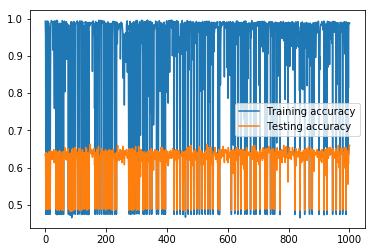

In [28]:
from matplotlib import pyplot as plt 
%matplotlib inline 
x_list =range(len(train_acc_list))

plt.plot(x_list, train_acc_list, label='Training accuracy')
plt.plot(x_list, test_acc_list, label='Testing accuracy')
plt.legend()
plt.show()

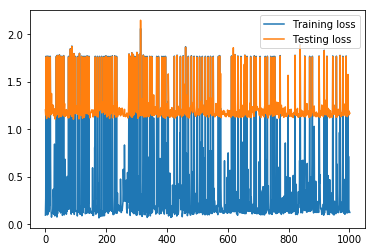

In [29]:
plt.plot(x_list, train_loss_list, label='Training loss')
plt.plot(x_list, test_loss_list, label='Testing loss')
plt.legend()
plt.show()